# Experiments

In [1]:
#!pip install matplotlib
#!pip install pandas
#!pip install tqdm

# code for importing from src
import os
os.chdir('../') # change working directory to the root of the project
# install package in editable mode
!pip install -e . 
os.chdir('src') # change working directory back to src

Obtaining file:///C:/Users/choho/Desktop/Master%20DS/Deep%20learning%20II/github/DeepLearning2-Project-M2DS
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for generative_model (pyproject.toml): started
  Building editable for generative_model (pyproject.toml): finished with status 'done'
  Created wheel for generative_model: filename=generative_model-0.1-0.editable-py3-none-any.whl size=13944 sha256=3a062fca1c7bbb080d1da3

In [2]:
# Import.
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from models.rbm import RBM
from models.dbn import DBN
from models.dnn import DNN
from utils import (
    load_mnist,
    load_alphadigit,
    read_alpha_digit,
    plot_characters_alphadigit,
    plot_generated_images
)

In [3]:
DATA_FOLDER = "../data/"
ALPHA_DIGIT_PATH = os.path.join(DATA_FOLDER, "binaryalphadigs.mat")
MNIST_PATH = os.path.join(DATA_FOLDER, "mnist_all.mat")

for path in [ALPHA_DIGIT_PATH, MNIST_PATH]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"The file {path} does not exist.")

SEED = 42

## 1. Study on BinaryAlphaDigit

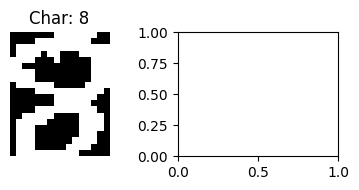

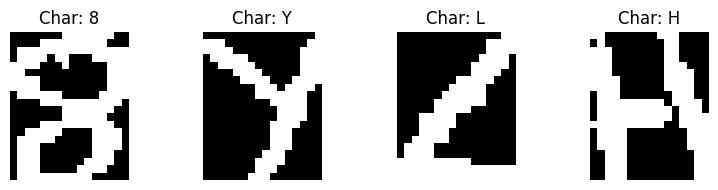

Original data: (36, 39)
Original data (unstack samples -> flatten images): (1365, 320)
Subset (1 character) data  (39, 320)
Subset (4 characters) data  (156, 320)


In [4]:
alphadigit = load_alphadigit(ALPHA_DIGIT_PATH)

chars_1 = [8]
chars_2 = chars_1 + ["Y"]
chars_3 = chars_2 + ["L"]
chars_4 = chars_3 + ["H"]
data_alpha_1 = read_alpha_digit(chars_1, data=alphadigit, use_data=True)
data_alpha_2 = read_alpha_digit(chars_2, data=alphadigit, use_data=True)
data_alpha_3 = read_alpha_digit(chars_3, data=alphadigit, use_data=True)
data_alpha_4 = read_alpha_digit(chars_4, data=alphadigit, use_data=True)

all_chars = np.arange(0, 35).tolist()
alphadigit_data = read_alpha_digit(all_chars, data=alphadigit, use_data=True) # read all characters

plot_characters_alphadigit(chars_1, data_alpha_1)
plot_characters_alphadigit(chars_4, data_alpha_4)

print("Original data:", alphadigit.shape)
print("Original data (unstack samples -> flatten images):", alphadigit_data.shape)
print(f"Subset ({len(chars_1)} character) data ", data_alpha_1.shape)
print(f"Subset ({len(chars_4)} characters) data ", data_alpha_4.shape)

### RBM

In [5]:
data_alpha = data_alpha_1
n_chars = data_alpha.shape[0] / 39

# Parameters
n_visible = data_alpha.shape[1]  # Number of visible units (size of each image)
n_hidden = 200  # Number of hidden units (hyperparameter)
learning_rate = 0.1
n_epochs = 100
batch_size = int(8 * n_chars)

# Initialize RBM
rbm = RBM(n_visible=n_visible, n_hidden=n_hidden, random_state=SEED)
print(rbm)

# Train RBM
rbm.train(data_alpha, learning_rate=learning_rate, n_epochs=n_epochs, batch_size=batch_size)

RBM(n_visible=320, n_hidden=200)


[0.2288,
 0.2056,
 0.2133,
 0.1863,
 0.184,
 0.1968,
 0.1862,
 0.1958,
 0.1735,
 0.1743,
 0.1879,
 0.1706,
 0.1564,
 0.1766,
 0.2011,
 0.158,
 0.199,
 0.1701,
 0.1641,
 0.2054,
 0.1746,
 0.1632,
 0.1348,
 0.1765,
 0.1417,
 0.1458,
 0.1404,
 0.1551,
 0.1345,
 0.1524,
 0.1437,
 0.1504,
 0.1596,
 0.1386,
 0.1311,
 0.1637,
 0.1363,
 0.1458,
 0.1603,
 0.1189,
 0.1173,
 0.1593,
 0.139,
 0.1317,
 0.1056,
 0.1481,
 0.1592,
 0.1063,
 0.1248,
 0.1268,
 0.1116,
 0.1078,
 0.1205,
 0.1015,
 0.1327,
 0.1222,
 0.1075,
 0.1284,
 0.1265,
 0.1534,
 0.0935,
 0.1138,
 0.1276,
 0.1299,
 0.1148,
 0.1249,
 0.1166,
 0.1173,
 0.1166,
 0.0965,
 0.1311,
 0.0987,
 0.109,
 0.1126,
 0.0896,
 0.1041,
 0.1231,
 0.1066,
 0.1022,
 0.1061,
 0.1104,
 0.1105,
 0.1055,
 0.1173,
 0.1136,
 0.1335,
 0.1006,
 0.1049,
 0.1133,
 0.1184,
 0.1014,
 0.1317,
 0.1081,
 0.0904,
 0.1172,
 0.085,
 0.1171,
 0.1191,
 0.1051,
 0.1293]

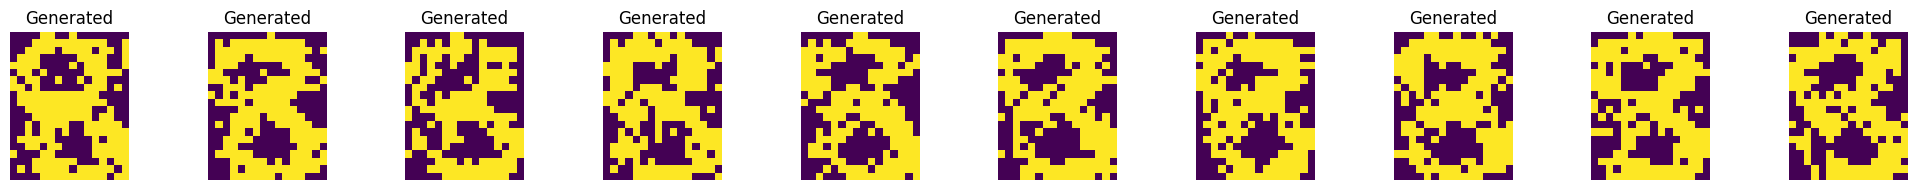

In [6]:
# Generate samples
generated_samples = rbm.generate_image(n_samples=10, n_gibbs_steps=1)

plot_generated_images(generated_samples, **{"cmap":None})

### DBN

In [7]:
data_alpha = data_alpha_1
n_chars = data_alpha.shape[0] / 39

# Parameters
n_visible = data_alpha.shape[1]  # Number of visible units (size of each image)
n_hidden = 200  # Number of hidden units (hyperparameter)
hidden_layer_sizes = [200, 200, 200]

learning_rate = 0.1
n_epochs = 100
batch_size = int(8 * n_chars)

dbn = DBN(n_visible=n_visible, hidden_layer_sizes=hidden_layer_sizes, random_state=SEED)
dbn.train(data_alpha, learning_rate=learning_rate, n_epochs=n_epochs, batch_size=batch_size)

Training RBM layers: 100%|██████████| 3/3 [00:02<00:00,  1.07layer/s]


([0.2288,
  0.2056,
  0.2133,
  0.1863,
  0.184,
  0.1968,
  0.1862,
  0.1958,
  0.1735,
  0.1743,
  0.1879,
  0.1706,
  0.1564,
  0.1766,
  0.2011,
  0.158,
  0.199,
  0.1701,
  0.1641,
  0.2054,
  0.1746,
  0.1632,
  0.1348,
  0.1765,
  0.1417,
  0.1458,
  0.1404,
  0.1551,
  0.1345,
  0.1524,
  0.1437,
  0.1504,
  0.1596,
  0.1386,
  0.1311,
  0.1637,
  0.1363,
  0.1458,
  0.1603,
  0.1189,
  0.1173,
  0.1593,
  0.139,
  0.1317,
  0.1056,
  0.1481,
  0.1592,
  0.1063,
  0.1248,
  0.1268,
  0.1116,
  0.1078,
  0.1205,
  0.1015,
  0.1327,
  0.1222,
  0.1075,
  0.1284,
  0.1265,
  0.1534,
  0.0935,
  0.1138,
  0.1276,
  0.1299,
  0.1148,
  0.1249,
  0.1166,
  0.1173,
  0.1166,
  0.0965,
  0.1311,
  0.0987,
  0.109,
  0.1126,
  0.0896,
  0.1041,
  0.1231,
  0.1066,
  0.1022,
  0.1061,
  0.1104,
  0.1105,
  0.1055,
  0.1173,
  0.1136,
  0.1335,
  0.1006,
  0.1049,
  0.1133,
  0.1184,
  0.1014,
  0.1317,
  0.1081,
  0.0904,
  0.1172,
  0.085,
  0.1171,
  0.1191,
  0.1051,
  0.1293,
  0.00

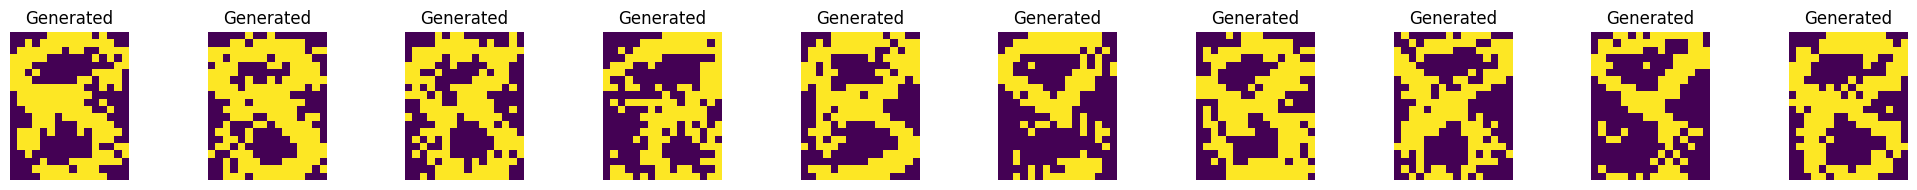

In [8]:
# # Generate images
generated_images = dbn.generate_image(n_samples=10, n_gibbs_steps=1)

# Display generated images
plot_generated_images(generated_images, **{"cmap":None})

### MNIST

In [9]:
import scipy.io

In [10]:
def load_mnist(mnist_path, mnist_dict=None, use_dict=False):
    if not use_dict:
        mnist_dict = scipy.io.loadmat(mnist_path)
    
    X_train = np.concatenate([mnist_dict[f"train{i}"] for i in range(10)], axis=0)
    X_test = np.concatenate([mnist_dict[f"test{i}"] for i in range(10)], axis=0)
    
    y_train = np.concatenate([np.eye(10)[[i]*mnist_dict[f"train{i}"].shape[0]] for i in range(10)], axis=0)
    y_test = np.concatenate([np.eye(10)[[i]*mnist_dict[f"test{i}"].shape[0]] for i in range(10)], axis=0)

    return X_train, y_train, X_test, y_test


def sample_indices(data_size: int, sample_size: int, random_state=None) -> np.ndarray:
    """
    Randomly sample indices from the range [0, data_size) without replacement.

    Parameters:
        data_size (int): Total number of indices available.
        sample_size (int): Number of indices to sample.
        random_state: Random seed for reproducibility.

    Returns:
        numpy.ndarray: Array of sampled indices.
    """
    rng = np.random.default_rng(random_state)
    if sample_size >= data_size:
        return np.arange(data_size)

    sampled_indices = rng.choice(data_size, size=sample_size, replace=False)
    return sampled_indices

def sample_mnist(X_train: np.ndarray, y_train: np.ndarray, sample_size: int, random_state=None) -> tuple:
    """
    Randomly sample a subset of samples from the MNIST dataset.

    Parameters:
        X_train (numpy.ndarray): Training data.
        y_train (numpy.ndarray): Training labels.
        sample_size (int): Number of samples to sample.
        random_state: Random seed for reproducibility.

    Returns:
        tuple: Sampled subset of training data and labels.
    """
    # Sample indices
    indices = sample_indices(len(X_train), sample_size, random_state=random_state)
    
    # Sample data and labels
    sampled_X_train = X_train[indices]
    sampled_y_train = y_train[indices]
    
    return sampled_X_train, sampled_y_train


def binarize_images(images):
    threshold = 127
    binary_images = np.where(images > threshold, 1, 0)
    return binary_images

mnist_train, mnist_train_labels, mnist_test, mnist_test_labels = (
    load_mnist(MNIST_PATH)
)


# Binarize the images
binary_mnist_train = binarize_images(mnist_train)
binary_mnist_test = binarize_images(mnist_test)


[mnist.shape for mnist in (mnist_train, mnist_train_labels, mnist_test, mnist_test_labels)]

[(60000, 784), (60000, 10), (10000, 784), (10000, 10)]

In [11]:
mnist_train_30000, mnist_train_labels_30000 = sample_mnist(mnist_train, mnist_train_labels, 30_000, 42)
mnist_train_30000.shape, mnist_train_labels_30000.shape

((30000, 784), (30000, 10))

In [12]:
print(mnist_train.max(), binary_mnist_train.max())

255 1


MNIST (60000, 28, 28)


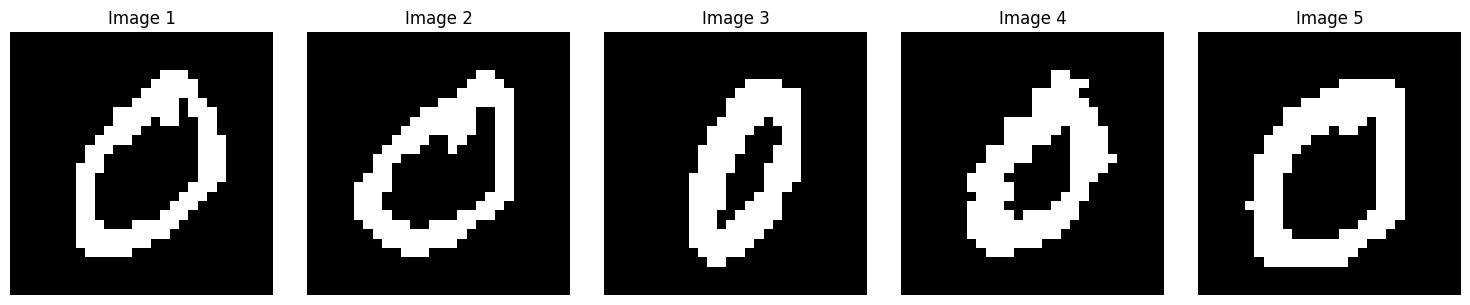

In [13]:
# Reshape mnist_train to its original shape
image_height = 28
image_width = 28
num_samples = binary_mnist_train.shape[0]
binary_mnist_train_images = binary_mnist_train.reshape(num_samples, image_height, image_width)
print("MNIST", binary_mnist_train_images.shape)

# Plot some images from mnist_train
num_images_to_plot = 5
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 3))
for i in range(num_images_to_plot):
    axes[i].imshow(binary_mnist_train_images[i], cmap='gray')
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [14]:
help(DNN)

Help on class DNN in module models.dnn:

class DNN(models.dbn.DBN)
 |  DNN(input_dim: int, output_dim: int, hidden_layer_sizes: List[int], random_state=None)
 |  
 |  Method resolution order:
 |      DNN
 |      models.dbn.DBN
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, key)
 |  
 |  __init__(self, input_dim: int, output_dim: int, hidden_layer_sizes: List[int], random_state=None)
 |      Initialize the Deep Neural Network (DNN).
 |      
 |      Parameters:
 |      - input_dim (int): Dimension of the input.
 |      - output_dim (int): Dimension of the output.
 |      - hidden_layer_sizes (List[int]): List of sizes for each hidden layer.
 |      - random_state: Random seed for reproducibility.
 |  
 |  __len__(self)
 |  
 |  __repr__(self)
 |      Return a string representation of the DBN object.
 |  
 |  backpropagation(self, input_data: numpy.ndarray, labels: numpy.ndarray, n_epochs: int = 100, learning_rate: float = 0.1, batch_size: int = 10, eps

# 0.Verify that DNN work well

Training:   1%|          | 1/100 [00:04<06:43,  4.08s/epoch]

Epoch 1/100, Cross Entropy: 1.8801176847831995


Training:   2%|▏         | 2/100 [00:08<06:35,  4.03s/epoch]

Epoch 2/100, Cross Entropy: 1.3738578301393412


Training:   3%|▎         | 3/100 [00:11<06:20,  3.93s/epoch]

Epoch 3/100, Cross Entropy: 1.2445853939108107


Training:   4%|▍         | 4/100 [00:16<06:26,  4.03s/epoch]

Epoch 4/100, Cross Entropy: 1.1968095759522615


Training:   5%|▌         | 5/100 [00:19<06:13,  3.94s/epoch]

Epoch 5/100, Cross Entropy: 1.1737903659902986


Training:   6%|▌         | 6/100 [00:23<06:16,  4.00s/epoch]

Epoch 6/100, Cross Entropy: 1.163332031301917


Training:   7%|▋         | 7/100 [00:27<06:04,  3.92s/epoch]

Epoch 7/100, Cross Entropy: 1.1495484192888554


Training:   8%|▊         | 8/100 [00:30<05:41,  3.71s/epoch]

Epoch 8/100, Cross Entropy: 1.1416592395775602


Training:   9%|▉         | 9/100 [00:34<05:30,  3.63s/epoch]

Epoch 9/100, Cross Entropy: 1.1442286821416654


Training:  10%|█         | 10/100 [00:38<05:37,  3.75s/epoch]

Epoch 10/100, Cross Entropy: 1.126230294364031


Training:  11%|█         | 11/100 [00:42<05:36,  3.78s/epoch]

Epoch 11/100, Cross Entropy: 1.1419021970936944


Training:  12%|█▏        | 12/100 [00:46<05:38,  3.85s/epoch]

Epoch 12/100, Cross Entropy: 1.13627647233082


Training:  13%|█▎        | 13/100 [00:50<05:44,  3.96s/epoch]

Epoch 13/100, Cross Entropy: 1.133585783303416


Training:  14%|█▍        | 14/100 [00:54<05:47,  4.04s/epoch]

Epoch 14/100, Cross Entropy: 1.1297739088148484


Training:  15%|█▌        | 15/100 [00:58<05:36,  3.96s/epoch]

Epoch 15/100, Cross Entropy: 1.1296877854081169


Training:  16%|█▌        | 16/100 [01:01<05:15,  3.76s/epoch]

Epoch 16/100, Cross Entropy: 1.1343510644633403


Training:  17%|█▋        | 17/100 [01:05<05:11,  3.75s/epoch]

Epoch 17/100, Cross Entropy: 1.1318655577297536


Training:  18%|█▊        | 18/100 [01:09<05:00,  3.67s/epoch]

Epoch 18/100, Cross Entropy: 1.1371842260573966


Training:  19%|█▉        | 19/100 [01:12<04:46,  3.54s/epoch]

Epoch 19/100, Cross Entropy: 1.1374307819537386


Training:  20%|██        | 20/100 [01:15<04:39,  3.49s/epoch]

Epoch 20/100, Cross Entropy: 1.1381971091326284


Training:  21%|██        | 21/100 [01:19<04:33,  3.46s/epoch]

Epoch 21/100, Cross Entropy: 1.1386446380594508


Training:  22%|██▏       | 22/100 [01:22<04:25,  3.41s/epoch]

Epoch 22/100, Cross Entropy: 1.1331187352400633


Training:  23%|██▎       | 23/100 [01:25<04:18,  3.35s/epoch]

Epoch 23/100, Cross Entropy: 1.1449536021588598


Training:  24%|██▍       | 24/100 [01:28<04:13,  3.33s/epoch]

Epoch 24/100, Cross Entropy: 1.1405061058906756


Training:  25%|██▌       | 25/100 [01:31<04:06,  3.29s/epoch]

Epoch 25/100, Cross Entropy: 1.1341592430613427


Training:  26%|██▌       | 26/100 [01:35<04:00,  3.25s/epoch]

Epoch 26/100, Cross Entropy: 1.133915929600394


Training:  27%|██▋       | 27/100 [01:38<03:52,  3.19s/epoch]

Epoch 27/100, Cross Entropy: 1.1336933681735013


Training:  28%|██▊       | 28/100 [01:41<03:45,  3.13s/epoch]

Epoch 28/100, Cross Entropy: 1.129855135930918


Training:  29%|██▉       | 29/100 [01:44<03:43,  3.15s/epoch]

Epoch 29/100, Cross Entropy: 1.1350859025842606


Training:  30%|███       | 30/100 [01:47<03:42,  3.18s/epoch]

Epoch 30/100, Cross Entropy: 1.1338423272459854


Training:  31%|███       | 31/100 [01:51<03:45,  3.27s/epoch]

Epoch 31/100, Cross Entropy: 1.1369841816543633


Training:  32%|███▏      | 32/100 [01:54<03:38,  3.22s/epoch]

Epoch 32/100, Cross Entropy: 1.133190787994968


Training:  33%|███▎      | 33/100 [01:57<03:40,  3.29s/epoch]

Epoch 33/100, Cross Entropy: 1.1358275507613036


Training:  34%|███▍      | 34/100 [02:00<03:36,  3.28s/epoch]

Epoch 34/100, Cross Entropy: 1.1334566028634567


Training:  35%|███▌      | 35/100 [02:04<03:37,  3.35s/epoch]

Epoch 35/100, Cross Entropy: 1.1353948180366413


Training:  36%|███▌      | 36/100 [02:07<03:33,  3.33s/epoch]

Epoch 36/100, Cross Entropy: 1.136642715960676


Training:  37%|███▋      | 37/100 [02:10<03:27,  3.29s/epoch]

Epoch 37/100, Cross Entropy: 1.1294191100239244


Training:  38%|███▊      | 38/100 [02:13<03:19,  3.22s/epoch]

Epoch 38/100, Cross Entropy: 1.1321053354470116


Training:  39%|███▉      | 39/100 [02:17<03:13,  3.18s/epoch]

Epoch 39/100, Cross Entropy: 1.1317211282542772


Training:  40%|████      | 40/100 [02:20<03:08,  3.14s/epoch]

Epoch 40/100, Cross Entropy: 1.1381604049949876


Training:  41%|████      | 41/100 [02:23<03:04,  3.13s/epoch]

Epoch 41/100, Cross Entropy: 1.1383711688570128


Training:  42%|████▏     | 42/100 [02:26<02:55,  3.02s/epoch]

Epoch 42/100, Cross Entropy: 1.1344704208396703


Training:  43%|████▎     | 43/100 [02:28<02:50,  3.00s/epoch]

Epoch 43/100, Cross Entropy: 1.1363711089009758


Training:  44%|████▍     | 44/100 [02:32<02:50,  3.05s/epoch]

Epoch 44/100, Cross Entropy: 1.1389682082507184


Training:  45%|████▌     | 45/100 [02:35<02:50,  3.11s/epoch]

Epoch 45/100, Cross Entropy: 1.1341327841461262


Training:  46%|████▌     | 46/100 [02:38<02:46,  3.08s/epoch]

Epoch 46/100, Cross Entropy: 1.1378993980550103


Training:  47%|████▋     | 47/100 [02:41<02:48,  3.19s/epoch]

Epoch 47/100, Cross Entropy: 1.1392799354716372


Training:  48%|████▊     | 48/100 [02:45<02:55,  3.37s/epoch]

Epoch 48/100, Cross Entropy: 1.130932487285503


Training:  49%|████▉     | 49/100 [02:49<02:58,  3.50s/epoch]

Epoch 49/100, Cross Entropy: 1.135030940629755


Training:  50%|█████     | 50/100 [02:52<02:52,  3.45s/epoch]

Epoch 50/100, Cross Entropy: 1.134460706844424


Training:  51%|█████     | 51/100 [02:56<02:49,  3.47s/epoch]

Epoch 51/100, Cross Entropy: 1.138790384786377


Training:  52%|█████▏    | 52/100 [02:59<02:46,  3.47s/epoch]

Epoch 52/100, Cross Entropy: 1.1289587718805048


Training:  53%|█████▎    | 53/100 [03:02<02:39,  3.39s/epoch]

Epoch 53/100, Cross Entropy: 1.1313112157228542


Training:  54%|█████▍    | 54/100 [03:06<02:35,  3.38s/epoch]

Epoch 54/100, Cross Entropy: 1.1359013218356735


Training:  55%|█████▌    | 55/100 [03:10<02:36,  3.49s/epoch]

Epoch 55/100, Cross Entropy: 1.1361320618772448


Training:  56%|█████▌    | 56/100 [03:14<02:43,  3.72s/epoch]

Epoch 56/100, Cross Entropy: 1.1384966214773036


Training:  57%|█████▋    | 57/100 [03:18<02:47,  3.89s/epoch]

Epoch 57/100, Cross Entropy: 1.13565234903598


Training:  58%|█████▊    | 58/100 [03:22<02:42,  3.88s/epoch]

Epoch 58/100, Cross Entropy: 1.1336598499497081


Training:  59%|█████▉    | 59/100 [03:26<02:39,  3.89s/epoch]

Epoch 59/100, Cross Entropy: 1.1393550178019851


Training:  60%|██████    | 60/100 [03:30<02:32,  3.82s/epoch]

Epoch 60/100, Cross Entropy: 1.1321863067884068


Training:  61%|██████    | 61/100 [03:33<02:30,  3.87s/epoch]

Epoch 61/100, Cross Entropy: 1.1326987529999812


Training:  62%|██████▏   | 62/100 [03:37<02:25,  3.83s/epoch]

Epoch 62/100, Cross Entropy: 1.129810181254043


Training:  63%|██████▎   | 63/100 [03:41<02:22,  3.85s/epoch]

Epoch 63/100, Cross Entropy: 1.1302585837565586


Training:  64%|██████▍   | 64/100 [03:45<02:20,  3.91s/epoch]

Epoch 64/100, Cross Entropy: 1.1366577800356439


Training:  65%|██████▌   | 65/100 [03:49<02:15,  3.86s/epoch]

Epoch 65/100, Cross Entropy: 1.1328186790027415


Training:  66%|██████▌   | 66/100 [03:53<02:13,  3.92s/epoch]

Epoch 66/100, Cross Entropy: 1.1338998578474995


Training:  67%|██████▋   | 67/100 [03:57<02:10,  3.96s/epoch]

Epoch 67/100, Cross Entropy: 1.1319500679659094


Training:  68%|██████▊   | 68/100 [04:01<02:05,  3.93s/epoch]

Epoch 68/100, Cross Entropy: 1.1323551699902379


Training:  69%|██████▉   | 69/100 [04:05<02:02,  3.96s/epoch]

Epoch 69/100, Cross Entropy: 1.1348439594366673


Training:  70%|███████   | 70/100 [04:09<01:57,  3.91s/epoch]

Epoch 70/100, Cross Entropy: 1.1378946568105213


Training:  71%|███████   | 71/100 [04:13<01:54,  3.95s/epoch]

Epoch 71/100, Cross Entropy: 1.1339843018776294


Training:  72%|███████▏  | 72/100 [04:17<01:49,  3.90s/epoch]

Epoch 72/100, Cross Entropy: 1.1345837437334203


Training:  73%|███████▎  | 73/100 [04:20<01:45,  3.91s/epoch]

Epoch 73/100, Cross Entropy: 1.133070951436432


Training:  74%|███████▍  | 74/100 [04:24<01:41,  3.90s/epoch]

Epoch 74/100, Cross Entropy: 1.1319710983925773


Training:  75%|███████▌  | 75/100 [04:28<01:37,  3.90s/epoch]

Epoch 75/100, Cross Entropy: 1.1331387034791975


Training:  76%|███████▌  | 76/100 [04:32<01:34,  3.94s/epoch]

Epoch 76/100, Cross Entropy: 1.137435099300768


Training:  77%|███████▋  | 77/100 [04:36<01:30,  3.95s/epoch]

Epoch 77/100, Cross Entropy: 1.1426091421430573


Training:  78%|███████▊  | 78/100 [04:40<01:26,  3.94s/epoch]

Epoch 78/100, Cross Entropy: 1.133141547699185


Training:  79%|███████▉  | 79/100 [04:44<01:22,  3.94s/epoch]

Epoch 79/100, Cross Entropy: 1.1399302455577496


Training:  80%|████████  | 80/100 [04:48<01:18,  3.92s/epoch]

Epoch 80/100, Cross Entropy: 1.1295414788029228


Training:  81%|████████  | 81/100 [04:52<01:15,  3.96s/epoch]

Epoch 81/100, Cross Entropy: 1.1336280951108078


Training:  82%|████████▏ | 82/100 [04:56<01:10,  3.91s/epoch]

Epoch 82/100, Cross Entropy: 1.134941731901634


Training:  83%|████████▎ | 83/100 [05:00<01:06,  3.91s/epoch]

Epoch 83/100, Cross Entropy: 1.130255856566189


Training:  84%|████████▍ | 84/100 [05:04<01:02,  3.92s/epoch]

Epoch 84/100, Cross Entropy: 1.1335878230848366


Training:  85%|████████▌ | 85/100 [05:08<00:59,  3.94s/epoch]

Epoch 85/100, Cross Entropy: 1.1320508475965674


Training:  86%|████████▌ | 86/100 [05:12<00:55,  3.93s/epoch]

Epoch 86/100, Cross Entropy: 1.1348537053508596


Training:  87%|████████▋ | 87/100 [05:16<00:51,  3.93s/epoch]

Epoch 87/100, Cross Entropy: 1.1300201972016979


Training:  88%|████████▊ | 88/100 [05:19<00:47,  3.94s/epoch]

Epoch 88/100, Cross Entropy: 1.1291717232322789


Training:  89%|████████▉ | 89/100 [05:23<00:43,  3.97s/epoch]

Epoch 89/100, Cross Entropy: 1.1340501637108011


Training:  90%|█████████ | 90/100 [05:27<00:38,  3.87s/epoch]

Epoch 90/100, Cross Entropy: 1.1380786601789787


Training:  91%|█████████ | 91/100 [05:31<00:35,  3.92s/epoch]

Epoch 91/100, Cross Entropy: 1.1315332889305971


Training:  92%|█████████▏| 92/100 [05:35<00:30,  3.87s/epoch]

Epoch 92/100, Cross Entropy: 1.1321783651497224


Training:  93%|█████████▎| 93/100 [05:39<00:27,  3.95s/epoch]

Epoch 93/100, Cross Entropy: 1.1319658603038272


Training:  94%|█████████▍| 94/100 [05:43<00:23,  3.95s/epoch]

Epoch 94/100, Cross Entropy: 1.12822841646024


Training:  95%|█████████▌| 95/100 [05:47<00:19,  3.96s/epoch]

Epoch 95/100, Cross Entropy: 1.1310460319363869


Training:  96%|█████████▌| 96/100 [05:51<00:15,  3.97s/epoch]

Epoch 96/100, Cross Entropy: 1.1322208953501345


Training:  97%|█████████▋| 97/100 [05:55<00:11,  3.98s/epoch]

Epoch 97/100, Cross Entropy: 1.1348550862720086


Training:  98%|█████████▊| 98/100 [05:59<00:07,  3.95s/epoch]

Epoch 98/100, Cross Entropy: 1.1304606780164823


Training:  99%|█████████▉| 99/100 [06:04<00:04,  4.16s/epoch]

Epoch 99/100, Cross Entropy: 1.1337746867934928


Training: 100%|██████████| 100/100 [06:07<00:00,  3.68s/epoch]


Epoch 100/100, Cross Entropy: 1.1341972677424734


c:\Users\choho\Desktop\Master DS\Deep learning II\github\DeepLearning2-Project-M2DS\src\functionals.py:17: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


(0.20430000000000004, array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]]))


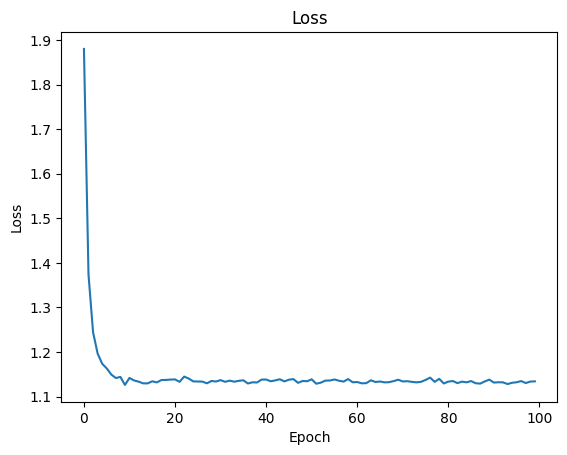

In [15]:
from copy import copy, deepcopy

data = mnist_train.copy()
n_samples, n_visible = data.shape # n_samples, n_features
n_visible = data.shape[1]
hidden_layer_sizes = [250]
n_classes = mnist_test_labels.shape[1]

dnn = DNN(input_dim=n_visible, output_dim=n_classes, hidden_layer_sizes=hidden_layer_sizes, random_state=42)

losses_100 = dnn.backpropagation(binary_mnist_train, labels=mnist_train_labels, n_epochs=100, learning_rate=3e-4, batch_size=512)


print(dnn.test(binary_mnist_test, mnist_test_labels))

#plotter la loss à partir d'une liste de loss
plt.plot(losses_100)
plt.title("Loss")   
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [16]:
print(dnn.test(binary_mnist_test, mnist_test_labels))


(0.37470000000000003, array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]]))


# 1. Error rate according to varying layers numbers

In [18]:
import matplotlib.pyplot as plt
import pickle
import numpy as np


def save_object(obj, filename, output_dir):
    """
    Save a Python object to a file using pickle.

    Parameters:
    - obj: The Python object to save.
    - filename (str): The name of the file to save the object to.
    - output_dir (str): The directory where to save the file.
    """
    os.makedirs(output_dir, exist_ok=True)
    filepath = os.path.join(output_dir, filename)
    with open(filepath, 'wb') as f:
        pickle.dump(obj, f)

def load_object(filename, output_dir):
    """
    Load a Python object from a file using pickle.

    Parameters:
    - filename (str): The name of the file to load the object from.
    - output_dir (str): The directory where the file is located.

    Returns:
    - The Python object loaded from the file.
    """
    filepath = os.path.join(output_dir, filename)
    with open(filepath, 'rb') as f:
        return pickle.load(f)

## 1.1. Without pretraining

In [20]:
n_samples, n_visible = mnist_train.shape # n_samples, n_features
n_classes = mnist_test_labels.shape[1]

layer_loss = []
layer_error_rate_train = []
layer_error_rate_test = []
for n_layers in [1, 2, 3, 4, 5]:
    hidden_layer_sizes = [256] * n_layers
    dnn = DNN(input_dim=n_visible, output_dim=n_classes, hidden_layer_sizes=hidden_layer_sizes, random_state=42)
    loss = dnn.backpropagation(binary_mnist_train, labels=mnist_train_labels, n_epochs=100, learning_rate=3e-4, batch_size=512)
    layer_loss.append(loss)
    
    error_rate_train, _ = dnn.test(test_data=binary_mnist_train, true_labels=mnist_train_labels)
    layer_error_rate_train.append(error_rate_train)  # Assurez-vous que error_rate_train est un scalaire

    error_rate_test, _ = dnn.test(test_data=binary_mnist_test, true_labels=mnist_test_labels)
    layer_error_rate_test.append(error_rate_test)  # Assurez-vous que error_rate_test est un scalaire

    # Save the lists with losses and error rates
    save_object(layer_loss, "layer_loss_" + str(n_layers) + ".pkl", output_dir="../results/experiments_mnist")
    save_object(layer_error_rate_train, "layer_error_rate_train_" + str(n_layers) + ".pkl",output_dir="../results/experiments_mnist")
    save_object(layer_error_rate_test, "layer_error_rate_test_" + str(n_layers) + ".pkl",output_dir="../results/experiments_mnist")


Training:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training:   1%|          | 1/100 [00:03<05:33,  3.37s/epoch]

Epoch 1/100, Cross Entropy: 1.8894495130492934


Training:   2%|▏         | 2/100 [00:06<05:34,  3.41s/epoch]

Epoch 2/100, Cross Entropy: 1.3622334863334205


Training:   3%|▎         | 3/100 [00:11<06:10,  3.82s/epoch]

Epoch 3/100, Cross Entropy: 1.2261330035747475


Training:   4%|▍         | 4/100 [00:14<06:05,  3.81s/epoch]

Epoch 4/100, Cross Entropy: 1.1810666422878717


Training:   5%|▌         | 5/100 [00:18<05:50,  3.69s/epoch]

Epoch 5/100, Cross Entropy: 1.1525038487495025


Training:   6%|▌         | 6/100 [00:21<05:43,  3.66s/epoch]

Epoch 6/100, Cross Entropy: 1.1451010907015398


Training:   7%|▋         | 7/100 [00:26<05:54,  3.81s/epoch]

Epoch 7/100, Cross Entropy: 1.1241728928470616


Training:   8%|▊         | 8/100 [00:29<05:44,  3.74s/epoch]

Epoch 8/100, Cross Entropy: 1.1297777638636135


Training:   9%|▉         | 9/100 [00:33<05:54,  3.89s/epoch]

Epoch 9/100, Cross Entropy: 1.1256656737570856


Training:  10%|█         | 10/100 [00:37<05:37,  3.75s/epoch]

Epoch 10/100, Cross Entropy: 1.1179058233789605


Training:  11%|█         | 11/100 [00:40<05:20,  3.60s/epoch]

Epoch 11/100, Cross Entropy: 1.123186789084615


Training:  12%|█▏        | 12/100 [00:44<05:15,  3.59s/epoch]

Epoch 12/100, Cross Entropy: 1.1252553041850064


Training:  13%|█▎        | 13/100 [00:47<05:16,  3.63s/epoch]

Epoch 13/100, Cross Entropy: 1.1229895217989136


Training:  14%|█▍        | 14/100 [00:51<05:20,  3.73s/epoch]

Epoch 14/100, Cross Entropy: 1.1193475053717734


Training:  15%|█▌        | 15/100 [00:55<05:16,  3.72s/epoch]

Epoch 15/100, Cross Entropy: 1.1232542396966028


Training:  16%|█▌        | 16/100 [00:59<05:15,  3.76s/epoch]

Epoch 16/100, Cross Entropy: 1.1208535687113863


Training:  17%|█▋        | 17/100 [01:02<05:05,  3.67s/epoch]

Epoch 17/100, Cross Entropy: 1.115237174640047


Training:  18%|█▊        | 18/100 [01:06<04:52,  3.57s/epoch]

Epoch 18/100, Cross Entropy: 1.1151606885520429


Training:  19%|█▉        | 19/100 [01:09<04:38,  3.44s/epoch]

Epoch 19/100, Cross Entropy: 1.1168953673416866


Training:  20%|██        | 20/100 [01:12<04:27,  3.35s/epoch]

Epoch 20/100, Cross Entropy: 1.1097935536700043


Training:  21%|██        | 21/100 [01:15<04:21,  3.30s/epoch]

Epoch 21/100, Cross Entropy: 1.1225009536842032


Training:  22%|██▏       | 22/100 [01:18<04:12,  3.24s/epoch]

Epoch 22/100, Cross Entropy: 1.1193339997472114


Training:  23%|██▎       | 23/100 [01:21<04:06,  3.20s/epoch]

Epoch 23/100, Cross Entropy: 1.1187991022920825


Training:  24%|██▍       | 24/100 [01:25<04:01,  3.18s/epoch]

Epoch 24/100, Cross Entropy: 1.1168383571063638


Training:  25%|██▌       | 25/100 [01:28<03:58,  3.18s/epoch]

Epoch 25/100, Cross Entropy: 1.1140288666137286


Training:  26%|██▌       | 26/100 [01:31<03:56,  3.20s/epoch]

Epoch 26/100, Cross Entropy: 1.1101725950812449


Training:  27%|██▋       | 27/100 [01:34<04:00,  3.29s/epoch]

Epoch 27/100, Cross Entropy: 1.1145642079059963


Training:  28%|██▊       | 28/100 [01:38<03:56,  3.29s/epoch]

Epoch 28/100, Cross Entropy: 1.1207814756496581


Training:  29%|██▉       | 29/100 [01:41<03:54,  3.30s/epoch]

Epoch 29/100, Cross Entropy: 1.1173797015637201


Training:  30%|███       | 30/100 [01:44<03:49,  3.27s/epoch]

Epoch 30/100, Cross Entropy: 1.1123287909322659


Training:  31%|███       | 31/100 [01:47<03:43,  3.24s/epoch]

Epoch 31/100, Cross Entropy: 1.1151494621734528


Training:  32%|███▏      | 32/100 [01:51<03:37,  3.20s/epoch]

Epoch 32/100, Cross Entropy: 1.1177344176694213


Training:  33%|███▎      | 33/100 [01:54<03:34,  3.19s/epoch]

Epoch 33/100, Cross Entropy: 1.119265573385496


Training:  34%|███▍      | 34/100 [01:57<03:30,  3.19s/epoch]

Epoch 34/100, Cross Entropy: 1.1184772784642887


Training:  35%|███▌      | 35/100 [02:00<03:28,  3.21s/epoch]

Epoch 35/100, Cross Entropy: 1.1193698883748855


Training:  36%|███▌      | 36/100 [02:03<03:25,  3.21s/epoch]

Epoch 36/100, Cross Entropy: 1.1165316627848643


Training:  37%|███▋      | 37/100 [02:07<03:23,  3.23s/epoch]

Epoch 37/100, Cross Entropy: 1.1158557630318806


Training:  38%|███▊      | 38/100 [02:10<03:24,  3.29s/epoch]

Epoch 38/100, Cross Entropy: 1.1165783485032341


Training:  39%|███▉      | 39/100 [02:13<03:18,  3.26s/epoch]

Epoch 39/100, Cross Entropy: 1.1153346418781245


Training:  40%|████      | 40/100 [02:16<03:14,  3.24s/epoch]

Epoch 40/100, Cross Entropy: 1.1192346182211876


Training:  41%|████      | 41/100 [02:20<03:09,  3.22s/epoch]

Epoch 41/100, Cross Entropy: 1.1123421592687488


Training:  42%|████▏     | 42/100 [02:23<03:06,  3.22s/epoch]

Epoch 42/100, Cross Entropy: 1.1156124899651056


Training:  43%|████▎     | 43/100 [02:26<03:05,  3.26s/epoch]

Epoch 43/100, Cross Entropy: 1.113658178148151


Training:  44%|████▍     | 44/100 [02:29<02:59,  3.21s/epoch]

Epoch 44/100, Cross Entropy: 1.1156014924751567


Training:  45%|████▌     | 45/100 [02:32<02:55,  3.19s/epoch]

Epoch 45/100, Cross Entropy: 1.1160015299357742


Training:  46%|████▌     | 46/100 [02:36<02:51,  3.18s/epoch]

Epoch 46/100, Cross Entropy: 1.108570208309051


Training:  47%|████▋     | 47/100 [02:39<02:46,  3.15s/epoch]

Epoch 47/100, Cross Entropy: 1.1208186900245278


Training:  48%|████▊     | 48/100 [02:42<02:42,  3.13s/epoch]

Epoch 48/100, Cross Entropy: 1.1194865226979764


Training:  49%|████▉     | 49/100 [02:45<02:41,  3.16s/epoch]

Epoch 49/100, Cross Entropy: 1.1189989433151288


Training:  50%|█████     | 50/100 [02:48<02:38,  3.17s/epoch]

Epoch 50/100, Cross Entropy: 1.1187089301714628


Training:  51%|█████     | 51/100 [02:51<02:34,  3.15s/epoch]

Epoch 51/100, Cross Entropy: 1.1206230176490464


Training:  52%|█████▏    | 52/100 [02:54<02:29,  3.12s/epoch]

Epoch 52/100, Cross Entropy: 1.112905124527376


Training:  53%|█████▎    | 53/100 [02:58<02:27,  3.15s/epoch]

Epoch 53/100, Cross Entropy: 1.1190821849959138


Training:  54%|█████▍    | 54/100 [03:01<02:24,  3.14s/epoch]

Epoch 54/100, Cross Entropy: 1.1116873432952412


Training:  55%|█████▌    | 55/100 [03:04<02:20,  3.13s/epoch]

Epoch 55/100, Cross Entropy: 1.114063882001985


Training:  56%|█████▌    | 56/100 [03:07<02:16,  3.11s/epoch]

Epoch 56/100, Cross Entropy: 1.1192117342318078


Training:  57%|█████▋    | 57/100 [03:10<02:16,  3.18s/epoch]

Epoch 57/100, Cross Entropy: 1.1161844290503211


Training:  58%|█████▊    | 58/100 [03:13<02:12,  3.16s/epoch]

Epoch 58/100, Cross Entropy: 1.1204397863323203


Training:  59%|█████▉    | 59/100 [03:17<02:12,  3.22s/epoch]

Epoch 59/100, Cross Entropy: 1.1189318267131332


Training:  60%|██████    | 60/100 [03:20<02:08,  3.21s/epoch]

Epoch 60/100, Cross Entropy: 1.1176005057778289


Training:  61%|██████    | 61/100 [03:23<02:05,  3.23s/epoch]

Epoch 61/100, Cross Entropy: 1.116676369725429


Training:  62%|██████▏   | 62/100 [03:27<02:05,  3.30s/epoch]

Epoch 62/100, Cross Entropy: 1.121176347928897


Training:  63%|██████▎   | 63/100 [03:30<02:01,  3.29s/epoch]

Epoch 63/100, Cross Entropy: 1.1140078919799314


Training:  64%|██████▍   | 64/100 [03:33<02:00,  3.36s/epoch]

Epoch 64/100, Cross Entropy: 1.1188178458861735


Training:  65%|██████▌   | 65/100 [03:38<02:06,  3.62s/epoch]

Epoch 65/100, Cross Entropy: 1.115295551818676


Training:  66%|██████▌   | 66/100 [03:41<02:01,  3.57s/epoch]

Epoch 66/100, Cross Entropy: 1.112268710872094


Training:  67%|██████▋   | 67/100 [03:44<01:55,  3.51s/epoch]

Epoch 67/100, Cross Entropy: 1.1170759196940718


Training:  68%|██████▊   | 68/100 [03:48<01:49,  3.43s/epoch]

Epoch 68/100, Cross Entropy: 1.1173693571455896


Training:  69%|██████▉   | 69/100 [03:51<01:46,  3.42s/epoch]

Epoch 69/100, Cross Entropy: 1.1159039031404954


Training:  70%|███████   | 70/100 [03:54<01:41,  3.39s/epoch]

Epoch 70/100, Cross Entropy: 1.1171443866450173


Training:  71%|███████   | 71/100 [03:58<01:39,  3.42s/epoch]

Epoch 71/100, Cross Entropy: 1.1221074509906044


Training:  72%|███████▏  | 72/100 [04:02<01:38,  3.50s/epoch]

Epoch 72/100, Cross Entropy: 1.1193813682805245


Training:  73%|███████▎  | 73/100 [04:05<01:33,  3.47s/epoch]

Epoch 73/100, Cross Entropy: 1.1211890577613188


Training:  74%|███████▍  | 74/100 [04:09<01:30,  3.50s/epoch]

Epoch 74/100, Cross Entropy: 1.120059886385198


Training:  75%|███████▌  | 75/100 [04:12<01:25,  3.42s/epoch]

Epoch 75/100, Cross Entropy: 1.1200193406641172


Training:  76%|███████▌  | 76/100 [04:15<01:20,  3.34s/epoch]

Epoch 76/100, Cross Entropy: 1.1113434642059699


Training:  77%|███████▋  | 77/100 [04:18<01:15,  3.29s/epoch]

Epoch 77/100, Cross Entropy: 1.1174074646184815


Training:  78%|███████▊  | 78/100 [04:21<01:12,  3.31s/epoch]

Epoch 78/100, Cross Entropy: 1.1232067740409426


Training:  79%|███████▉  | 79/100 [04:25<01:10,  3.35s/epoch]

Epoch 79/100, Cross Entropy: 1.117665790782189


Training:  80%|████████  | 80/100 [04:28<01:08,  3.41s/epoch]

Epoch 80/100, Cross Entropy: 1.1163002257140593


Training:  81%|████████  | 81/100 [04:32<01:05,  3.44s/epoch]

Epoch 81/100, Cross Entropy: 1.1202168973668631


Training:  82%|████████▏ | 82/100 [04:36<01:02,  3.49s/epoch]

Epoch 82/100, Cross Entropy: 1.1224551688377464


Training:  83%|████████▎ | 83/100 [04:39<00:59,  3.50s/epoch]

Epoch 83/100, Cross Entropy: 1.1125767202904846


Training:  84%|████████▍ | 84/100 [04:43<00:55,  3.48s/epoch]

Epoch 84/100, Cross Entropy: 1.115952428920982


Training:  85%|████████▌ | 85/100 [04:46<00:51,  3.41s/epoch]

Epoch 85/100, Cross Entropy: 1.1178196981712243


Training:  86%|████████▌ | 86/100 [04:49<00:46,  3.36s/epoch]

Epoch 86/100, Cross Entropy: 1.1139932138009017


Training:  87%|████████▋ | 87/100 [04:52<00:43,  3.35s/epoch]

Epoch 87/100, Cross Entropy: 1.1112717351575498


Training:  88%|████████▊ | 88/100 [04:56<00:40,  3.35s/epoch]

Epoch 88/100, Cross Entropy: 1.1202030006908903


Training:  89%|████████▉ | 89/100 [04:59<00:36,  3.35s/epoch]

Epoch 89/100, Cross Entropy: 1.1185074744944712


Training:  90%|█████████ | 90/100 [05:02<00:32,  3.29s/epoch]

Epoch 90/100, Cross Entropy: 1.1233901655816767


Training:  91%|█████████ | 91/100 [05:06<00:29,  3.31s/epoch]

Epoch 91/100, Cross Entropy: 1.1137203363482049


Training:  92%|█████████▏| 92/100 [05:09<00:26,  3.26s/epoch]

Epoch 92/100, Cross Entropy: 1.1113301075254278


Training:  93%|█████████▎| 93/100 [05:12<00:22,  3.26s/epoch]

Epoch 93/100, Cross Entropy: 1.117259254604408


Training:  94%|█████████▍| 94/100 [05:15<00:19,  3.27s/epoch]

Epoch 94/100, Cross Entropy: 1.1174313253433954


Training:  95%|█████████▌| 95/100 [05:18<00:16,  3.23s/epoch]

Epoch 95/100, Cross Entropy: 1.1182719344096763


Training:  96%|█████████▌| 96/100 [05:22<00:12,  3.21s/epoch]

Epoch 96/100, Cross Entropy: 1.122635099138483


Training:  97%|█████████▋| 97/100 [05:25<00:09,  3.19s/epoch]

Epoch 97/100, Cross Entropy: 1.115106887691493


Training:  98%|█████████▊| 98/100 [05:28<00:06,  3.20s/epoch]

Epoch 98/100, Cross Entropy: 1.1183665825672986


Training:  99%|█████████▉| 99/100 [05:31<00:03,  3.13s/epoch]

Epoch 99/100, Cross Entropy: 1.1146287591666846


Training: 100%|██████████| 100/100 [05:34<00:00,  3.34s/epoch]


Epoch 100/100, Cross Entropy: 1.1159461350066078


Training:   1%|          | 1/100 [00:04<07:26,  4.51s/epoch]

Epoch 1/100, Cross Entropy: 2.392917777888298


Training:   2%|▏         | 2/100 [00:09<07:55,  4.85s/epoch]

Epoch 2/100, Cross Entropy: 2.2114637105292756


Training:   3%|▎         | 3/100 [00:14<07:50,  4.85s/epoch]

Epoch 3/100, Cross Entropy: 2.1438502810424156


Training:   4%|▍         | 4/100 [00:19<07:49,  4.89s/epoch]

Epoch 4/100, Cross Entropy: 2.108366821411852


Training:   5%|▌         | 5/100 [00:24<07:47,  4.92s/epoch]

Epoch 5/100, Cross Entropy: 2.094224263364985


Training:   6%|▌         | 6/100 [00:29<07:52,  5.03s/epoch]

Epoch 6/100, Cross Entropy: 2.091301714436028


Training:   7%|▋         | 7/100 [00:34<07:55,  5.11s/epoch]

Epoch 7/100, Cross Entropy: 2.0861923483398326


Training:   8%|▊         | 8/100 [00:40<07:50,  5.12s/epoch]

Epoch 8/100, Cross Entropy: 2.085387004591194


Training:   9%|▉         | 9/100 [00:44<07:37,  5.03s/epoch]

Epoch 9/100, Cross Entropy: 2.0829823925254307


Training:  10%|█         | 10/100 [00:49<07:32,  5.03s/epoch]

Epoch 10/100, Cross Entropy: 2.086827593093157


Training:  11%|█         | 11/100 [00:55<07:29,  5.06s/epoch]

Epoch 11/100, Cross Entropy: 2.086338196262045


Training:  12%|█▏        | 12/100 [01:00<07:29,  5.11s/epoch]

Epoch 12/100, Cross Entropy: 2.083607971387996


Training:  13%|█▎        | 13/100 [01:04<07:14,  5.00s/epoch]

Epoch 13/100, Cross Entropy: 2.0851414418971603


Training:  14%|█▍        | 14/100 [01:09<07:08,  4.98s/epoch]

Epoch 14/100, Cross Entropy: 2.082415352323276


Training:  15%|█▌        | 15/100 [01:14<07:03,  4.98s/epoch]

Epoch 15/100, Cross Entropy: 2.0806942608894303


Training:  16%|█▌        | 16/100 [01:19<07:01,  5.02s/epoch]

Epoch 16/100, Cross Entropy: 2.08745045252577


Training:  17%|█▋        | 17/100 [01:25<06:56,  5.02s/epoch]

Epoch 17/100, Cross Entropy: 2.0827416299694224


Training:  18%|█▊        | 18/100 [01:29<06:46,  4.96s/epoch]

Epoch 18/100, Cross Entropy: 2.082396483633067


Training:  19%|█▉        | 19/100 [01:34<06:39,  4.93s/epoch]

Epoch 19/100, Cross Entropy: 2.0837345093688158


Training:  20%|██        | 20/100 [01:39<06:31,  4.90s/epoch]

Epoch 20/100, Cross Entropy: 2.0831683631980753


Training:  21%|██        | 21/100 [01:44<06:19,  4.80s/epoch]

Epoch 21/100, Cross Entropy: 2.0840172298841337


Training:  22%|██▏       | 22/100 [01:48<06:09,  4.74s/epoch]

Epoch 22/100, Cross Entropy: 2.0830731684052592


Training:  23%|██▎       | 23/100 [01:53<06:07,  4.77s/epoch]

Epoch 23/100, Cross Entropy: 2.0857772351931994


Training:  24%|██▍       | 24/100 [01:58<06:02,  4.77s/epoch]

Epoch 24/100, Cross Entropy: 2.086716481510962


Training:  25%|██▌       | 25/100 [02:03<05:58,  4.78s/epoch]

Epoch 25/100, Cross Entropy: 2.0804112968293658


Training:  26%|██▌       | 26/100 [02:08<06:00,  4.87s/epoch]

Epoch 26/100, Cross Entropy: 2.083130428683545


Training:  27%|██▋       | 27/100 [02:13<05:58,  4.91s/epoch]

Epoch 27/100, Cross Entropy: 2.0858087463981723


Training:  28%|██▊       | 28/100 [02:18<05:51,  4.89s/epoch]

Epoch 28/100, Cross Entropy: 2.081437219754673


Training:  29%|██▉       | 29/100 [02:22<05:45,  4.87s/epoch]

Epoch 29/100, Cross Entropy: 2.0820190606469757


Training:  30%|███       | 30/100 [02:27<05:42,  4.89s/epoch]

Epoch 30/100, Cross Entropy: 2.0844971289398297


Training:  31%|███       | 31/100 [02:32<05:33,  4.83s/epoch]

Epoch 31/100, Cross Entropy: 2.084426154949836


Training:  32%|███▏      | 32/100 [02:37<05:24,  4.77s/epoch]

Epoch 32/100, Cross Entropy: 2.089230309960596


Training:  33%|███▎      | 33/100 [02:41<05:14,  4.69s/epoch]

Epoch 33/100, Cross Entropy: 2.082577126122465


Training:  34%|███▍      | 34/100 [02:46<05:06,  4.65s/epoch]

Epoch 34/100, Cross Entropy: 2.0857082725883247


Training:  35%|███▌      | 35/100 [02:50<05:01,  4.65s/epoch]

Epoch 35/100, Cross Entropy: 2.0880667053977118


Training:  36%|███▌      | 36/100 [02:55<04:59,  4.68s/epoch]

Epoch 36/100, Cross Entropy: 2.0827623331673717


Training:  37%|███▋      | 37/100 [03:00<04:51,  4.62s/epoch]

Epoch 37/100, Cross Entropy: 2.087157748770621


Training:  38%|███▊      | 38/100 [03:04<04:48,  4.66s/epoch]

Epoch 38/100, Cross Entropy: 2.08306064100924


Training:  39%|███▉      | 39/100 [03:09<04:48,  4.72s/epoch]

Epoch 39/100, Cross Entropy: 2.085303217760576


Training:  40%|████      | 40/100 [03:14<04:44,  4.74s/epoch]

Epoch 40/100, Cross Entropy: 2.0816072110744037


Training:  41%|████      | 41/100 [03:19<04:45,  4.83s/epoch]

Epoch 41/100, Cross Entropy: 2.0837876371987996


Training:  42%|████▏     | 42/100 [03:24<04:45,  4.93s/epoch]

Epoch 42/100, Cross Entropy: 2.080972503438467


Training:  43%|████▎     | 43/100 [03:29<04:41,  4.95s/epoch]

Epoch 43/100, Cross Entropy: 2.081724225043244


Training:  44%|████▍     | 44/100 [03:34<04:41,  5.03s/epoch]

Epoch 44/100, Cross Entropy: 2.0844456535849503


Training:  45%|████▌     | 45/100 [03:39<04:32,  4.96s/epoch]

Epoch 45/100, Cross Entropy: 2.0863989125985163


Training:  46%|████▌     | 46/100 [03:44<04:29,  4.98s/epoch]

Epoch 46/100, Cross Entropy: 2.081819066475589


Training:  47%|████▋     | 47/100 [03:49<04:21,  4.93s/epoch]

Epoch 47/100, Cross Entropy: 2.0818250173105333


Training:  48%|████▊     | 48/100 [03:54<04:20,  5.01s/epoch]

Epoch 48/100, Cross Entropy: 2.0801659731498607


Training:  49%|████▉     | 49/100 [03:59<04:13,  4.98s/epoch]

Epoch 49/100, Cross Entropy: 2.0881949470403445


Training:  50%|█████     | 50/100 [04:04<04:13,  5.08s/epoch]

Epoch 50/100, Cross Entropy: 2.081808883748165


Training:  51%|█████     | 51/100 [04:10<04:13,  5.18s/epoch]

Epoch 51/100, Cross Entropy: 2.080270981307752


Training:  52%|█████▏    | 52/100 [04:15<04:08,  5.18s/epoch]

Epoch 52/100, Cross Entropy: 2.0798323457905976


Training:  53%|█████▎    | 53/100 [04:20<04:02,  5.15s/epoch]

Epoch 53/100, Cross Entropy: 2.084831978813611


Training:  54%|█████▍    | 54/100 [04:26<04:00,  5.24s/epoch]

Epoch 54/100, Cross Entropy: 2.0882990647068946


Training:  55%|█████▌    | 55/100 [04:31<03:56,  5.26s/epoch]

Epoch 55/100, Cross Entropy: 2.0878596795488558


Training:  56%|█████▌    | 56/100 [04:36<03:50,  5.23s/epoch]

Epoch 56/100, Cross Entropy: 2.080261726480569


Training:  57%|█████▋    | 57/100 [04:41<03:42,  5.18s/epoch]

Epoch 57/100, Cross Entropy: 2.08290158214255


Training:  58%|█████▊    | 58/100 [04:46<03:37,  5.18s/epoch]

Epoch 58/100, Cross Entropy: 2.088485014658107


Training:  59%|█████▉    | 59/100 [04:51<03:29,  5.10s/epoch]

Epoch 59/100, Cross Entropy: 2.0852675617567713


Training:  60%|██████    | 60/100 [04:56<03:24,  5.12s/epoch]

Epoch 60/100, Cross Entropy: 2.081720845811737


Training:  61%|██████    | 61/100 [05:01<03:18,  5.09s/epoch]

Epoch 61/100, Cross Entropy: 2.0834033961266187


Training:  62%|██████▏   | 62/100 [05:07<03:14,  5.11s/epoch]

Epoch 62/100, Cross Entropy: 2.089039568200656


Training:  63%|██████▎   | 63/100 [05:12<03:08,  5.11s/epoch]

Epoch 63/100, Cross Entropy: 2.0831979628714548


Training:  64%|██████▍   | 64/100 [05:17<03:03,  5.11s/epoch]

Epoch 64/100, Cross Entropy: 2.0827468710286805


Training:  65%|██████▌   | 65/100 [05:22<02:57,  5.08s/epoch]

Epoch 65/100, Cross Entropy: 2.0818218288841006


Training:  66%|██████▌   | 66/100 [05:27<02:51,  5.05s/epoch]

Epoch 66/100, Cross Entropy: 2.078689669548347


Training:  67%|██████▋   | 67/100 [05:32<02:45,  5.01s/epoch]

Epoch 67/100, Cross Entropy: 2.0847464758609546


Training:  68%|██████▊   | 68/100 [05:37<02:41,  5.05s/epoch]

Epoch 68/100, Cross Entropy: 2.081734777915309


Training:  69%|██████▉   | 69/100 [05:42<02:36,  5.05s/epoch]

Epoch 69/100, Cross Entropy: 2.086623498585654


Training:  70%|███████   | 70/100 [05:47<02:32,  5.08s/epoch]

Epoch 70/100, Cross Entropy: 2.08606161053645


Training:  71%|███████   | 71/100 [05:52<02:27,  5.09s/epoch]

Epoch 71/100, Cross Entropy: 2.0875226986139386


Training:  72%|███████▏  | 72/100 [05:57<02:22,  5.10s/epoch]

Epoch 72/100, Cross Entropy: 2.0807152465937904


Training:  73%|███████▎  | 73/100 [06:02<02:17,  5.08s/epoch]

Epoch 73/100, Cross Entropy: 2.082203472922928


Training:  74%|███████▍  | 74/100 [06:07<02:11,  5.07s/epoch]

Epoch 74/100, Cross Entropy: 2.0842909806344307


Training:  75%|███████▌  | 75/100 [06:12<02:06,  5.07s/epoch]

Epoch 75/100, Cross Entropy: 2.082685422908131


Training:  76%|███████▌  | 76/100 [06:18<02:02,  5.09s/epoch]

Epoch 76/100, Cross Entropy: 2.082193778187257


Training:  77%|███████▋  | 77/100 [06:23<01:56,  5.07s/epoch]

Epoch 77/100, Cross Entropy: 2.079347378697845


Training:  78%|███████▊  | 78/100 [06:28<01:51,  5.09s/epoch]

Epoch 78/100, Cross Entropy: 2.088246503265573


Training:  79%|███████▉  | 79/100 [06:33<01:47,  5.10s/epoch]

Epoch 79/100, Cross Entropy: 2.0852460060325955


Training:  80%|████████  | 80/100 [06:38<01:41,  5.08s/epoch]

Epoch 80/100, Cross Entropy: 2.0777533628617766


Training:  81%|████████  | 81/100 [06:43<01:35,  5.04s/epoch]

Epoch 81/100, Cross Entropy: 2.087132069119351


Training:  82%|████████▏ | 82/100 [06:48<01:30,  5.04s/epoch]

Epoch 82/100, Cross Entropy: 2.0841361754708494


Training:  83%|████████▎ | 83/100 [06:53<01:25,  5.03s/epoch]

Epoch 83/100, Cross Entropy: 2.08274787349405


Training:  84%|████████▍ | 84/100 [06:58<01:20,  5.03s/epoch]

Epoch 84/100, Cross Entropy: 2.0873289222610776


Training:  85%|████████▌ | 85/100 [07:03<01:14,  4.99s/epoch]

Epoch 85/100, Cross Entropy: 2.0848205773508677


Training:  86%|████████▌ | 86/100 [07:08<01:10,  5.05s/epoch]

Epoch 86/100, Cross Entropy: 2.0829437041583665


Training:  87%|████████▋ | 87/100 [07:13<01:05,  5.05s/epoch]

Epoch 87/100, Cross Entropy: 2.086259027521018


Training:  88%|████████▊ | 88/100 [07:18<01:01,  5.11s/epoch]

Epoch 88/100, Cross Entropy: 2.0825826795479685


Training:  89%|████████▉ | 89/100 [07:23<00:56,  5.11s/epoch]

Epoch 89/100, Cross Entropy: 2.081117935622799


Training:  90%|█████████ | 90/100 [07:28<00:50,  5.09s/epoch]

Epoch 90/100, Cross Entropy: 2.0865151323455913


Training:  91%|█████████ | 91/100 [07:33<00:45,  5.05s/epoch]

Epoch 91/100, Cross Entropy: 2.0818997546500344


Training:  92%|█████████▏| 92/100 [07:38<00:40,  5.06s/epoch]

Epoch 92/100, Cross Entropy: 2.0798530443586727


Training:  93%|█████████▎| 93/100 [07:44<00:35,  5.06s/epoch]

Epoch 93/100, Cross Entropy: 2.0850092302973446


Training:  94%|█████████▍| 94/100 [07:49<00:30,  5.14s/epoch]

Epoch 94/100, Cross Entropy: 2.081312672348859


Training:  95%|█████████▌| 95/100 [07:54<00:25,  5.12s/epoch]

Epoch 95/100, Cross Entropy: 2.086836097362158


Training:  96%|█████████▌| 96/100 [07:59<00:20,  5.18s/epoch]

Epoch 96/100, Cross Entropy: 2.084852235115109


Training:  97%|█████████▋| 97/100 [08:04<00:15,  5.13s/epoch]

Epoch 97/100, Cross Entropy: 2.0836191537524864


Training:  98%|█████████▊| 98/100 [08:09<00:10,  5.15s/epoch]

Epoch 98/100, Cross Entropy: 2.0850353237019266


Training:  99%|█████████▉| 99/100 [08:14<00:05,  5.11s/epoch]

Epoch 99/100, Cross Entropy: 2.0846397967090886


Training: 100%|██████████| 100/100 [08:20<00:00,  5.00s/epoch]


Epoch 100/100, Cross Entropy: 2.0830072931354517


Training:   1%|          | 1/100 [00:06<10:57,  6.64s/epoch]

Epoch 1/100, Cross Entropy: 2.490782373141698


Training:   2%|▏         | 2/100 [00:13<11:04,  6.78s/epoch]

Epoch 2/100, Cross Entropy: 2.373384359561738


Training:   3%|▎         | 3/100 [00:20<10:59,  6.80s/epoch]

Epoch 3/100, Cross Entropy: 2.3315471363810727


Training:   4%|▍         | 4/100 [00:27<10:55,  6.83s/epoch]

Epoch 4/100, Cross Entropy: 2.306927301730889


Training:   5%|▌         | 5/100 [00:34<10:48,  6.83s/epoch]

Epoch 5/100, Cross Entropy: 2.2969093311139326


Training:   6%|▌         | 6/100 [00:41<10:46,  6.88s/epoch]

Epoch 6/100, Cross Entropy: 2.2905675383493262


Training:   7%|▋         | 7/100 [00:47<10:32,  6.80s/epoch]

Epoch 7/100, Cross Entropy: 2.289579132650801


Training:   8%|▊         | 8/100 [00:54<10:31,  6.87s/epoch]

Epoch 8/100, Cross Entropy: 2.2892053401244374


Training:   9%|▉         | 9/100 [01:01<10:24,  6.86s/epoch]

Epoch 9/100, Cross Entropy: 2.289551071152141


Training:  10%|█         | 10/100 [01:08<10:18,  6.87s/epoch]

Epoch 10/100, Cross Entropy: 2.289104621965278


Training:  11%|█         | 11/100 [01:15<10:12,  6.88s/epoch]

Epoch 11/100, Cross Entropy: 2.2889782911743715


Training:  12%|█▏        | 12/100 [01:22<10:04,  6.87s/epoch]

Epoch 12/100, Cross Entropy: 2.2870078367929874


Training:  13%|█▎        | 13/100 [01:29<09:58,  6.87s/epoch]

Epoch 13/100, Cross Entropy: 2.288521947030182


Training:  14%|█▍        | 14/100 [01:36<09:53,  6.90s/epoch]

Epoch 14/100, Cross Entropy: 2.287435788857158


Training:  15%|█▌        | 15/100 [01:42<09:43,  6.86s/epoch]

Epoch 15/100, Cross Entropy: 2.2881634407545794


Training:  16%|█▌        | 16/100 [01:49<09:38,  6.89s/epoch]

Epoch 16/100, Cross Entropy: 2.29073838783299


Training:  17%|█▋        | 17/100 [01:56<09:30,  6.88s/epoch]

Epoch 17/100, Cross Entropy: 2.2886453513398695


Training:  18%|█▊        | 18/100 [02:03<09:26,  6.91s/epoch]

Epoch 18/100, Cross Entropy: 2.2907439961782927


Training:  19%|█▉        | 19/100 [02:10<09:18,  6.90s/epoch]

Epoch 19/100, Cross Entropy: 2.2877235109737595


Training:  20%|██        | 20/100 [02:17<09:10,  6.88s/epoch]

Epoch 20/100, Cross Entropy: 2.2868514385170915


Training:  21%|██        | 21/100 [02:24<09:15,  7.03s/epoch]

Epoch 21/100, Cross Entropy: 2.288657273571774


Training:  22%|██▏       | 22/100 [02:31<09:08,  7.04s/epoch]

Epoch 22/100, Cross Entropy: 2.2878702292458604


Training:  23%|██▎       | 23/100 [02:38<08:53,  6.93s/epoch]

Epoch 23/100, Cross Entropy: 2.288723418811143


Training:  24%|██▍       | 24/100 [02:44<08:31,  6.73s/epoch]

Epoch 24/100, Cross Entropy: 2.289053619136478


Training:  25%|██▌       | 25/100 [02:50<08:04,  6.46s/epoch]

Epoch 25/100, Cross Entropy: 2.2866393318588587


Training:  26%|██▌       | 26/100 [02:56<07:54,  6.41s/epoch]

Epoch 26/100, Cross Entropy: 2.288545334182387


Training:  27%|██▋       | 27/100 [03:02<07:42,  6.33s/epoch]

Epoch 27/100, Cross Entropy: 2.2884751679302213


Training:  28%|██▊       | 28/100 [03:09<07:34,  6.31s/epoch]

Epoch 28/100, Cross Entropy: 2.286455960871458


Training:  29%|██▉       | 29/100 [03:15<07:19,  6.19s/epoch]

Epoch 29/100, Cross Entropy: 2.2880007220915353


Training:  30%|███       | 30/100 [03:21<07:08,  6.12s/epoch]

Epoch 30/100, Cross Entropy: 2.288633527212262


Training:  31%|███       | 31/100 [03:26<06:57,  6.06s/epoch]

Epoch 31/100, Cross Entropy: 2.2900343542421178


Training:  32%|███▏      | 32/100 [03:33<06:58,  6.15s/epoch]

Epoch 32/100, Cross Entropy: 2.289309652053513


Training:  33%|███▎      | 33/100 [03:41<07:23,  6.62s/epoch]

Epoch 33/100, Cross Entropy: 2.2882396195903474


Training:  34%|███▍      | 34/100 [03:49<07:45,  7.06s/epoch]

Epoch 34/100, Cross Entropy: 2.2878464569023484


Training:  35%|███▌      | 35/100 [03:56<07:49,  7.22s/epoch]

Epoch 35/100, Cross Entropy: 2.2895351919963547


Training:  36%|███▌      | 36/100 [04:05<08:03,  7.56s/epoch]

Epoch 36/100, Cross Entropy: 2.290072706724074


Training:  37%|███▋      | 37/100 [04:12<07:45,  7.38s/epoch]

Epoch 37/100, Cross Entropy: 2.289690789281975


Training:  38%|███▊      | 38/100 [04:19<07:38,  7.40s/epoch]

Epoch 38/100, Cross Entropy: 2.288421007316774


Training:  39%|███▉      | 39/100 [04:27<07:35,  7.47s/epoch]

Epoch 39/100, Cross Entropy: 2.289813112152197


Training:  40%|████      | 40/100 [04:34<07:32,  7.55s/epoch]

Epoch 40/100, Cross Entropy: 2.287414291003796


Training:  41%|████      | 41/100 [04:42<07:24,  7.53s/epoch]

Epoch 41/100, Cross Entropy: 2.2887987714114906


Training:  42%|████▏     | 42/100 [04:49<07:10,  7.43s/epoch]

Epoch 42/100, Cross Entropy: 2.286079358811575


Training:  43%|████▎     | 43/100 [04:56<06:51,  7.22s/epoch]

Epoch 43/100, Cross Entropy: 2.285810384741345


Training:  44%|████▍     | 44/100 [05:03<06:45,  7.24s/epoch]

Epoch 44/100, Cross Entropy: 2.291390866789303


Training:  45%|████▌     | 45/100 [05:10<06:35,  7.20s/epoch]

Epoch 45/100, Cross Entropy: 2.2886905132313884


Training:  46%|████▌     | 46/100 [05:17<06:21,  7.07s/epoch]

Epoch 46/100, Cross Entropy: 2.2882304982690687


Training:  47%|████▋     | 47/100 [05:24<06:08,  6.95s/epoch]

Epoch 47/100, Cross Entropy: 2.2866243257122414


Training:  48%|████▊     | 48/100 [05:31<06:13,  7.18s/epoch]

Epoch 48/100, Cross Entropy: 2.287382066022052


Training:  49%|████▉     | 49/100 [05:39<06:08,  7.23s/epoch]

Epoch 49/100, Cross Entropy: 2.291732310709636


Training:  50%|█████     | 50/100 [05:46<06:03,  7.28s/epoch]

Epoch 50/100, Cross Entropy: 2.2863049648531577


Training:  51%|█████     | 51/100 [05:53<05:45,  7.05s/epoch]

Epoch 51/100, Cross Entropy: 2.2863622410721316


Training:  52%|█████▏    | 52/100 [05:59<05:31,  6.91s/epoch]

Epoch 52/100, Cross Entropy: 2.289593874874289


Training:  53%|█████▎    | 53/100 [06:05<05:15,  6.71s/epoch]

Epoch 53/100, Cross Entropy: 2.287377327396041


Training:  54%|█████▍    | 54/100 [06:12<05:05,  6.64s/epoch]

Epoch 54/100, Cross Entropy: 2.289659446171153


Training:  55%|█████▌    | 55/100 [06:18<04:58,  6.63s/epoch]

Epoch 55/100, Cross Entropy: 2.2893047910838527


Training:  56%|█████▌    | 56/100 [06:26<05:01,  6.86s/epoch]

Epoch 56/100, Cross Entropy: 2.287448758694767


Training:  57%|█████▋    | 57/100 [06:34<05:17,  7.38s/epoch]

Epoch 57/100, Cross Entropy: 2.2884666492302785


Training:  58%|█████▊    | 58/100 [06:43<05:29,  7.85s/epoch]

Epoch 58/100, Cross Entropy: 2.2880758717515506


Training:  59%|█████▉    | 59/100 [06:52<05:32,  8.10s/epoch]

Epoch 59/100, Cross Entropy: 2.2893164615205333


Training:  60%|██████    | 60/100 [07:00<05:25,  8.15s/epoch]

Epoch 60/100, Cross Entropy: 2.288114784493327


Training:  61%|██████    | 61/100 [07:09<05:21,  8.24s/epoch]

Epoch 61/100, Cross Entropy: 2.2882065636114937


Training:  62%|██████▏   | 62/100 [07:17<05:13,  8.25s/epoch]

Epoch 62/100, Cross Entropy: 2.28820759134324


Training:  63%|██████▎   | 63/100 [07:25<05:02,  8.17s/epoch]

Epoch 63/100, Cross Entropy: 2.2874180145991545


Training:  64%|██████▍   | 64/100 [07:33<04:52,  8.13s/epoch]

Epoch 64/100, Cross Entropy: 2.286766289789562


Training:  65%|██████▌   | 65/100 [07:41<04:39,  7.98s/epoch]

Epoch 65/100, Cross Entropy: 2.287337995782826


Training:  66%|██████▌   | 66/100 [07:48<04:23,  7.74s/epoch]

Epoch 66/100, Cross Entropy: 2.2875566095484885


Training:  67%|██████▋   | 67/100 [07:55<04:12,  7.66s/epoch]

Epoch 67/100, Cross Entropy: 2.2874871168996314


Training:  68%|██████▊   | 68/100 [08:03<04:03,  7.62s/epoch]

Epoch 68/100, Cross Entropy: 2.2884387807683186


Training:  69%|██████▉   | 69/100 [08:10<03:54,  7.57s/epoch]

Epoch 69/100, Cross Entropy: 2.2913801505732483


Training:  70%|███████   | 70/100 [08:18<03:48,  7.61s/epoch]

Epoch 70/100, Cross Entropy: 2.289003374281256


Training:  71%|███████   | 71/100 [08:26<03:39,  7.58s/epoch]

Epoch 71/100, Cross Entropy: 2.2897228515169443


Training:  72%|███████▏  | 72/100 [08:33<03:30,  7.52s/epoch]

Epoch 72/100, Cross Entropy: 2.2875233700641093


Training:  73%|███████▎  | 73/100 [08:40<03:20,  7.41s/epoch]

Epoch 73/100, Cross Entropy: 2.2887662958073047


Training:  74%|███████▍  | 74/100 [08:47<03:12,  7.40s/epoch]

Epoch 74/100, Cross Entropy: 2.2875924018588756


Training:  75%|███████▌  | 75/100 [08:55<03:03,  7.35s/epoch]

Epoch 75/100, Cross Entropy: 2.2897543221581977


Training:  76%|███████▌  | 76/100 [09:03<02:59,  7.50s/epoch]

Epoch 76/100, Cross Entropy: 2.2887031933217314


Training:  77%|███████▋  | 77/100 [09:10<02:50,  7.42s/epoch]

Epoch 77/100, Cross Entropy: 2.287546784553846


Training:  78%|███████▊  | 78/100 [09:17<02:43,  7.42s/epoch]

Epoch 78/100, Cross Entropy: 2.289223061735619


Training:  79%|███████▉  | 79/100 [09:25<02:37,  7.49s/epoch]

Epoch 79/100, Cross Entropy: 2.2869015644801403


Training:  80%|████████  | 80/100 [09:32<02:30,  7.52s/epoch]

Epoch 80/100, Cross Entropy: 2.2877123875320526


Training:  81%|████████  | 81/100 [09:40<02:25,  7.65s/epoch]

Epoch 81/100, Cross Entropy: 2.289272165529893


Training:  82%|████████▏ | 82/100 [09:49<02:20,  7.80s/epoch]

Epoch 82/100, Cross Entropy: 2.2871912362398614


Training:  83%|████████▎ | 83/100 [09:57<02:14,  7.94s/epoch]

Epoch 83/100, Cross Entropy: 2.286678687581824


Training:  84%|████████▍ | 84/100 [10:05<02:07,  7.95s/epoch]

Epoch 84/100, Cross Entropy: 2.2896345512202223


Training:  85%|████████▌ | 85/100 [10:13<01:59,  7.98s/epoch]

Epoch 85/100, Cross Entropy: 2.2885114652790826


Training:  86%|████████▌ | 86/100 [10:21<01:54,  8.16s/epoch]

Epoch 86/100, Cross Entropy: 2.2889674518145724


Training:  87%|████████▋ | 87/100 [10:29<01:45,  8.08s/epoch]

Epoch 87/100, Cross Entropy: 2.2913256186849074


Training:  88%|████████▊ | 88/100 [10:37<01:34,  7.85s/epoch]

Epoch 88/100, Cross Entropy: 2.2868426063684484


Training:  89%|████████▉ | 89/100 [10:44<01:26,  7.85s/epoch]

Epoch 89/100, Cross Entropy: 2.2902453352879335


Training:  90%|█████████ | 90/100 [10:53<01:20,  8.04s/epoch]

Epoch 90/100, Cross Entropy: 2.2880684788422547


Training:  91%|█████████ | 91/100 [11:01<01:12,  8.03s/epoch]

Epoch 91/100, Cross Entropy: 2.2851764545928948


Training:  92%|█████████▏| 92/100 [11:08<01:02,  7.81s/epoch]

Epoch 92/100, Cross Entropy: 2.285968407873287


Training:  93%|█████████▎| 93/100 [11:16<00:54,  7.73s/epoch]

Epoch 93/100, Cross Entropy: 2.2882405891951207


Training:  94%|█████████▍| 94/100 [11:23<00:45,  7.63s/epoch]

Epoch 94/100, Cross Entropy: 2.2892634065583564


Training:  95%|█████████▌| 95/100 [11:30<00:37,  7.51s/epoch]

Epoch 95/100, Cross Entropy: 2.287414166931532


Training:  96%|█████████▌| 96/100 [11:38<00:29,  7.42s/epoch]

Epoch 96/100, Cross Entropy: 2.287014784580931


Training:  97%|█████████▋| 97/100 [11:45<00:22,  7.35s/epoch]

Epoch 97/100, Cross Entropy: 2.287985005714499


Training:  98%|█████████▊| 98/100 [11:52<00:14,  7.35s/epoch]

Epoch 98/100, Cross Entropy: 2.2905377640866327


Training:  99%|█████████▉| 99/100 [11:59<00:07,  7.26s/epoch]

Epoch 99/100, Cross Entropy: 2.287109722551668


Training: 100%|██████████| 100/100 [12:06<00:00,  7.27s/epoch]


Epoch 100/100, Cross Entropy: 2.288504580989294


Training:   1%|          | 1/100 [00:08<14:38,  8.87s/epoch]

Epoch 1/100, Cross Entropy: 2.491408113836038


Training:   2%|▏         | 2/100 [00:17<14:29,  8.88s/epoch]

Epoch 2/100, Cross Entropy: 2.3939086226390094


Training:   3%|▎         | 3/100 [00:26<14:22,  8.89s/epoch]

Epoch 3/100, Cross Entropy: 2.351369404186062


Training:   4%|▍         | 4/100 [00:35<14:19,  8.95s/epoch]

Epoch 4/100, Cross Entropy: 2.330132060880643


Training:   5%|▌         | 5/100 [00:44<14:03,  8.87s/epoch]

Epoch 5/100, Cross Entropy: 2.3214152327878876


Training:   6%|▌         | 6/100 [00:53<13:57,  8.91s/epoch]

Epoch 6/100, Cross Entropy: 2.3167193568689095


Training:   7%|▋         | 7/100 [01:02<13:50,  8.93s/epoch]

Epoch 7/100, Cross Entropy: 2.31529670959184


Training:   8%|▊         | 8/100 [01:11<13:37,  8.89s/epoch]

Epoch 8/100, Cross Entropy: 2.3147007548949294


Training:   9%|▉         | 9/100 [01:20<13:30,  8.91s/epoch]

Epoch 9/100, Cross Entropy: 2.3155525268592974


Training:  10%|█         | 10/100 [01:29<13:25,  8.95s/epoch]

Epoch 10/100, Cross Entropy: 2.3144808412458304


Training:  11%|█         | 11/100 [01:38<13:18,  8.97s/epoch]

Epoch 11/100, Cross Entropy: 2.313727881974428


Training:  12%|█▏        | 12/100 [01:46<13:04,  8.92s/epoch]

Epoch 12/100, Cross Entropy: 2.3128414507598345


Training:  13%|█▎        | 13/100 [01:55<12:57,  8.94s/epoch]

Epoch 13/100, Cross Entropy: 2.3128002666407994


Training:  14%|█▍        | 14/100 [02:05<13:00,  9.08s/epoch]

Epoch 14/100, Cross Entropy: 2.312428979996828


Training:  15%|█▌        | 15/100 [02:14<12:56,  9.14s/epoch]

Epoch 15/100, Cross Entropy: 2.314797181112817


Training:  16%|█▌        | 16/100 [02:23<12:40,  9.05s/epoch]

Epoch 16/100, Cross Entropy: 2.315508364192461


Training:  17%|█▋        | 17/100 [02:32<12:31,  9.06s/epoch]

Epoch 17/100, Cross Entropy: 2.313157420203198


Training:  18%|█▊        | 18/100 [02:41<12:23,  9.06s/epoch]

Epoch 18/100, Cross Entropy: 2.3133391693386263


Training:  19%|█▉        | 19/100 [02:50<12:14,  9.07s/epoch]

Epoch 19/100, Cross Entropy: 2.3130669232723835


Training:  20%|██        | 20/100 [02:59<12:08,  9.11s/epoch]

Epoch 20/100, Cross Entropy: 2.31233516042075


Training:  21%|██        | 21/100 [03:08<11:56,  9.06s/epoch]

Epoch 21/100, Cross Entropy: 2.3149013765879376


Training:  22%|██▏       | 22/100 [03:17<11:44,  9.03s/epoch]

Epoch 22/100, Cross Entropy: 2.3141456729943766


Training:  23%|██▎       | 23/100 [03:27<11:38,  9.08s/epoch]

Epoch 23/100, Cross Entropy: 2.3142808766936147


Training:  24%|██▍       | 24/100 [03:35<11:23,  8.99s/epoch]

Epoch 24/100, Cross Entropy: 2.3129006674797155


Training:  25%|██▌       | 25/100 [03:44<11:09,  8.92s/epoch]

Epoch 25/100, Cross Entropy: 2.312489932444791


Training:  26%|██▌       | 26/100 [03:53<11:04,  8.98s/epoch]

Epoch 26/100, Cross Entropy: 2.3137857536781583


Training:  27%|██▋       | 27/100 [04:02<10:52,  8.93s/epoch]

Epoch 27/100, Cross Entropy: 2.313798293675073


Training:  28%|██▊       | 28/100 [04:11<10:41,  8.90s/epoch]

Epoch 28/100, Cross Entropy: 2.3122323811099736


Training:  29%|██▉       | 29/100 [04:20<10:29,  8.87s/epoch]

Epoch 29/100, Cross Entropy: 2.3128540376206677


Training:  30%|███       | 30/100 [04:29<10:28,  8.98s/epoch]

Epoch 30/100, Cross Entropy: 2.3140320339298963


Training:  31%|███       | 31/100 [04:38<10:21,  9.00s/epoch]

Epoch 31/100, Cross Entropy: 2.314509310565332


Training:  32%|███▏      | 32/100 [04:47<10:12,  9.01s/epoch]

Epoch 32/100, Cross Entropy: 2.31429995768243


Training:  33%|███▎      | 33/100 [04:56<10:02,  8.99s/epoch]

Epoch 33/100, Cross Entropy: 2.312835239132315


Training:  34%|███▍      | 34/100 [05:05<09:54,  9.01s/epoch]

Epoch 34/100, Cross Entropy: 2.312372414004821


Training:  35%|███▌      | 35/100 [05:14<09:45,  9.00s/epoch]

Epoch 35/100, Cross Entropy: 2.314231572766256


Training:  36%|███▌      | 36/100 [05:23<09:36,  9.00s/epoch]

Epoch 36/100, Cross Entropy: 2.3148263034800145


Training:  37%|███▋      | 37/100 [05:32<09:28,  9.02s/epoch]

Epoch 37/100, Cross Entropy: 2.3141561090766016


Training:  38%|███▊      | 38/100 [05:41<09:26,  9.13s/epoch]

Epoch 38/100, Cross Entropy: 2.312503278534369


Training:  39%|███▉      | 39/100 [05:50<09:14,  9.10s/epoch]

Epoch 39/100, Cross Entropy: 2.314041222300333


Training:  40%|████      | 40/100 [05:58<08:32,  8.53s/epoch]

Epoch 40/100, Cross Entropy: 2.312735633833301


Training:  41%|████      | 41/100 [06:05<07:58,  8.11s/epoch]

Epoch 41/100, Cross Entropy: 2.3120359927566816


Training:  42%|████▏     | 42/100 [06:12<07:34,  7.83s/epoch]

Epoch 42/100, Cross Entropy: 2.3128321759774053


Training:  43%|████▎     | 43/100 [06:19<07:13,  7.61s/epoch]

Epoch 43/100, Cross Entropy: 2.3114271762487353


Training:  44%|████▍     | 44/100 [06:26<06:59,  7.49s/epoch]

Epoch 44/100, Cross Entropy: 2.3141771805599074


Training:  45%|████▌     | 45/100 [06:34<06:48,  7.43s/epoch]

Epoch 45/100, Cross Entropy: 2.313444846203457


Training:  46%|████▌     | 46/100 [06:41<06:34,  7.31s/epoch]

Epoch 46/100, Cross Entropy: 2.314254947720239


Training:  47%|████▋     | 47/100 [06:47<06:18,  7.15s/epoch]

Epoch 47/100, Cross Entropy: 2.3133283501888844


Training:  48%|████▊     | 48/100 [06:54<06:06,  7.05s/epoch]

Epoch 48/100, Cross Entropy: 2.3114702400380875


Training:  49%|████▉     | 49/100 [07:01<05:58,  7.02s/epoch]

Epoch 49/100, Cross Entropy: 2.314392022355118


Training:  50%|█████     | 50/100 [07:08<05:47,  6.96s/epoch]

Epoch 50/100, Cross Entropy: 2.312294843470621


Training:  51%|█████     | 51/100 [07:15<05:41,  6.98s/epoch]

Epoch 51/100, Cross Entropy: 2.3110380621917814


Training:  52%|█████▏    | 52/100 [07:22<05:37,  7.03s/epoch]

Epoch 52/100, Cross Entropy: 2.314773982918911


Training:  53%|█████▎    | 53/100 [07:29<05:29,  7.02s/epoch]

Epoch 53/100, Cross Entropy: 2.3122472044927256


Training:  54%|█████▍    | 54/100 [07:36<05:20,  6.96s/epoch]

Epoch 54/100, Cross Entropy: 2.313979983568538


Training:  55%|█████▌    | 55/100 [07:43<05:13,  6.96s/epoch]

Epoch 55/100, Cross Entropy: 2.31467624571182


Training:  56%|█████▌    | 56/100 [07:50<05:04,  6.91s/epoch]

Epoch 56/100, Cross Entropy: 2.3123165990754786


Training:  57%|█████▋    | 57/100 [07:57<04:57,  6.92s/epoch]

Epoch 57/100, Cross Entropy: 2.3122539270790443


Training:  58%|█████▊    | 58/100 [08:04<04:50,  6.92s/epoch]

Epoch 58/100, Cross Entropy: 2.313323550239598


Training:  59%|█████▉    | 59/100 [08:10<04:43,  6.90s/epoch]

Epoch 59/100, Cross Entropy: 2.314239475640511


Training:  60%|██████    | 60/100 [08:17<04:37,  6.95s/epoch]

Epoch 60/100, Cross Entropy: 2.3134656810489207


Training:  61%|██████    | 61/100 [08:25<04:32,  6.99s/epoch]

Epoch 61/100, Cross Entropy: 2.312775104404966


Training:  62%|██████▏   | 62/100 [08:31<04:25,  6.98s/epoch]

Epoch 62/100, Cross Entropy: 2.314728096392234


Training:  63%|██████▎   | 63/100 [08:38<04:17,  6.95s/epoch]

Epoch 63/100, Cross Entropy: 2.31308044803987


Training:  64%|██████▍   | 64/100 [08:45<04:10,  6.95s/epoch]

Epoch 64/100, Cross Entropy: 2.3137387374636003


Training:  65%|██████▌   | 65/100 [08:52<04:02,  6.93s/epoch]

Epoch 65/100, Cross Entropy: 2.31177042227532


Training:  66%|██████▌   | 66/100 [08:59<03:56,  6.95s/epoch]

Epoch 66/100, Cross Entropy: 2.3125117524353622


Training:  67%|██████▋   | 67/100 [09:06<03:48,  6.91s/epoch]

Epoch 67/100, Cross Entropy: 2.31345796655905


Training:  68%|██████▊   | 68/100 [09:13<03:41,  6.93s/epoch]

Epoch 68/100, Cross Entropy: 2.3130416783832604


Training:  69%|██████▉   | 69/100 [09:20<03:34,  6.93s/epoch]

Epoch 69/100, Cross Entropy: 2.3143643453884053


Training:  70%|███████   | 70/100 [09:27<03:28,  6.95s/epoch]

Epoch 70/100, Cross Entropy: 2.3131110542048714


Training:  71%|███████   | 71/100 [09:34<03:21,  6.94s/epoch]

Epoch 71/100, Cross Entropy: 2.3138887016282745


Training:  72%|███████▏  | 72/100 [09:41<03:14,  6.94s/epoch]

Epoch 72/100, Cross Entropy: 2.313580204366749


Training:  73%|███████▎  | 73/100 [09:48<03:09,  7.03s/epoch]

Epoch 73/100, Cross Entropy: 2.31289442833669


Training:  74%|███████▍  | 74/100 [09:55<03:04,  7.10s/epoch]

Epoch 74/100, Cross Entropy: 2.312481372603611


Training:  75%|███████▌  | 75/100 [10:02<02:56,  7.06s/epoch]

Epoch 75/100, Cross Entropy: 2.3140002593409994


Training:  76%|███████▌  | 76/100 [10:09<02:49,  7.06s/epoch]

Epoch 76/100, Cross Entropy: 2.3137817160070475


Training:  77%|███████▋  | 77/100 [10:16<02:42,  7.05s/epoch]

Epoch 77/100, Cross Entropy: 2.3132119075275264


Training:  78%|███████▊  | 78/100 [10:23<02:34,  7.03s/epoch]

Epoch 78/100, Cross Entropy: 2.313545848454405


Training:  79%|███████▉  | 79/100 [10:30<02:27,  7.04s/epoch]

Epoch 79/100, Cross Entropy: 2.3122950620431126


Training:  80%|████████  | 80/100 [10:38<02:22,  7.12s/epoch]

Epoch 80/100, Cross Entropy: 2.313625965013418


Training:  81%|████████  | 81/100 [10:45<02:14,  7.09s/epoch]

Epoch 81/100, Cross Entropy: 2.3138018887309584


Training:  82%|████████▏ | 82/100 [10:52<02:09,  7.19s/epoch]

Epoch 82/100, Cross Entropy: 2.3125249888951003


Training:  83%|████████▎ | 83/100 [10:59<02:00,  7.10s/epoch]

Epoch 83/100, Cross Entropy: 2.3131817888285027


Training:  84%|████████▍ | 84/100 [11:06<01:53,  7.12s/epoch]

Epoch 84/100, Cross Entropy: 2.31353986293073


Training:  85%|████████▌ | 85/100 [11:13<01:45,  7.07s/epoch]

Epoch 85/100, Cross Entropy: 2.31419255162873


Training:  86%|████████▌ | 86/100 [11:21<01:40,  7.17s/epoch]

Epoch 86/100, Cross Entropy: 2.3140251160918375


Training:  87%|████████▋ | 87/100 [11:28<01:32,  7.12s/epoch]

Epoch 87/100, Cross Entropy: 2.3158762105958277


Training:  88%|████████▊ | 88/100 [11:34<01:24,  7.03s/epoch]

Epoch 88/100, Cross Entropy: 2.312122427195623


Training:  89%|████████▉ | 89/100 [11:41<01:16,  6.99s/epoch]

Epoch 89/100, Cross Entropy: 2.3141056098294968


Training:  90%|█████████ | 90/100 [11:48<01:09,  6.95s/epoch]

Epoch 90/100, Cross Entropy: 2.312799888733326


Training:  91%|█████████ | 91/100 [11:55<01:02,  6.97s/epoch]

Epoch 91/100, Cross Entropy: 2.311897616056349


Training:  92%|█████████▏| 92/100 [12:02<00:56,  7.04s/epoch]

Epoch 92/100, Cross Entropy: 2.312226733367402


Training:  93%|█████████▎| 93/100 [12:09<00:49,  7.02s/epoch]

Epoch 93/100, Cross Entropy: 2.3146204650191606


Training:  94%|█████████▍| 94/100 [12:16<00:42,  7.01s/epoch]

Epoch 94/100, Cross Entropy: 2.3126227820690377


Training:  95%|█████████▌| 95/100 [12:23<00:34,  7.00s/epoch]

Epoch 95/100, Cross Entropy: 2.312735948159869


Training:  96%|█████████▌| 96/100 [12:30<00:28,  7.00s/epoch]

Epoch 96/100, Cross Entropy: 2.311820321774666


Training:  97%|█████████▋| 97/100 [12:37<00:21,  7.01s/epoch]

Epoch 97/100, Cross Entropy: 2.312896907758263


Training:  98%|█████████▊| 98/100 [12:44<00:13,  6.99s/epoch]

Epoch 98/100, Cross Entropy: 2.3126592920051574


Training:  99%|█████████▉| 99/100 [12:51<00:06,  6.92s/epoch]

Epoch 99/100, Cross Entropy: 2.3133768243961885


Training: 100%|██████████| 100/100 [12:58<00:00,  7.79s/epoch]


Epoch 100/100, Cross Entropy: 2.3128207438702133


Training:   1%|          | 1/100 [00:08<14:11,  8.60s/epoch]

Epoch 1/100, Cross Entropy: 2.484945640043093


Training:   2%|▏         | 2/100 [00:16<13:37,  8.34s/epoch]

Epoch 2/100, Cross Entropy: 2.393096982888264


Training:   3%|▎         | 3/100 [00:24<13:22,  8.27s/epoch]

Epoch 3/100, Cross Entropy: 2.3508641206441774


Training:   4%|▍         | 4/100 [00:33<13:09,  8.23s/epoch]

Epoch 4/100, Cross Entropy: 2.332680195340733


Training:   5%|▌         | 5/100 [00:41<12:57,  8.18s/epoch]

Epoch 5/100, Cross Entropy: 2.323775409605232


Training:   6%|▌         | 6/100 [00:49<12:53,  8.22s/epoch]

Epoch 6/100, Cross Entropy: 2.3192176955702917


Training:   7%|▋         | 7/100 [00:57<12:44,  8.22s/epoch]

Epoch 7/100, Cross Entropy: 2.3183706870225946


Training:   8%|▊         | 8/100 [01:05<12:36,  8.22s/epoch]

Epoch 8/100, Cross Entropy: 2.317969319370417


Training:   9%|▉         | 9/100 [01:14<12:27,  8.21s/epoch]

Epoch 9/100, Cross Entropy: 2.3188820055409


Training:  10%|█         | 10/100 [01:22<12:20,  8.23s/epoch]

Epoch 10/100, Cross Entropy: 2.317612075607579


Training:  11%|█         | 11/100 [01:30<12:13,  8.24s/epoch]

Epoch 11/100, Cross Entropy: 2.3167482294939634


Training:  12%|█▏        | 12/100 [01:38<12:00,  8.19s/epoch]

Epoch 12/100, Cross Entropy: 2.315874201033564


Training:  13%|█▎        | 13/100 [01:47<11:57,  8.25s/epoch]

Epoch 13/100, Cross Entropy: 2.315982053198883


Training:  14%|█▍        | 14/100 [01:55<11:48,  8.24s/epoch]

Epoch 14/100, Cross Entropy: 2.315721724317803


Training:  15%|█▌        | 15/100 [02:03<11:48,  8.34s/epoch]

Epoch 15/100, Cross Entropy: 2.3176082624611842


Training:  16%|█▌        | 16/100 [02:13<12:02,  8.61s/epoch]

Epoch 16/100, Cross Entropy: 2.318137858556792


Training:  17%|█▋        | 17/100 [02:21<11:45,  8.50s/epoch]

Epoch 17/100, Cross Entropy: 2.3150563020283372


Training:  18%|█▊        | 18/100 [02:30<11:43,  8.58s/epoch]

Epoch 18/100, Cross Entropy: 2.316288231516608


Training:  19%|█▉        | 19/100 [02:39<11:50,  8.77s/epoch]

Epoch 19/100, Cross Entropy: 2.315686682555805


Training:  20%|██        | 20/100 [02:48<11:43,  8.79s/epoch]

Epoch 20/100, Cross Entropy: 2.315091520968021


Training:  21%|██        | 21/100 [02:56<11:21,  8.63s/epoch]

Epoch 21/100, Cross Entropy: 2.3177021171964105


Training:  22%|██▏       | 22/100 [03:04<11:01,  8.48s/epoch]

Epoch 22/100, Cross Entropy: 2.316981540589824


Training:  23%|██▎       | 23/100 [03:12<10:47,  8.41s/epoch]

Epoch 23/100, Cross Entropy: 2.3153571616225572


Training:  24%|██▍       | 24/100 [03:21<10:34,  8.34s/epoch]

Epoch 24/100, Cross Entropy: 2.3166439949608746


Training:  25%|██▌       | 25/100 [03:29<10:18,  8.24s/epoch]

Epoch 25/100, Cross Entropy: 2.315401819891306


Training:  26%|██▌       | 26/100 [03:37<10:11,  8.27s/epoch]

Epoch 26/100, Cross Entropy: 2.31666599574454


Training:  27%|██▋       | 27/100 [03:45<10:02,  8.25s/epoch]

Epoch 27/100, Cross Entropy: 2.316514768707666


Training:  28%|██▊       | 28/100 [03:54<10:06,  8.42s/epoch]

Epoch 28/100, Cross Entropy: 2.315309712286168


Training:  29%|██▉       | 29/100 [04:02<09:58,  8.43s/epoch]

Epoch 29/100, Cross Entropy: 2.316337236936606


Training:  30%|███       | 30/100 [04:11<09:54,  8.49s/epoch]

Epoch 30/100, Cross Entropy: 2.316594792874968


Training:  31%|███       | 31/100 [04:19<09:42,  8.44s/epoch]

Epoch 31/100, Cross Entropy: 2.316977907936464


Training:  32%|███▏      | 32/100 [04:29<09:56,  8.77s/epoch]

Epoch 32/100, Cross Entropy: 2.317141314929441


Training:  33%|███▎      | 33/100 [19:26<5:07:17, 275.18s/epoch]

Epoch 33/100, Cross Entropy: 2.3161044140995695


Training:  34%|███▍      | 34/100 [19:31<3:33:41, 194.27s/epoch]

Epoch 34/100, Cross Entropy: 2.315691987263493


Training:  35%|███▌      | 35/100 [19:36<2:29:02, 137.58s/epoch]

Epoch 35/100, Cross Entropy: 2.316819703152995


Training:  36%|███▌      | 36/100 [19:42<1:44:24, 97.88s/epoch] 

Epoch 36/100, Cross Entropy: 2.316838604776424


Training:  37%|███▋      | 37/100 [19:47<1:13:33, 70.06s/epoch]

Epoch 37/100, Cross Entropy: 2.3171886053404385


Training:  38%|███▊      | 38/100 [19:52<52:14, 50.56s/epoch]  

Epoch 38/100, Cross Entropy: 2.315162333234631


Training:  39%|███▉      | 39/100 [19:57<37:31, 36.90s/epoch]

Epoch 39/100, Cross Entropy: 2.3180222668941584


Training:  40%|████      | 40/100 [20:02<27:22, 27.37s/epoch]

Epoch 40/100, Cross Entropy: 2.315619863510293


Training:  41%|████      | 41/100 [20:07<20:19, 20.66s/epoch]

Epoch 41/100, Cross Entropy: 2.3156239479699896


Training:  42%|████▏     | 42/100 [20:12<15:25, 15.96s/epoch]

Epoch 42/100, Cross Entropy: 2.3150999546863456


Training:  43%|████▎     | 43/100 [20:18<12:20, 12.99s/epoch]

Epoch 43/100, Cross Entropy: 2.3149175965374758


Training:  44%|████▍     | 44/100 [20:24<10:08, 10.87s/epoch]

Epoch 44/100, Cross Entropy: 2.3170120429234453


Training:  45%|████▌     | 45/100 [20:30<08:31,  9.30s/epoch]

Epoch 45/100, Cross Entropy: 2.3163942521184633


Training:  46%|████▌     | 46/100 [20:35<07:16,  8.09s/epoch]

Epoch 46/100, Cross Entropy: 2.316202489130894


Training:  47%|████▋     | 47/100 [20:40<06:21,  7.20s/epoch]

Epoch 47/100, Cross Entropy: 2.3160109387827617


Training:  48%|████▊     | 48/100 [20:45<05:46,  6.66s/epoch]

Epoch 48/100, Cross Entropy: 2.315282554958498


Training:  49%|████▉     | 49/100 [20:51<05:21,  6.30s/epoch]

Epoch 49/100, Cross Entropy: 2.3173620300855555


Training:  50%|█████     | 50/100 [20:57<05:11,  6.23s/epoch]

Epoch 50/100, Cross Entropy: 2.3153691387917763


Training:  51%|█████     | 51/100 [21:03<04:58,  6.10s/epoch]

Epoch 51/100, Cross Entropy: 2.314482393865556


Training:  52%|█████▏    | 52/100 [21:08<04:44,  5.92s/epoch]

Epoch 52/100, Cross Entropy: 2.318344559896542


Training:  53%|█████▎    | 53/100 [21:14<04:40,  5.98s/epoch]

Epoch 53/100, Cross Entropy: 2.315313101084239


Training:  54%|█████▍    | 54/100 [21:20<04:29,  5.86s/epoch]

Epoch 54/100, Cross Entropy: 2.3162662836282513


Training:  55%|█████▌    | 55/100 [21:26<04:30,  6.00s/epoch]

Epoch 55/100, Cross Entropy: 2.316892556686339


Training:  56%|█████▌    | 56/100 [21:32<04:14,  5.79s/epoch]

Epoch 56/100, Cross Entropy: 2.315030833804023


Training:  57%|█████▋    | 57/100 [21:37<04:05,  5.71s/epoch]

Epoch 57/100, Cross Entropy: 2.3151785623968997


Training:  58%|█████▊    | 58/100 [21:42<03:55,  5.61s/epoch]

Epoch 58/100, Cross Entropy: 2.3156926124547192


Training:  59%|█████▉    | 59/100 [21:48<03:47,  5.55s/epoch]

Epoch 59/100, Cross Entropy: 2.3179028408515934


Training:  60%|██████    | 60/100 [21:53<03:39,  5.48s/epoch]

Epoch 60/100, Cross Entropy: 2.3167063875820624


Training:  61%|██████    | 61/100 [21:59<03:32,  5.45s/epoch]

Epoch 61/100, Cross Entropy: 2.315809064498254


Training:  62%|██████▏   | 62/100 [22:04<03:25,  5.41s/epoch]

Epoch 62/100, Cross Entropy: 2.317476930255294


Training:  63%|██████▎   | 63/100 [22:09<03:18,  5.36s/epoch]

Epoch 63/100, Cross Entropy: 2.3170367193175436


Training:  64%|██████▍   | 64/100 [22:15<03:14,  5.40s/epoch]

Epoch 64/100, Cross Entropy: 2.3165178471770593


Training:  65%|██████▌   | 65/100 [22:20<03:07,  5.37s/epoch]

Epoch 65/100, Cross Entropy: 2.3147445671531974


Training:  66%|██████▌   | 66/100 [22:25<03:03,  5.39s/epoch]

Epoch 66/100, Cross Entropy: 2.3154911496840676


Training:  67%|██████▋   | 67/100 [22:31<02:56,  5.36s/epoch]

Epoch 67/100, Cross Entropy: 2.3163843055695765


Training:  68%|██████▊   | 68/100 [22:36<02:50,  5.33s/epoch]

Epoch 68/100, Cross Entropy: 2.316873510949663


Training:  69%|██████▉   | 69/100 [22:41<02:45,  5.32s/epoch]

Epoch 69/100, Cross Entropy: 2.3170705455403007


Training:  70%|███████   | 70/100 [22:47<02:39,  5.33s/epoch]

Epoch 70/100, Cross Entropy: 2.316580785547812


Training:  71%|███████   | 71/100 [22:52<02:34,  5.33s/epoch]

Epoch 71/100, Cross Entropy: 2.316243088268228


Training:  72%|███████▏  | 72/100 [22:57<02:29,  5.33s/epoch]

Epoch 72/100, Cross Entropy: 2.3156747327911695


Training:  73%|███████▎  | 73/100 [23:03<02:25,  5.39s/epoch]

Epoch 73/100, Cross Entropy: 2.3165179097148543


Training:  74%|███████▍  | 74/100 [23:08<02:19,  5.36s/epoch]

Epoch 74/100, Cross Entropy: 2.314554314550104


Training:  75%|███████▌  | 75/100 [23:13<02:13,  5.35s/epoch]

Epoch 75/100, Cross Entropy: 2.318149034989253


Training:  76%|███████▌  | 76/100 [23:19<02:08,  5.35s/epoch]

Epoch 76/100, Cross Entropy: 2.316480817261997


Training:  77%|███████▋  | 77/100 [23:24<02:02,  5.35s/epoch]

Epoch 77/100, Cross Entropy: 2.3160522112514785


Training:  78%|███████▊  | 78/100 [23:29<01:57,  5.36s/epoch]

Epoch 78/100, Cross Entropy: 2.3166540655679624


Training:  79%|███████▉  | 79/100 [23:35<01:52,  5.36s/epoch]

Epoch 79/100, Cross Entropy: 2.3146969713858296


Training:  80%|████████  | 80/100 [23:40<01:47,  5.39s/epoch]

Epoch 80/100, Cross Entropy: 2.315978440952475


Training:  81%|████████  | 81/100 [23:46<01:41,  5.36s/epoch]

Epoch 81/100, Cross Entropy: 2.3157496712780783


Training:  82%|████████▏ | 82/100 [23:51<01:35,  5.33s/epoch]

Epoch 82/100, Cross Entropy: 2.3159345101091366


Training:  83%|████████▎ | 83/100 [23:56<01:30,  5.35s/epoch]

Epoch 83/100, Cross Entropy: 2.3161837246045502


Training:  84%|████████▍ | 84/100 [24:02<01:25,  5.35s/epoch]

Epoch 84/100, Cross Entropy: 2.315859115242136


Training:  85%|████████▌ | 85/100 [24:07<01:20,  5.35s/epoch]

Epoch 85/100, Cross Entropy: 2.316879502052664


Training:  86%|████████▌ | 86/100 [24:12<01:15,  5.36s/epoch]

Epoch 86/100, Cross Entropy: 2.3162244546907096


Training:  87%|████████▋ | 87/100 [24:18<01:09,  5.36s/epoch]

Epoch 87/100, Cross Entropy: 2.3188016576043293


Training:  88%|████████▊ | 88/100 [24:23<01:05,  5.43s/epoch]

Epoch 88/100, Cross Entropy: 2.3154431882406965


Training:  89%|████████▉ | 89/100 [24:29<01:00,  5.47s/epoch]

Epoch 89/100, Cross Entropy: 2.3155661557470846


Training:  90%|█████████ | 90/100 [24:34<00:54,  5.43s/epoch]

Epoch 90/100, Cross Entropy: 2.316023069282518


Training:  91%|█████████ | 91/100 [24:40<00:48,  5.41s/epoch]

Epoch 91/100, Cross Entropy: 2.315393693131842


Training:  92%|█████████▏| 92/100 [24:45<00:43,  5.41s/epoch]

Epoch 92/100, Cross Entropy: 2.3155622431092846


Training:  93%|█████████▎| 93/100 [24:50<00:37,  5.39s/epoch]

Epoch 93/100, Cross Entropy: 2.317496443674965


Training:  94%|█████████▍| 94/100 [24:56<00:32,  5.43s/epoch]

Epoch 94/100, Cross Entropy: 2.3162669061830687


Training:  95%|█████████▌| 95/100 [25:01<00:27,  5.40s/epoch]

Epoch 95/100, Cross Entropy: 2.3148308408267697


Training:  96%|█████████▌| 96/100 [25:07<00:21,  5.42s/epoch]

Epoch 96/100, Cross Entropy: 2.3150048754268853


Training:  97%|█████████▋| 97/100 [25:12<00:16,  5.41s/epoch]

Epoch 97/100, Cross Entropy: 2.3167543195991636


Training:  98%|█████████▊| 98/100 [25:17<00:10,  5.41s/epoch]

Epoch 98/100, Cross Entropy: 2.315437920749624


Training:  99%|█████████▉| 99/100 [25:23<00:05,  5.40s/epoch]

Epoch 99/100, Cross Entropy: 2.3161570271693925


Training: 100%|██████████| 100/100 [25:28<00:00, 15.29s/epoch]


Epoch 100/100, Cross Entropy: 2.3159846603523366


In [21]:
a,b = dnn.test(mnist_test,mnist_test_labels)

c:\Users\choho\Desktop\Master DS\Deep learning II\github\DeepLearning2-Project-M2DS\src\functionals.py:17: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [23]:
a

0.8934

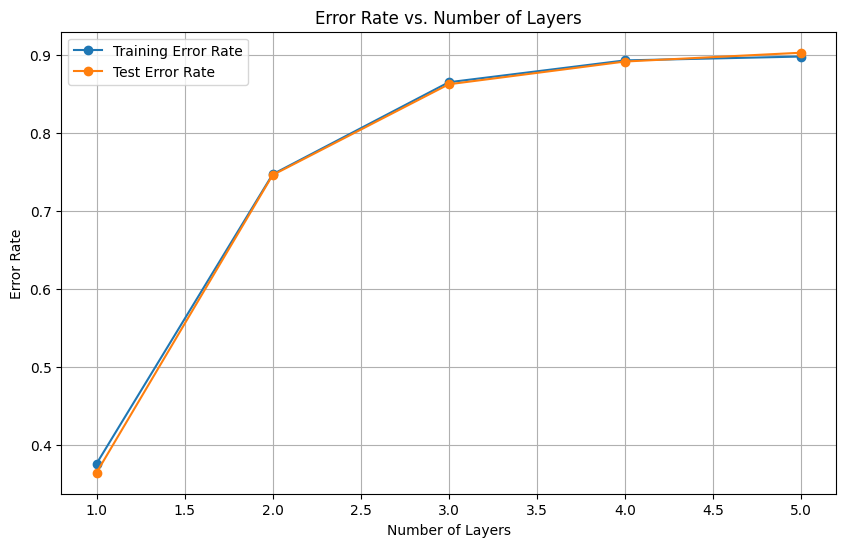

In [24]:
import matplotlib.pyplot as plt

# Load the error rates for each number of layers
num_layers = [1, 2, 3, 4, 5]
train_error_rates = []
test_error_rates = []

for n_layers in num_layers:
    train_error_rate_layer = load_object("layer_error_rate_train_" + str(n_layers) + ".pkl","../results/experiments_mnist")
    test_error_rate_layer = load_object("layer_error_rate_test_" + str(n_layers) + ".pkl","../results/experiments_mnist")
    
# Plotting the error rates
plt.figure(figsize=(10, 6))
plt.plot(num_layers, train_error_rate_layer, label='Training Error Rate', marker='o')
plt.plot(num_layers, test_error_rate_layer, label='Test Error Rate', marker='o')

plt.xlabel('Number of Layers')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. Number of Layers')
plt.legend()
plt.grid(True)
plt.show()


## 1.2. With pretraining

In [25]:
n_samples, n_visible = mnist_train.shape # n_samples, n_features
n_classes = mnist_test_labels.shape[1]

layer_loss = []
layer_error_rate_train = []
layer_error_rate_test = []
for n_layers in [1, 2, 3, 4, 5]:
    hidden_layer_sizes = [200] * n_layers
    dnn = DNN(input_dim=n_visible, output_dim=n_classes, hidden_layer_sizes=hidden_layer_sizes, random_state=42)
    # pretrain
    dnn.train(binary_mnist_train, n_epochs=10, learning_rate=3e-4, batch_size=512)

    loss = dnn.backpropagation(binary_mnist_train, labels=mnist_train_labels, n_epochs=100, learning_rate=3e-4, batch_size=512)
    layer_loss.append(loss)
    
    error_rate_train, _ = dnn.test(test_data=binary_mnist_train, true_labels=mnist_train_labels)
    layer_error_rate_train.append(error_rate_train)  # Assurez-vous que error_rate_train est un scalaire

    error_rate_test, _ = dnn.test(test_data=binary_mnist_test, true_labels=mnist_test_labels)
    layer_error_rate_test.append(error_rate_test)  # Assurez-vous que error_rate_test est un scalaire

    # Save the lists with losses and error rates
    save_object(layer_loss, "pretrain_layer_loss_" + str(n_layers) + ".pkl","../results/experiments_mnist")
    save_object(layer_error_rate_train, "pretrain_layer_error_rate_train_" + str(n_layers) + ".pkl","../results/experiments_mnist")
    save_object(layer_error_rate_test, "pretrain_layer_error_rate_test_" + str(n_layers) + ".pkl","../results/experiments_mnist")


Training:   1%|          | 1/100 [00:01<02:27,  1.49s/epoch]

Epoch 1/100, Cross Entropy: 0.8822924558511611


Training:   2%|▏         | 2/100 [00:03<02:42,  1.66s/epoch]

Epoch 2/100, Cross Entropy: 0.4822286403826286


Training:   3%|▎         | 3/100 [00:04<02:38,  1.63s/epoch]

Epoch 3/100, Cross Entropy: 0.4213324959065379


Training:   4%|▍         | 4/100 [00:06<02:48,  1.76s/epoch]

Epoch 4/100, Cross Entropy: 0.39415222302352576


Training:   5%|▌         | 5/100 [00:08<02:39,  1.67s/epoch]

Epoch 5/100, Cross Entropy: 0.37567072787936767


Training:   6%|▌         | 6/100 [00:10<02:41,  1.72s/epoch]

Epoch 6/100, Cross Entropy: 0.36297513011366034


Training:   7%|▋         | 7/100 [00:11<02:34,  1.66s/epoch]

Epoch 7/100, Cross Entropy: 0.3538604186938092


Training:   8%|▊         | 8/100 [00:13<02:34,  1.68s/epoch]

Epoch 8/100, Cross Entropy: 0.3469725083806894


Training:   9%|▉         | 9/100 [00:14<02:25,  1.60s/epoch]

Epoch 9/100, Cross Entropy: 0.34169784881448334


Training:  10%|█         | 10/100 [00:16<02:28,  1.65s/epoch]

Epoch 10/100, Cross Entropy: 0.3364442366673062


Training:  11%|█         | 11/100 [00:18<02:23,  1.61s/epoch]

Epoch 11/100, Cross Entropy: 0.33334938860908897


Training:  12%|█▏        | 12/100 [00:19<02:27,  1.68s/epoch]

Epoch 12/100, Cross Entropy: 0.32759805717523577


Training:  13%|█▎        | 13/100 [00:21<02:20,  1.62s/epoch]

Epoch 13/100, Cross Entropy: 0.3246502929693495


Training:  14%|█▍        | 14/100 [00:23<02:26,  1.70s/epoch]

Epoch 14/100, Cross Entropy: 0.32355107508844183


Training:  15%|█▌        | 15/100 [00:24<02:20,  1.66s/epoch]

Epoch 15/100, Cross Entropy: 0.31874974877217277


Training:  16%|█▌        | 16/100 [00:26<02:22,  1.69s/epoch]

Epoch 16/100, Cross Entropy: 0.31977831860798533


Training:  17%|█▋        | 17/100 [00:28<02:14,  1.62s/epoch]

Epoch 17/100, Cross Entropy: 0.3161558768549248


Training:  18%|█▊        | 18/100 [00:29<02:16,  1.66s/epoch]

Epoch 18/100, Cross Entropy: 0.31460918800673354


Training:  19%|█▉        | 19/100 [00:31<02:11,  1.62s/epoch]

Epoch 19/100, Cross Entropy: 0.31239840070458313


Training:  20%|██        | 20/100 [00:33<02:12,  1.66s/epoch]

Epoch 20/100, Cross Entropy: 0.3115497123590809


Training:  21%|██        | 21/100 [00:34<02:06,  1.60s/epoch]

Epoch 21/100, Cross Entropy: 0.3101527750521068


Training:  22%|██▏       | 22/100 [00:36<02:08,  1.64s/epoch]

Epoch 22/100, Cross Entropy: 0.31047069020644263


Training:  23%|██▎       | 23/100 [00:37<02:05,  1.63s/epoch]

Epoch 23/100, Cross Entropy: 0.3067740367777446


Training:  24%|██▍       | 24/100 [00:39<02:06,  1.67s/epoch]

Epoch 24/100, Cross Entropy: 0.3057527723232978


Training:  25%|██▌       | 25/100 [00:41<01:59,  1.60s/epoch]

Epoch 25/100, Cross Entropy: 0.30848757584924535


Training:  26%|██▌       | 26/100 [00:42<02:02,  1.65s/epoch]

Epoch 26/100, Cross Entropy: 0.3058954064679527


Training:  27%|██▋       | 27/100 [00:44<01:57,  1.61s/epoch]

Epoch 27/100, Cross Entropy: 0.3056832757273763


Training:  28%|██▊       | 28/100 [00:46<01:58,  1.65s/epoch]

Epoch 28/100, Cross Entropy: 0.30462386045897466


Training:  29%|██▉       | 29/100 [00:47<01:52,  1.58s/epoch]

Epoch 29/100, Cross Entropy: 0.3026432907118642


Training:  30%|███       | 30/100 [00:49<01:55,  1.65s/epoch]

Epoch 30/100, Cross Entropy: 0.3010116648125217


Training:  31%|███       | 31/100 [00:50<01:50,  1.60s/epoch]

Epoch 31/100, Cross Entropy: 0.3023620745402663


Training:  32%|███▏      | 32/100 [00:52<01:50,  1.63s/epoch]

Epoch 32/100, Cross Entropy: 0.3001751549827784


Training:  33%|███▎      | 33/100 [00:54<01:48,  1.62s/epoch]

Epoch 33/100, Cross Entropy: 0.30252822146417013


Training:  34%|███▍      | 34/100 [00:55<01:48,  1.65s/epoch]

Epoch 34/100, Cross Entropy: 0.3000952217247129


Training:  35%|███▌      | 35/100 [00:57<01:43,  1.59s/epoch]

Epoch 35/100, Cross Entropy: 0.3002785727425713


Training:  36%|███▌      | 36/100 [00:59<01:44,  1.64s/epoch]

Epoch 36/100, Cross Entropy: 0.3004655240525224


Training:  37%|███▋      | 37/100 [01:00<01:40,  1.59s/epoch]

Epoch 37/100, Cross Entropy: 0.30057770973276887


Training:  38%|███▊      | 38/100 [01:02<01:42,  1.65s/epoch]

Epoch 38/100, Cross Entropy: 0.3005018593692154


Training:  39%|███▉      | 39/100 [01:03<01:35,  1.57s/epoch]

Epoch 39/100, Cross Entropy: 0.29652889136269067


Training:  40%|████      | 40/100 [01:05<01:37,  1.63s/epoch]

Epoch 40/100, Cross Entropy: 0.29624392833750984


Training:  41%|████      | 41/100 [01:07<01:34,  1.60s/epoch]

Epoch 41/100, Cross Entropy: 0.2964061515041027


Training:  42%|████▏     | 42/100 [01:08<01:36,  1.66s/epoch]

Epoch 42/100, Cross Entropy: 0.2992459371847442


Training:  43%|████▎     | 43/100 [01:10<01:30,  1.60s/epoch]

Epoch 43/100, Cross Entropy: 0.298826087279933


Training:  44%|████▍     | 44/100 [01:12<01:32,  1.65s/epoch]

Epoch 44/100, Cross Entropy: 0.2973574057983591


Training:  45%|████▌     | 45/100 [01:13<01:29,  1.63s/epoch]

Epoch 45/100, Cross Entropy: 0.2987058424772854


Training:  46%|████▌     | 46/100 [01:15<01:29,  1.66s/epoch]

Epoch 46/100, Cross Entropy: 0.2994946757143108


Training:  47%|████▋     | 47/100 [01:16<01:24,  1.60s/epoch]

Epoch 47/100, Cross Entropy: 0.2945276430016356


Training:  48%|████▊     | 48/100 [01:18<01:26,  1.66s/epoch]

Epoch 48/100, Cross Entropy: 0.2962579080712078


Training:  49%|████▉     | 49/100 [01:20<01:22,  1.62s/epoch]

Epoch 49/100, Cross Entropy: 0.29457046110888657


Training:  50%|█████     | 50/100 [01:21<01:22,  1.65s/epoch]

Epoch 50/100, Cross Entropy: 0.2949929544583586


Training:  51%|█████     | 51/100 [01:23<01:18,  1.60s/epoch]

Epoch 51/100, Cross Entropy: 0.29534991414016365


Training:  52%|█████▏    | 52/100 [01:25<01:18,  1.64s/epoch]

Epoch 52/100, Cross Entropy: 0.29594833306475765


Training:  53%|█████▎    | 53/100 [01:26<01:16,  1.63s/epoch]

Epoch 53/100, Cross Entropy: 0.2959415619837123


Training:  54%|█████▍    | 54/100 [01:28<01:16,  1.67s/epoch]

Epoch 54/100, Cross Entropy: 0.29482148161398586


Training:  55%|█████▌    | 55/100 [01:29<01:13,  1.62s/epoch]

Epoch 55/100, Cross Entropy: 0.2951375094095628


Training:  56%|█████▌    | 56/100 [01:31<01:13,  1.68s/epoch]

Epoch 56/100, Cross Entropy: 0.2944318594340357


Training:  57%|█████▋    | 57/100 [01:33<01:11,  1.67s/epoch]

Epoch 57/100, Cross Entropy: 0.29362702607275126


Training:  58%|█████▊    | 58/100 [01:35<01:12,  1.72s/epoch]

Epoch 58/100, Cross Entropy: 0.2932477824255583


Training:  59%|█████▉    | 59/100 [01:36<01:08,  1.67s/epoch]

Epoch 59/100, Cross Entropy: 0.29434959514021813


Training:  60%|██████    | 60/100 [01:38<01:09,  1.73s/epoch]

Epoch 60/100, Cross Entropy: 0.2944157906316507


Training:  61%|██████    | 61/100 [01:40<01:05,  1.67s/epoch]

Epoch 61/100, Cross Entropy: 0.29442088485496243


Training:  62%|██████▏   | 62/100 [01:42<01:04,  1.71s/epoch]

Epoch 62/100, Cross Entropy: 0.29418403971761653


Training:  63%|██████▎   | 63/100 [01:43<01:02,  1.69s/epoch]

Epoch 63/100, Cross Entropy: 0.29349688125975426


Training:  64%|██████▍   | 64/100 [01:45<01:03,  1.76s/epoch]

Epoch 64/100, Cross Entropy: 0.2912174285173613


Training:  65%|██████▌   | 65/100 [01:47<01:00,  1.72s/epoch]

Epoch 65/100, Cross Entropy: 0.2897847564544194


Training:  66%|██████▌   | 66/100 [01:49<01:00,  1.78s/epoch]

Epoch 66/100, Cross Entropy: 0.29576120358923647


Training:  67%|██████▋   | 67/100 [01:50<00:56,  1.72s/epoch]

Epoch 67/100, Cross Entropy: 0.29124789688105895


Training:  68%|██████▊   | 68/100 [01:52<00:56,  1.76s/epoch]

Epoch 68/100, Cross Entropy: 0.2904814610150861


Training:  69%|██████▉   | 69/100 [01:54<00:52,  1.69s/epoch]

Epoch 69/100, Cross Entropy: 0.2922106152791686


Training:  70%|███████   | 70/100 [01:55<00:51,  1.72s/epoch]

Epoch 70/100, Cross Entropy: 0.2919986400983466


Training:  71%|███████   | 71/100 [01:57<00:47,  1.65s/epoch]

Epoch 71/100, Cross Entropy: 0.2946464584361486


Training:  72%|███████▏  | 72/100 [01:59<00:47,  1.68s/epoch]

Epoch 72/100, Cross Entropy: 0.29230640136155606


Training:  73%|███████▎  | 73/100 [02:00<00:44,  1.66s/epoch]

Epoch 73/100, Cross Entropy: 0.2911329204934618


Training:  74%|███████▍  | 74/100 [02:02<00:44,  1.70s/epoch]

Epoch 74/100, Cross Entropy: 0.29184073700051266


Training:  75%|███████▌  | 75/100 [02:04<00:40,  1.63s/epoch]

Epoch 75/100, Cross Entropy: 0.2931864937302488


Training:  76%|███████▌  | 76/100 [02:05<00:40,  1.68s/epoch]

Epoch 76/100, Cross Entropy: 0.2915939652627976


Training:  77%|███████▋  | 77/100 [02:07<00:38,  1.65s/epoch]

Epoch 77/100, Cross Entropy: 0.2909618122733738


Training:  78%|███████▊  | 78/100 [02:09<00:37,  1.69s/epoch]

Epoch 78/100, Cross Entropy: 0.28949371623201403


Training:  79%|███████▉  | 79/100 [02:10<00:34,  1.64s/epoch]

Epoch 79/100, Cross Entropy: 0.2895317642859974


Training:  80%|████████  | 80/100 [02:12<00:33,  1.70s/epoch]

Epoch 80/100, Cross Entropy: 0.29203324064707015


Training:  81%|████████  | 81/100 [02:14<00:32,  1.69s/epoch]

Epoch 81/100, Cross Entropy: 0.2917393276005599


Training:  82%|████████▏ | 82/100 [02:16<00:33,  1.85s/epoch]

Epoch 82/100, Cross Entropy: 0.2910325929292325


Training:  83%|████████▎ | 83/100 [02:18<00:32,  1.89s/epoch]

Epoch 83/100, Cross Entropy: 0.28996340039905827


Training:  84%|████████▍ | 84/100 [02:20<00:29,  1.85s/epoch]

Epoch 84/100, Cross Entropy: 0.29111825039009365


Training:  85%|████████▌ | 85/100 [02:21<00:27,  1.81s/epoch]

Epoch 85/100, Cross Entropy: 0.29310725579615227


Training:  86%|████████▌ | 86/100 [02:23<00:25,  1.85s/epoch]

Epoch 86/100, Cross Entropy: 0.2937684720046576


Training:  87%|████████▋ | 87/100 [02:25<00:23,  1.77s/epoch]

Epoch 87/100, Cross Entropy: 0.29294702825338864


Training:  88%|████████▊ | 88/100 [02:27<00:21,  1.79s/epoch]

Epoch 88/100, Cross Entropy: 0.29135346710579924


Training:  89%|████████▉ | 89/100 [02:28<00:18,  1.67s/epoch]

Epoch 89/100, Cross Entropy: 0.29086449204852366


Training:  90%|█████████ | 90/100 [02:30<00:17,  1.71s/epoch]

Epoch 90/100, Cross Entropy: 0.2899016347032542


Training:  91%|█████████ | 91/100 [02:32<00:15,  1.67s/epoch]

Epoch 91/100, Cross Entropy: 0.2927165045406754


Training:  92%|█████████▏| 92/100 [02:33<00:13,  1.70s/epoch]

Epoch 92/100, Cross Entropy: 0.29150871829843594


Training:  93%|█████████▎| 93/100 [02:35<00:11,  1.64s/epoch]

Epoch 93/100, Cross Entropy: 0.2880730005310366


Training:  94%|█████████▍| 94/100 [02:37<00:10,  1.70s/epoch]

Epoch 94/100, Cross Entropy: 0.2921185953361697


Training:  95%|█████████▌| 95/100 [02:38<00:08,  1.67s/epoch]

Epoch 95/100, Cross Entropy: 0.29011195205934515


Training:  96%|█████████▌| 96/100 [02:40<00:06,  1.70s/epoch]

Epoch 96/100, Cross Entropy: 0.2898988206159489


Training:  97%|█████████▋| 97/100 [02:41<00:04,  1.63s/epoch]

Epoch 97/100, Cross Entropy: 0.29077592424519516


Training:  98%|█████████▊| 98/100 [02:43<00:03,  1.68s/epoch]

Epoch 98/100, Cross Entropy: 0.29092552297527147


Training:  99%|█████████▉| 99/100 [02:45<00:01,  1.64s/epoch]

Epoch 99/100, Cross Entropy: 0.2879154083691909


Training: 100%|██████████| 100/100 [02:47<00:00,  1.67s/epoch]


Epoch 100/100, Cross Entropy: 0.2902250011713362


Training:   1%|          | 1/100 [00:02<03:27,  2.10s/epoch]

Epoch 1/100, Cross Entropy: 0.91891644037694


Training:   2%|▏         | 2/100 [00:04<03:33,  2.18s/epoch]

Epoch 2/100, Cross Entropy: 0.5260391508925941


Training:   3%|▎         | 3/100 [00:06<03:30,  2.17s/epoch]

Epoch 3/100, Cross Entropy: 0.4728689060951347


Training:   4%|▍         | 4/100 [00:08<03:32,  2.22s/epoch]

Epoch 4/100, Cross Entropy: 0.4456813222094031


Training:   5%|▌         | 5/100 [00:10<03:29,  2.21s/epoch]

Epoch 5/100, Cross Entropy: 0.4310075603612554


Training:   6%|▌         | 6/100 [00:13<03:30,  2.24s/epoch]

Epoch 6/100, Cross Entropy: 0.41996461125044615


Training:   7%|▋         | 7/100 [00:15<03:27,  2.24s/epoch]

Epoch 7/100, Cross Entropy: 0.41173527483954847


Training:   8%|▊         | 8/100 [00:17<03:26,  2.24s/epoch]

Epoch 8/100, Cross Entropy: 0.40675452072494067


Training:   9%|▉         | 9/100 [00:19<03:23,  2.23s/epoch]

Epoch 9/100, Cross Entropy: 0.4021070532788294


Training:  10%|█         | 10/100 [00:22<03:20,  2.23s/epoch]

Epoch 10/100, Cross Entropy: 0.39663345509527287


Training:  11%|█         | 11/100 [00:24<03:15,  2.20s/epoch]

Epoch 11/100, Cross Entropy: 0.3964472237518097


Training:  12%|█▏        | 12/100 [00:26<03:14,  2.22s/epoch]

Epoch 12/100, Cross Entropy: 0.39024212515716905


Training:  13%|█▎        | 13/100 [00:28<03:12,  2.21s/epoch]

Epoch 13/100, Cross Entropy: 0.3883586994506366


Training:  14%|█▍        | 14/100 [00:30<03:10,  2.21s/epoch]

Epoch 14/100, Cross Entropy: 0.3888799793025468


Training:  15%|█▌        | 15/100 [00:33<03:06,  2.19s/epoch]

Epoch 15/100, Cross Entropy: 0.38556311060599857


Training:  16%|█▌        | 16/100 [00:35<03:07,  2.23s/epoch]

Epoch 16/100, Cross Entropy: 0.38594008341708874


Training:  17%|█▋        | 17/100 [00:37<03:04,  2.22s/epoch]

Epoch 17/100, Cross Entropy: 0.3833018688749502


Training:  18%|█▊        | 18/100 [00:39<03:02,  2.22s/epoch]

Epoch 18/100, Cross Entropy: 0.3821256249210449


Training:  19%|█▉        | 19/100 [00:42<02:59,  2.21s/epoch]

Epoch 19/100, Cross Entropy: 0.3784810674558563


Training:  20%|██        | 20/100 [00:44<02:57,  2.22s/epoch]

Epoch 20/100, Cross Entropy: 0.38050116336745177


Training:  21%|██        | 21/100 [00:46<02:55,  2.22s/epoch]

Epoch 21/100, Cross Entropy: 0.37878055987281045


Training:  22%|██▏       | 22/100 [00:48<02:54,  2.24s/epoch]

Epoch 22/100, Cross Entropy: 0.37580967528909803


Training:  23%|██▎       | 23/100 [00:50<02:49,  2.21s/epoch]

Epoch 23/100, Cross Entropy: 0.3743602854072418


Training:  24%|██▍       | 24/100 [00:53<02:49,  2.23s/epoch]

Epoch 24/100, Cross Entropy: 0.37544779003907025


Training:  25%|██▌       | 25/100 [00:55<02:45,  2.21s/epoch]

Epoch 25/100, Cross Entropy: 0.3766234244781769


Training:  26%|██▌       | 26/100 [00:57<02:45,  2.24s/epoch]

Epoch 26/100, Cross Entropy: 0.37270014716693906


Training:  27%|██▋       | 27/100 [00:59<02:42,  2.22s/epoch]

Epoch 27/100, Cross Entropy: 0.3736982574267288


Training:  28%|██▊       | 28/100 [01:02<02:40,  2.23s/epoch]

Epoch 28/100, Cross Entropy: 0.37424089773886243


Training:  29%|██▉       | 29/100 [01:04<02:38,  2.23s/epoch]

Epoch 29/100, Cross Entropy: 0.37365062495139323


Training:  30%|███       | 30/100 [01:06<02:35,  2.22s/epoch]

Epoch 30/100, Cross Entropy: 0.37019076225065795


Training:  31%|███       | 31/100 [01:08<02:33,  2.22s/epoch]

Epoch 31/100, Cross Entropy: 0.3692480603707893


Training:  32%|███▏      | 32/100 [01:11<02:31,  2.22s/epoch]

Epoch 32/100, Cross Entropy: 0.36965844992045593


Training:  33%|███▎      | 33/100 [01:13<02:28,  2.22s/epoch]

Epoch 33/100, Cross Entropy: 0.37361400935712985


Training:  34%|███▍      | 34/100 [01:15<02:27,  2.23s/epoch]

Epoch 34/100, Cross Entropy: 0.36859235568492055


Training:  35%|███▌      | 35/100 [01:17<02:24,  2.22s/epoch]

Epoch 35/100, Cross Entropy: 0.3700818511932083


Training:  36%|███▌      | 36/100 [01:19<02:21,  2.21s/epoch]

Epoch 36/100, Cross Entropy: 0.37126136699889284


Training:  37%|███▋      | 37/100 [01:22<02:19,  2.21s/epoch]

Epoch 37/100, Cross Entropy: 0.3719640142685124


Training:  38%|███▊      | 38/100 [01:24<02:17,  2.22s/epoch]

Epoch 38/100, Cross Entropy: 0.36869595998942417


Training:  39%|███▉      | 39/100 [01:26<02:15,  2.23s/epoch]

Epoch 39/100, Cross Entropy: 0.36727964189360973


Training:  40%|████      | 40/100 [01:28<02:13,  2.22s/epoch]

Epoch 40/100, Cross Entropy: 0.36748724173462466


Training:  41%|████      | 41/100 [01:30<02:10,  2.21s/epoch]

Epoch 41/100, Cross Entropy: 0.3660080740842551


Training:  42%|████▏     | 42/100 [01:33<02:07,  2.21s/epoch]

Epoch 42/100, Cross Entropy: 0.36949557339910394


Training:  43%|████▎     | 43/100 [01:35<02:05,  2.20s/epoch]

Epoch 43/100, Cross Entropy: 0.36849926919319065


Training:  44%|████▍     | 44/100 [01:37<02:04,  2.22s/epoch]

Epoch 44/100, Cross Entropy: 0.36785909370216396


Training:  45%|████▌     | 45/100 [01:39<02:01,  2.22s/epoch]

Epoch 45/100, Cross Entropy: 0.36851388129607165


Training:  46%|████▌     | 46/100 [01:42<02:00,  2.23s/epoch]

Epoch 46/100, Cross Entropy: 0.36970252136481535


Training:  47%|████▋     | 47/100 [01:44<01:57,  2.21s/epoch]

Epoch 47/100, Cross Entropy: 0.3674625956358743


Training:  48%|████▊     | 48/100 [01:46<01:57,  2.27s/epoch]

Epoch 48/100, Cross Entropy: 0.3672386837992983


Training:  49%|████▉     | 49/100 [01:48<01:55,  2.26s/epoch]

Epoch 49/100, Cross Entropy: 0.36312713119611245


Training:  50%|█████     | 50/100 [01:51<01:53,  2.27s/epoch]

Epoch 50/100, Cross Entropy: 0.36958607818006917


Training:  51%|█████     | 51/100 [01:53<01:49,  2.24s/epoch]

Epoch 51/100, Cross Entropy: 0.36693424025209403


Training:  52%|█████▏    | 52/100 [01:55<01:46,  2.22s/epoch]

Epoch 52/100, Cross Entropy: 0.36587611931538694


Training:  53%|█████▎    | 53/100 [01:57<01:43,  2.21s/epoch]

Epoch 53/100, Cross Entropy: 0.3680020205730626


Training:  54%|█████▍    | 54/100 [01:59<01:42,  2.22s/epoch]

Epoch 54/100, Cross Entropy: 0.3664651211079033


Training:  55%|█████▌    | 55/100 [02:02<01:40,  2.23s/epoch]

Epoch 55/100, Cross Entropy: 0.36772638526903634


Training:  56%|█████▌    | 56/100 [02:04<01:38,  2.24s/epoch]

Epoch 56/100, Cross Entropy: 0.36638185893191616


Training:  57%|█████▋    | 57/100 [02:06<01:35,  2.23s/epoch]

Epoch 57/100, Cross Entropy: 0.3661273761405079


Training:  58%|█████▊    | 58/100 [02:08<01:34,  2.24s/epoch]

Epoch 58/100, Cross Entropy: 0.36877893340596707


Training:  59%|█████▉    | 59/100 [02:11<01:31,  2.23s/epoch]

Epoch 59/100, Cross Entropy: 0.3643112565225743


Training:  60%|██████    | 60/100 [02:13<01:29,  2.23s/epoch]

Epoch 60/100, Cross Entropy: 0.3654458889624549


Training:  61%|██████    | 61/100 [02:15<01:26,  2.22s/epoch]

Epoch 61/100, Cross Entropy: 0.36630952849338033


Training:  62%|██████▏   | 62/100 [02:17<01:24,  2.22s/epoch]

Epoch 62/100, Cross Entropy: 0.3679855105354375


Training:  63%|██████▎   | 63/100 [02:20<01:22,  2.23s/epoch]

Epoch 63/100, Cross Entropy: 0.3656348262205734


Training:  64%|██████▍   | 64/100 [02:22<01:20,  2.24s/epoch]

Epoch 64/100, Cross Entropy: 0.363507943347726


Training:  65%|██████▌   | 65/100 [02:24<01:20,  2.30s/epoch]

Epoch 65/100, Cross Entropy: 0.3629693319902421


Training:  66%|██████▌   | 66/100 [02:27<01:20,  2.37s/epoch]

Epoch 66/100, Cross Entropy: 0.36483182902799


Training:  67%|██████▋   | 67/100 [02:29<01:16,  2.33s/epoch]

Epoch 67/100, Cross Entropy: 0.3638680850690207


Training:  68%|██████▊   | 68/100 [02:31<01:13,  2.29s/epoch]

Epoch 68/100, Cross Entropy: 0.3644399319422723


Training:  69%|██████▉   | 69/100 [02:33<01:10,  2.28s/epoch]

Epoch 69/100, Cross Entropy: 0.3609369965113242


Training:  70%|███████   | 70/100 [02:36<01:08,  2.28s/epoch]

Epoch 70/100, Cross Entropy: 0.3618463169213014


Training:  71%|███████   | 71/100 [02:38<01:05,  2.26s/epoch]

Epoch 71/100, Cross Entropy: 0.36461757146999546


Training:  72%|███████▏  | 72/100 [02:40<01:03,  2.25s/epoch]

Epoch 72/100, Cross Entropy: 0.36214976807235655


Training:  73%|███████▎  | 73/100 [02:42<01:00,  2.25s/epoch]

Epoch 73/100, Cross Entropy: 0.3633010097034412


Training:  74%|███████▍  | 74/100 [02:45<00:58,  2.25s/epoch]

Epoch 74/100, Cross Entropy: 0.36486995747580236


Training:  75%|███████▌  | 75/100 [02:47<00:55,  2.23s/epoch]

Epoch 75/100, Cross Entropy: 0.3621471955857168


Training:  76%|███████▌  | 76/100 [02:49<00:54,  2.25s/epoch]

Epoch 76/100, Cross Entropy: 0.3630146181096191


Training:  77%|███████▋  | 77/100 [02:51<00:51,  2.23s/epoch]

Epoch 77/100, Cross Entropy: 0.36246635855054693


Training:  78%|███████▊  | 78/100 [02:54<00:49,  2.26s/epoch]

Epoch 78/100, Cross Entropy: 0.3609984836291815


Training:  79%|███████▉  | 79/100 [02:56<00:47,  2.25s/epoch]

Epoch 79/100, Cross Entropy: 0.3614357531962587


Training:  80%|████████  | 80/100 [02:58<00:45,  2.27s/epoch]

Epoch 80/100, Cross Entropy: 0.36406373738494735


Training:  81%|████████  | 81/100 [03:00<00:42,  2.23s/epoch]

Epoch 81/100, Cross Entropy: 0.36396331021876344


Training:  82%|████████▏ | 82/100 [03:03<00:40,  2.25s/epoch]

Epoch 82/100, Cross Entropy: 0.3632010807793259


Training:  83%|████████▎ | 83/100 [03:05<00:37,  2.23s/epoch]

Epoch 83/100, Cross Entropy: 0.3625283936423327


Training:  84%|████████▍ | 84/100 [03:07<00:36,  2.26s/epoch]

Epoch 84/100, Cross Entropy: 0.36073848172520384


Training:  85%|████████▌ | 85/100 [03:09<00:33,  2.25s/epoch]

Epoch 85/100, Cross Entropy: 0.35968942380723284


Training:  86%|████████▌ | 86/100 [03:12<00:31,  2.26s/epoch]

Epoch 86/100, Cross Entropy: 0.36410405472905527


Training:  87%|████████▋ | 87/100 [03:14<00:29,  2.24s/epoch]

Epoch 87/100, Cross Entropy: 0.3646065931131924


Training:  88%|████████▊ | 88/100 [03:16<00:27,  2.26s/epoch]

Epoch 88/100, Cross Entropy: 0.3645409675842194


Training:  89%|████████▉ | 89/100 [03:18<00:24,  2.24s/epoch]

Epoch 89/100, Cross Entropy: 0.36354692053165477


Training:  90%|█████████ | 90/100 [03:21<00:22,  2.26s/epoch]

Epoch 90/100, Cross Entropy: 0.36339556012529606


Training:  91%|█████████ | 91/100 [03:23<00:20,  2.25s/epoch]

Epoch 91/100, Cross Entropy: 0.3635113285840502


Training:  92%|█████████▏| 92/100 [03:25<00:18,  2.25s/epoch]

Epoch 92/100, Cross Entropy: 0.3608249260124497


Training:  93%|█████████▎| 93/100 [03:27<00:15,  2.23s/epoch]

Epoch 93/100, Cross Entropy: 0.36224028232693234


Training:  94%|█████████▍| 94/100 [03:30<00:13,  2.25s/epoch]

Epoch 94/100, Cross Entropy: 0.3583122500399598


Training:  95%|█████████▌| 95/100 [03:32<00:11,  2.22s/epoch]

Epoch 95/100, Cross Entropy: 0.3627008837997138


Training:  96%|█████████▌| 96/100 [03:34<00:08,  2.24s/epoch]

Epoch 96/100, Cross Entropy: 0.3602761091406575


Training:  97%|█████████▋| 97/100 [03:36<00:06,  2.24s/epoch]

Epoch 97/100, Cross Entropy: 0.358554897534129


Training:  98%|█████████▊| 98/100 [03:39<00:04,  2.29s/epoch]

Epoch 98/100, Cross Entropy: 0.3644073468210236


Training:  99%|█████████▉| 99/100 [03:41<00:02,  2.29s/epoch]

Epoch 99/100, Cross Entropy: 0.36510164461377287


Training: 100%|██████████| 100/100 [03:43<00:00,  2.24s/epoch]


Epoch 100/100, Cross Entropy: 0.35749559830007244


Training:   1%|          | 1/100 [00:02<04:34,  2.78s/epoch]

Epoch 1/100, Cross Entropy: 0.9103925539314288


Training:   2%|▏         | 2/100 [00:05<04:39,  2.85s/epoch]

Epoch 2/100, Cross Entropy: 0.553496692663421


Training:   3%|▎         | 3/100 [00:08<04:38,  2.87s/epoch]

Epoch 3/100, Cross Entropy: 0.5045929123115375


Training:   4%|▍         | 4/100 [00:11<04:32,  2.84s/epoch]

Epoch 4/100, Cross Entropy: 0.48614360279736357


Training:   5%|▌         | 5/100 [00:14<04:32,  2.87s/epoch]

Epoch 5/100, Cross Entropy: 0.4697136805899894


Training:   6%|▌         | 6/100 [00:17<04:28,  2.86s/epoch]

Epoch 6/100, Cross Entropy: 0.4638283161532526


Training:   7%|▋         | 7/100 [00:19<04:25,  2.86s/epoch]

Epoch 7/100, Cross Entropy: 0.4556619364953689


Training:   8%|▊         | 8/100 [00:22<04:21,  2.84s/epoch]

Epoch 8/100, Cross Entropy: 0.4506675825040083


Training:   9%|▉         | 9/100 [00:25<04:22,  2.88s/epoch]

Epoch 9/100, Cross Entropy: 0.44946827578872445


Training:  10%|█         | 10/100 [00:28<04:16,  2.85s/epoch]

Epoch 10/100, Cross Entropy: 0.44481605605807917


Training:  11%|█         | 11/100 [00:31<04:12,  2.84s/epoch]

Epoch 11/100, Cross Entropy: 0.4407651857768429


Training:  12%|█▏        | 12/100 [00:34<04:10,  2.85s/epoch]

Epoch 12/100, Cross Entropy: 0.4427426057768261


Training:  13%|█▎        | 13/100 [00:37<04:08,  2.86s/epoch]

Epoch 13/100, Cross Entropy: 0.4386090431883288


Training:  14%|█▍        | 14/100 [00:39<04:04,  2.85s/epoch]

Epoch 14/100, Cross Entropy: 0.4374080031477272


Training:  15%|█▌        | 15/100 [00:42<04:01,  2.84s/epoch]

Epoch 15/100, Cross Entropy: 0.43613545093300027


Training:  16%|█▌        | 16/100 [00:45<04:01,  2.87s/epoch]

Epoch 16/100, Cross Entropy: 0.43513191419048797


Training:  17%|█▋        | 17/100 [00:48<03:58,  2.87s/epoch]

Epoch 17/100, Cross Entropy: 0.434109983374803


Training:  18%|█▊        | 18/100 [00:51<03:54,  2.86s/epoch]

Epoch 18/100, Cross Entropy: 0.43318913793023195


Training:  19%|█▉        | 19/100 [00:54<03:51,  2.86s/epoch]

Epoch 19/100, Cross Entropy: 0.43311215794040636


Training:  20%|██        | 20/100 [00:57<03:47,  2.85s/epoch]

Epoch 20/100, Cross Entropy: 0.43079309592124054


Training:  21%|██        | 21/100 [00:59<03:45,  2.85s/epoch]

Epoch 21/100, Cross Entropy: 0.43247102219664924


Training:  22%|██▏       | 22/100 [01:02<03:40,  2.83s/epoch]

Epoch 22/100, Cross Entropy: 0.429323343601301


Training:  23%|██▎       | 23/100 [01:05<03:39,  2.86s/epoch]

Epoch 23/100, Cross Entropy: 0.429797982046946


Training:  24%|██▍       | 24/100 [01:08<03:37,  2.86s/epoch]

Epoch 24/100, Cross Entropy: 0.4285803077342242


Training:  25%|██▌       | 25/100 [01:11<03:34,  2.86s/epoch]

Epoch 25/100, Cross Entropy: 0.4298944746685028


Training:  26%|██▌       | 26/100 [01:14<03:30,  2.85s/epoch]

Epoch 26/100, Cross Entropy: 0.42625352986777726


Training:  27%|██▋       | 27/100 [01:17<03:29,  2.88s/epoch]

Epoch 27/100, Cross Entropy: 0.43069043138861


Training:  28%|██▊       | 28/100 [01:19<03:26,  2.86s/epoch]

Epoch 28/100, Cross Entropy: 0.42803916998066704


Training:  29%|██▉       | 29/100 [01:22<03:22,  2.85s/epoch]

Epoch 29/100, Cross Entropy: 0.42704847970600307


Training:  30%|███       | 30/100 [01:25<03:19,  2.86s/epoch]

Epoch 30/100, Cross Entropy: 0.4220288716016199


Training:  31%|███       | 31/100 [01:28<03:17,  2.86s/epoch]

Epoch 31/100, Cross Entropy: 0.4263881615215681


Training:  32%|███▏      | 32/100 [01:31<03:13,  2.85s/epoch]

Epoch 32/100, Cross Entropy: 0.422297210394391


Training:  33%|███▎      | 33/100 [01:34<03:10,  2.85s/epoch]

Epoch 33/100, Cross Entropy: 0.42730837708751995


Training:  34%|███▍      | 34/100 [01:37<03:09,  2.87s/epoch]

Epoch 34/100, Cross Entropy: 0.4245694752940758


Training:  35%|███▌      | 35/100 [01:40<03:07,  2.89s/epoch]

Epoch 35/100, Cross Entropy: 0.42630792011848806


Training:  36%|███▌      | 36/100 [01:42<03:03,  2.86s/epoch]

Epoch 36/100, Cross Entropy: 0.42644930892595


Training:  37%|███▋      | 37/100 [01:45<03:02,  2.90s/epoch]

Epoch 37/100, Cross Entropy: 0.42639332148104325


Training:  38%|███▊      | 38/100 [01:48<02:58,  2.88s/epoch]

Epoch 38/100, Cross Entropy: 0.42024398742188346


Training:  39%|███▉      | 39/100 [01:51<02:54,  2.85s/epoch]

Epoch 39/100, Cross Entropy: 0.4242538698060237


Training:  40%|████      | 40/100 [01:54<02:52,  2.88s/epoch]

Epoch 40/100, Cross Entropy: 0.4237615641818566


Training:  41%|████      | 41/100 [01:57<02:49,  2.87s/epoch]

Epoch 41/100, Cross Entropy: 0.4216100259027497


Training:  42%|████▏     | 42/100 [02:00<02:46,  2.86s/epoch]

Epoch 42/100, Cross Entropy: 0.4239832413934602


Training:  43%|████▎     | 43/100 [02:02<02:43,  2.86s/epoch]

Epoch 43/100, Cross Entropy: 0.41791357935065193


Training:  44%|████▍     | 44/100 [02:05<02:40,  2.87s/epoch]

Epoch 44/100, Cross Entropy: 0.42465683281657385


Training:  45%|████▌     | 45/100 [02:08<02:39,  2.89s/epoch]

Epoch 45/100, Cross Entropy: 0.4222587628459199


Training:  46%|████▌     | 46/100 [02:11<02:35,  2.87s/epoch]

Epoch 46/100, Cross Entropy: 0.42354363830683467


Training:  47%|████▋     | 47/100 [02:14<02:31,  2.87s/epoch]

Epoch 47/100, Cross Entropy: 0.4225242627980955


Training:  48%|████▊     | 48/100 [02:17<02:28,  2.87s/epoch]

Epoch 48/100, Cross Entropy: 0.4237381896957885


Training:  49%|████▉     | 49/100 [02:20<02:26,  2.87s/epoch]

Epoch 49/100, Cross Entropy: 0.4198196785536618


Training:  50%|█████     | 50/100 [02:22<02:22,  2.85s/epoch]

Epoch 50/100, Cross Entropy: 0.42393239538693545


Training:  51%|█████     | 51/100 [02:25<02:20,  2.86s/epoch]

Epoch 51/100, Cross Entropy: 0.4227403052100723


Training:  52%|█████▏    | 52/100 [02:28<02:16,  2.85s/epoch]

Epoch 52/100, Cross Entropy: 0.4213261766811665


Training:  53%|█████▎    | 53/100 [02:31<02:12,  2.82s/epoch]

Epoch 53/100, Cross Entropy: 0.423709061438871


Training:  54%|█████▍    | 54/100 [02:34<02:13,  2.90s/epoch]

Epoch 54/100, Cross Entropy: 0.42210617065335176


Training:  55%|█████▌    | 55/100 [02:37<02:15,  3.01s/epoch]

Epoch 55/100, Cross Entropy: 0.4235442649410678


Training:  56%|█████▌    | 56/100 [02:40<02:12,  3.00s/epoch]

Epoch 56/100, Cross Entropy: 0.420770866981396


Training:  57%|█████▋    | 57/100 [02:43<02:07,  2.97s/epoch]

Epoch 57/100, Cross Entropy: 0.42209345504612056


Training:  58%|█████▊    | 58/100 [02:46<02:03,  2.94s/epoch]

Epoch 58/100, Cross Entropy: 0.42521421256912095


Training:  59%|█████▉    | 59/100 [02:49<01:58,  2.90s/epoch]

Epoch 59/100, Cross Entropy: 0.4187063369333832


Training:  60%|██████    | 60/100 [02:52<01:54,  2.86s/epoch]

Epoch 60/100, Cross Entropy: 0.4196020607375815


Training:  61%|██████    | 61/100 [02:55<01:52,  2.88s/epoch]

Epoch 61/100, Cross Entropy: 0.42088957186734205


Training:  62%|██████▏   | 62/100 [02:57<01:48,  2.85s/epoch]

Epoch 62/100, Cross Entropy: 0.42620815100237924


Training:  63%|██████▎   | 63/100 [03:00<01:44,  2.83s/epoch]

Epoch 63/100, Cross Entropy: 0.4213346860856629


Training:  64%|██████▍   | 64/100 [03:03<01:41,  2.81s/epoch]

Epoch 64/100, Cross Entropy: 0.4211381154578037


Training:  65%|██████▌   | 65/100 [03:06<01:39,  2.83s/epoch]

Epoch 65/100, Cross Entropy: 0.41785799200091023


Training:  66%|██████▌   | 66/100 [03:09<01:36,  2.83s/epoch]

Epoch 66/100, Cross Entropy: 0.4234419491689091


Training:  67%|██████▋   | 67/100 [03:11<01:32,  2.81s/epoch]

Epoch 67/100, Cross Entropy: 0.41695307840219564


Training:  68%|██████▊   | 68/100 [03:14<01:31,  2.86s/epoch]

Epoch 68/100, Cross Entropy: 0.4207881285123378


Training:  69%|██████▉   | 69/100 [03:17<01:29,  2.89s/epoch]

Epoch 69/100, Cross Entropy: 0.41950026747231395


Training:  70%|███████   | 70/100 [03:20<01:25,  2.86s/epoch]

Epoch 70/100, Cross Entropy: 0.42154429425566436


Training:  71%|███████   | 71/100 [03:23<01:23,  2.87s/epoch]

Epoch 71/100, Cross Entropy: 0.42307983199302696


Training:  72%|███████▏  | 72/100 [03:26<01:19,  2.86s/epoch]

Epoch 72/100, Cross Entropy: 0.4198031953738709


Training:  73%|███████▎  | 73/100 [03:29<01:16,  2.85s/epoch]

Epoch 73/100, Cross Entropy: 0.42175709034901965


Training:  74%|███████▍  | 74/100 [03:31<01:13,  2.82s/epoch]

Epoch 74/100, Cross Entropy: 0.41991170725089333


Training:  75%|███████▌  | 75/100 [03:34<01:10,  2.83s/epoch]

Epoch 75/100, Cross Entropy: 0.42073299081403503


Training:  76%|███████▌  | 76/100 [03:37<01:07,  2.82s/epoch]

Epoch 76/100, Cross Entropy: 0.41833646650694045


Training:  77%|███████▋  | 77/100 [03:40<01:04,  2.82s/epoch]

Epoch 77/100, Cross Entropy: 0.42069601354211744


Training:  78%|███████▊  | 78/100 [03:43<01:01,  2.80s/epoch]

Epoch 78/100, Cross Entropy: 0.4180338761182502


Training:  79%|███████▉  | 79/100 [03:46<01:00,  2.88s/epoch]

Epoch 79/100, Cross Entropy: 0.4201799085395288


Training:  80%|████████  | 80/100 [03:48<00:57,  2.87s/epoch]

Epoch 80/100, Cross Entropy: 0.4187865596749205


Training:  81%|████████  | 81/100 [03:51<00:54,  2.86s/epoch]

Epoch 81/100, Cross Entropy: 0.422394761730867


Training:  82%|████████▏ | 82/100 [03:54<00:51,  2.85s/epoch]

Epoch 82/100, Cross Entropy: 0.4175936969346614


Training:  83%|████████▎ | 83/100 [03:57<00:48,  2.87s/epoch]

Epoch 83/100, Cross Entropy: 0.42017078047841294


Training:  84%|████████▍ | 84/100 [04:00<00:45,  2.84s/epoch]

Epoch 84/100, Cross Entropy: 0.42132623887089055


Training:  85%|████████▌ | 85/100 [04:03<00:42,  2.83s/epoch]

Epoch 85/100, Cross Entropy: 0.42053900726608057


Training:  86%|████████▌ | 86/100 [04:06<00:39,  2.86s/epoch]

Epoch 86/100, Cross Entropy: 0.42106388906811953


Training:  87%|████████▋ | 87/100 [04:08<00:37,  2.88s/epoch]

Epoch 87/100, Cross Entropy: 0.4223132175328457


Training:  88%|████████▊ | 88/100 [04:11<00:34,  2.85s/epoch]

Epoch 88/100, Cross Entropy: 0.42475803391158123


Training:  89%|████████▉ | 89/100 [04:14<00:31,  2.86s/epoch]

Epoch 89/100, Cross Entropy: 0.4223699343320378


Training:  90%|█████████ | 90/100 [04:17<00:28,  2.86s/epoch]

Epoch 90/100, Cross Entropy: 0.42075227836338724


Training:  91%|█████████ | 91/100 [04:20<00:25,  2.87s/epoch]

Epoch 91/100, Cross Entropy: 0.42281587388759434


Training:  92%|█████████▏| 92/100 [04:23<00:22,  2.83s/epoch]

Epoch 92/100, Cross Entropy: 0.4212163192114722


Training:  93%|█████████▎| 93/100 [04:26<00:19,  2.83s/epoch]

Epoch 93/100, Cross Entropy: 0.42010817006524326


Training:  94%|█████████▍| 94/100 [04:28<00:16,  2.82s/epoch]

Epoch 94/100, Cross Entropy: 0.41837174752815637


Training:  95%|█████████▌| 95/100 [04:31<00:14,  2.84s/epoch]

Epoch 95/100, Cross Entropy: 0.42129399823170605


Training:  96%|█████████▌| 96/100 [04:34<00:11,  2.81s/epoch]

Epoch 96/100, Cross Entropy: 0.4188369227555144


Training:  97%|█████████▋| 97/100 [04:37<00:08,  2.85s/epoch]

Epoch 97/100, Cross Entropy: 0.4190583393208011


Training:  98%|█████████▊| 98/100 [04:40<00:05,  2.83s/epoch]

Epoch 98/100, Cross Entropy: 0.42274176478424597


Training:  99%|█████████▉| 99/100 [04:42<00:02,  2.83s/epoch]

Epoch 99/100, Cross Entropy: 0.41883222619700233


Training: 100%|██████████| 100/100 [04:45<00:00,  2.86s/epoch]


Epoch 100/100, Cross Entropy: 0.4187561928844594


Training:   1%|          | 1/100 [00:03<05:42,  3.46s/epoch]

Epoch 1/100, Cross Entropy: 0.959610047163171


Training:   2%|▏         | 2/100 [00:07<05:53,  3.61s/epoch]

Epoch 2/100, Cross Entropy: 0.6065029233455974


Training:   3%|▎         | 3/100 [00:10<05:50,  3.61s/epoch]

Epoch 3/100, Cross Entropy: 0.5588397184514361


Training:   4%|▍         | 4/100 [00:14<05:49,  3.64s/epoch]

Epoch 4/100, Cross Entropy: 0.5403021229012229


Training:   5%|▌         | 5/100 [00:18<05:45,  3.64s/epoch]

Epoch 5/100, Cross Entropy: 0.5262714027606533


Training:   6%|▌         | 6/100 [00:21<05:45,  3.67s/epoch]

Epoch 6/100, Cross Entropy: 0.516937230584299


Training:   7%|▋         | 7/100 [00:25<05:41,  3.67s/epoch]

Epoch 7/100, Cross Entropy: 0.5116050834439111


Training:   8%|▊         | 8/100 [00:29<05:36,  3.65s/epoch]

Epoch 8/100, Cross Entropy: 0.5087527139147677


Training:   9%|▉         | 9/100 [00:32<05:29,  3.62s/epoch]

Epoch 9/100, Cross Entropy: 0.5039782208078321


Training:  10%|█         | 10/100 [00:36<05:26,  3.63s/epoch]

Epoch 10/100, Cross Entropy: 0.4987189272005161


Training:  11%|█         | 11/100 [00:39<05:22,  3.63s/epoch]

Epoch 11/100, Cross Entropy: 0.5002318157887656


Training:  12%|█▏        | 12/100 [00:43<05:20,  3.64s/epoch]

Epoch 12/100, Cross Entropy: 0.4994952225611764


Training:  13%|█▎        | 13/100 [00:47<05:11,  3.58s/epoch]

Epoch 13/100, Cross Entropy: 0.4992766887295768


Training:  14%|█▍        | 14/100 [00:50<05:04,  3.54s/epoch]

Epoch 14/100, Cross Entropy: 0.49531525548926075


Training:  15%|█▌        | 15/100 [00:54<05:00,  3.53s/epoch]

Epoch 15/100, Cross Entropy: 0.4913835572169569


Training:  16%|█▌        | 16/100 [00:57<04:53,  3.50s/epoch]

Epoch 16/100, Cross Entropy: 0.4953460407054456


Training:  17%|█▋        | 17/100 [01:00<04:50,  3.50s/epoch]

Epoch 17/100, Cross Entropy: 0.49331705624344224


Training:  18%|█▊        | 18/100 [01:04<04:45,  3.48s/epoch]

Epoch 18/100, Cross Entropy: 0.4884577983250903


Training:  19%|█▉        | 19/100 [01:07<04:41,  3.48s/epoch]

Epoch 19/100, Cross Entropy: 0.4891442287420327


Training:  20%|██        | 20/100 [01:11<04:36,  3.46s/epoch]

Epoch 20/100, Cross Entropy: 0.49047305092286425


Training:  21%|██        | 21/100 [01:14<04:32,  3.45s/epoch]

Epoch 21/100, Cross Entropy: 0.49204884139697447


Training:  22%|██▏       | 22/100 [01:18<04:28,  3.44s/epoch]

Epoch 22/100, Cross Entropy: 0.4890199336821385


Training:  23%|██▎       | 23/100 [01:21<04:23,  3.42s/epoch]

Epoch 23/100, Cross Entropy: 0.4857046509202483


Training:  24%|██▍       | 24/100 [01:24<04:20,  3.43s/epoch]

Epoch 24/100, Cross Entropy: 0.48777403202580183


Training:  25%|██▌       | 25/100 [01:28<04:17,  3.44s/epoch]

Epoch 25/100, Cross Entropy: 0.4898741371171063


Training:  26%|██▌       | 26/100 [01:31<04:17,  3.48s/epoch]

Epoch 26/100, Cross Entropy: 0.48426882237882474


Training:  27%|██▋       | 27/100 [01:35<04:13,  3.47s/epoch]

Epoch 27/100, Cross Entropy: 0.48421872141771116


Training:  28%|██▊       | 28/100 [01:38<04:09,  3.47s/epoch]

Epoch 28/100, Cross Entropy: 0.48794664488568623


Training:  29%|██▉       | 29/100 [01:42<04:04,  3.45s/epoch]

Epoch 29/100, Cross Entropy: 0.48631736327221187


Training:  30%|███       | 30/100 [01:45<04:02,  3.46s/epoch]

Epoch 30/100, Cross Entropy: 0.48029477907974943


Training:  31%|███       | 31/100 [01:49<03:59,  3.47s/epoch]

Epoch 31/100, Cross Entropy: 0.48564569122324486


Training:  32%|███▏      | 32/100 [01:52<03:55,  3.46s/epoch]

Epoch 32/100, Cross Entropy: 0.4814408657799987


Training:  33%|███▎      | 33/100 [01:56<03:52,  3.47s/epoch]

Epoch 33/100, Cross Entropy: 0.4851456367112641


Training:  34%|███▍      | 34/100 [01:59<03:49,  3.47s/epoch]

Epoch 34/100, Cross Entropy: 0.48176740866346995


Training:  35%|███▌      | 35/100 [02:03<03:45,  3.47s/epoch]

Epoch 35/100, Cross Entropy: 0.4854544322304507


Training:  36%|███▌      | 36/100 [02:06<03:41,  3.47s/epoch]

Epoch 36/100, Cross Entropy: 0.48389059180822824


Training:  37%|███▋      | 37/100 [02:10<03:38,  3.47s/epoch]

Epoch 37/100, Cross Entropy: 0.4867879806942211


Training:  38%|███▊      | 38/100 [02:13<03:34,  3.47s/epoch]

Epoch 38/100, Cross Entropy: 0.47896805577063684


Training:  39%|███▉      | 39/100 [02:17<03:38,  3.58s/epoch]

Epoch 39/100, Cross Entropy: 0.48117526492552926


Training:  40%|████      | 40/100 [02:21<03:47,  3.80s/epoch]

Epoch 40/100, Cross Entropy: 0.4819969948453431


Training:  41%|████      | 41/100 [02:25<03:47,  3.85s/epoch]

Epoch 41/100, Cross Entropy: 0.4800670619873794


Training:  42%|████▏     | 42/100 [02:29<03:42,  3.84s/epoch]

Epoch 42/100, Cross Entropy: 0.4826522468474188


Training:  43%|████▎     | 43/100 [02:33<03:36,  3.79s/epoch]

Epoch 43/100, Cross Entropy: 0.47987293441442935


Training:  44%|████▍     | 44/100 [02:36<03:28,  3.72s/epoch]

Epoch 44/100, Cross Entropy: 0.48054005883027495


Training:  45%|████▌     | 45/100 [02:40<03:23,  3.69s/epoch]

Epoch 45/100, Cross Entropy: 0.4803158280447898


Training:  46%|████▌     | 46/100 [02:43<03:16,  3.64s/epoch]

Epoch 46/100, Cross Entropy: 0.48241995456729386


Training:  47%|████▋     | 47/100 [02:47<03:12,  3.63s/epoch]

Epoch 47/100, Cross Entropy: 0.4784265091443303


Training:  48%|████▊     | 48/100 [02:51<03:09,  3.64s/epoch]

Epoch 48/100, Cross Entropy: 0.4846152916491657


Training:  49%|████▉     | 49/100 [02:54<03:04,  3.61s/epoch]

Epoch 49/100, Cross Entropy: 0.4798969007365138


Training:  50%|█████     | 50/100 [02:58<03:01,  3.62s/epoch]

Epoch 50/100, Cross Entropy: 0.484075523897227


Training:  51%|█████     | 51/100 [03:01<02:56,  3.60s/epoch]

Epoch 51/100, Cross Entropy: 0.4820496773450856


Training:  52%|█████▏    | 52/100 [03:05<02:52,  3.59s/epoch]

Epoch 52/100, Cross Entropy: 0.4803666384949079


Training:  53%|█████▎    | 53/100 [03:09<02:49,  3.60s/epoch]

Epoch 53/100, Cross Entropy: 0.48279813070706495


Training:  54%|█████▍    | 54/100 [03:12<02:45,  3.60s/epoch]

Epoch 54/100, Cross Entropy: 0.48370455667840373


Training:  55%|█████▌    | 55/100 [03:16<02:45,  3.68s/epoch]

Epoch 55/100, Cross Entropy: 0.48152979567717796


Training:  56%|█████▌    | 56/100 [03:20<02:43,  3.73s/epoch]

Epoch 56/100, Cross Entropy: 0.4837792113294718


Training:  57%|█████▋    | 57/100 [03:24<02:40,  3.72s/epoch]

Epoch 57/100, Cross Entropy: 0.4812805602326807


Training:  58%|█████▊    | 58/100 [03:28<02:46,  3.97s/epoch]

Epoch 58/100, Cross Entropy: 0.4829141108103392


Training:  59%|█████▉    | 59/100 [03:32<02:44,  4.01s/epoch]

Epoch 59/100, Cross Entropy: 0.4807170942552987


Training:  60%|██████    | 60/100 [03:37<02:43,  4.09s/epoch]

Epoch 60/100, Cross Entropy: 0.47843920894787284


Training:  61%|██████    | 61/100 [03:41<02:41,  4.15s/epoch]

Epoch 61/100, Cross Entropy: 0.48012319810110876


Training:  62%|██████▏   | 62/100 [03:45<02:37,  4.14s/epoch]

Epoch 62/100, Cross Entropy: 0.4846163569614803


Training:  63%|██████▎   | 63/100 [03:49<02:34,  4.18s/epoch]

Epoch 63/100, Cross Entropy: 0.48124805307746626


Training:  64%|██████▍   | 64/100 [03:54<02:31,  4.22s/epoch]

Epoch 64/100, Cross Entropy: 0.48065973896580727


Training:  65%|██████▌   | 65/100 [03:58<02:30,  4.30s/epoch]

Epoch 65/100, Cross Entropy: 0.4774337076782613


Training:  66%|██████▌   | 66/100 [04:02<02:25,  4.28s/epoch]

Epoch 66/100, Cross Entropy: 0.48391048679723736


Training:  67%|██████▋   | 67/100 [04:06<02:16,  4.13s/epoch]

Epoch 67/100, Cross Entropy: 0.4798116376509206


Training:  68%|██████▊   | 68/100 [04:10<02:10,  4.06s/epoch]

Epoch 68/100, Cross Entropy: 0.4809568433206045


Training:  69%|██████▉   | 69/100 [04:14<02:08,  4.13s/epoch]

Epoch 69/100, Cross Entropy: 0.4783462271890672


Training:  70%|███████   | 70/100 [04:19<02:07,  4.26s/epoch]

Epoch 70/100, Cross Entropy: 0.48326434825483383


Training:  71%|███████   | 71/100 [04:23<02:03,  4.27s/epoch]

Epoch 71/100, Cross Entropy: 0.481601919101726


Training:  72%|███████▏  | 72/100 [04:27<01:55,  4.12s/epoch]

Epoch 72/100, Cross Entropy: 0.4784182293797472


Training:  73%|███████▎  | 73/100 [04:31<01:49,  4.04s/epoch]

Epoch 73/100, Cross Entropy: 0.481548689340093


Training:  74%|███████▍  | 74/100 [04:35<01:44,  4.01s/epoch]

Epoch 74/100, Cross Entropy: 0.48215730073810636


Training:  75%|███████▌  | 75/100 [04:38<01:38,  3.94s/epoch]

Epoch 75/100, Cross Entropy: 0.47834056487979626


Training:  76%|███████▌  | 76/100 [04:42<01:32,  3.87s/epoch]

Epoch 76/100, Cross Entropy: 0.4807520196515419


Training:  77%|███████▋  | 77/100 [04:46<01:28,  3.83s/epoch]

Epoch 77/100, Cross Entropy: 0.4813017589847865


Training:  78%|███████▊  | 78/100 [04:50<01:24,  3.84s/epoch]

Epoch 78/100, Cross Entropy: 0.47615156902862626


Training:  79%|███████▉  | 79/100 [04:54<01:22,  3.91s/epoch]

Epoch 79/100, Cross Entropy: 0.47961247712768196


Training:  80%|████████  | 80/100 [04:58<01:19,  3.98s/epoch]

Epoch 80/100, Cross Entropy: 0.4812425231558119


Training:  81%|████████  | 81/100 [05:02<01:16,  4.05s/epoch]

Epoch 81/100, Cross Entropy: 0.4792583745094237


Training:  82%|████████▏ | 82/100 [05:06<01:11,  3.97s/epoch]

Epoch 82/100, Cross Entropy: 0.4796609365653008


Training:  83%|████████▎ | 83/100 [05:10<01:05,  3.87s/epoch]

Epoch 83/100, Cross Entropy: 0.4786352653371954


Training:  84%|████████▍ | 84/100 [05:13<01:01,  3.83s/epoch]

Epoch 84/100, Cross Entropy: 0.480766065984415


Training:  85%|████████▌ | 85/100 [05:17<00:57,  3.81s/epoch]

Epoch 85/100, Cross Entropy: 0.48191608308609624


Training:  86%|████████▌ | 86/100 [05:21<00:54,  3.91s/epoch]

Epoch 86/100, Cross Entropy: 0.48169174471984183


Training:  87%|████████▋ | 87/100 [05:25<00:50,  3.87s/epoch]

Epoch 87/100, Cross Entropy: 0.4818233934501978


Training:  88%|████████▊ | 88/100 [05:29<00:46,  3.90s/epoch]

Epoch 88/100, Cross Entropy: 0.48139137891198536


Training:  89%|████████▉ | 89/100 [05:33<00:43,  3.92s/epoch]

Epoch 89/100, Cross Entropy: 0.4819330467698409


Training:  90%|█████████ | 90/100 [05:36<00:37,  3.78s/epoch]

Epoch 90/100, Cross Entropy: 0.47913342772177137


Training:  91%|█████████ | 91/100 [05:40<00:33,  3.68s/epoch]

Epoch 91/100, Cross Entropy: 0.48210602791349755


Training:  92%|█████████▏| 92/100 [05:43<00:28,  3.59s/epoch]

Epoch 92/100, Cross Entropy: 0.47908915538146535


Training:  93%|█████████▎| 93/100 [05:47<00:24,  3.56s/epoch]

Epoch 93/100, Cross Entropy: 0.4817813788122515


Training:  94%|█████████▍| 94/100 [05:50<00:21,  3.53s/epoch]

Epoch 94/100, Cross Entropy: 0.4780053726113865


Training:  95%|█████████▌| 95/100 [05:54<00:17,  3.50s/epoch]

Epoch 95/100, Cross Entropy: 0.4806574549503834


Training:  96%|█████████▌| 96/100 [05:57<00:14,  3.50s/epoch]

Epoch 96/100, Cross Entropy: 0.4799234864595347


Training:  97%|█████████▋| 97/100 [06:01<00:10,  3.48s/epoch]

Epoch 97/100, Cross Entropy: 0.47621232086781273


Training:  98%|█████████▊| 98/100 [06:04<00:06,  3.49s/epoch]

Epoch 98/100, Cross Entropy: 0.48369239697230004


Training:  99%|█████████▉| 99/100 [06:07<00:03,  3.45s/epoch]

Epoch 99/100, Cross Entropy: 0.4798033523245098


Training: 100%|██████████| 100/100 [06:11<00:00,  3.71s/epoch]


Epoch 100/100, Cross Entropy: 0.47798978452603585


Training:   1%|          | 1/100 [00:04<06:39,  4.03s/epoch]

Epoch 1/100, Cross Entropy: 0.9885418120818469


Training:   2%|▏         | 2/100 [00:08<06:40,  4.08s/epoch]

Epoch 2/100, Cross Entropy: 0.643245790621379


Training:   3%|▎         | 3/100 [00:12<06:34,  4.07s/epoch]

Epoch 3/100, Cross Entropy: 0.599140560544538


Training:   4%|▍         | 4/100 [00:16<06:27,  4.04s/epoch]

Epoch 4/100, Cross Entropy: 0.5830415334394805


Training:   5%|▌         | 5/100 [00:20<06:25,  4.06s/epoch]

Epoch 5/100, Cross Entropy: 0.5692789265909622


Training:   6%|▌         | 6/100 [00:24<06:19,  4.04s/epoch]

Epoch 6/100, Cross Entropy: 0.5620506137002292


Training:   7%|▋         | 7/100 [00:28<06:18,  4.07s/epoch]

Epoch 7/100, Cross Entropy: 0.5593240379351869


Training:   8%|▊         | 8/100 [00:32<06:20,  4.13s/epoch]

Epoch 8/100, Cross Entropy: 0.5567645215131285


Training:   9%|▉         | 9/100 [00:36<06:20,  4.18s/epoch]

Epoch 9/100, Cross Entropy: 0.5510106060406966


Training:  10%|█         | 10/100 [00:41<06:17,  4.20s/epoch]

Epoch 10/100, Cross Entropy: 0.5447209009718373


Training:  11%|█         | 11/100 [00:45<06:14,  4.21s/epoch]

Epoch 11/100, Cross Entropy: 0.5454010993528183


Training:  12%|█▏        | 12/100 [00:49<06:09,  4.20s/epoch]

Epoch 12/100, Cross Entropy: 0.5517742614842469


Training:  13%|█▎        | 13/100 [00:53<06:05,  4.20s/epoch]

Epoch 13/100, Cross Entropy: 0.5475679708880725


Training:  14%|█▍        | 14/100 [00:57<05:59,  4.18s/epoch]

Epoch 14/100, Cross Entropy: 0.545570908217249


Training:  15%|█▌        | 15/100 [01:02<05:57,  4.21s/epoch]

Epoch 15/100, Cross Entropy: 0.5401618805826288


Training:  16%|█▌        | 16/100 [01:06<05:51,  4.19s/epoch]

Epoch 16/100, Cross Entropy: 0.545231780075838


Training:  17%|█▋        | 17/100 [01:10<05:46,  4.18s/epoch]

Epoch 17/100, Cross Entropy: 0.5437883555368842


Training:  18%|█▊        | 18/100 [01:14<05:44,  4.20s/epoch]

Epoch 18/100, Cross Entropy: 0.5392099982077467


Training:  19%|█▉        | 19/100 [01:18<05:40,  4.21s/epoch]

Epoch 19/100, Cross Entropy: 0.538615033243262


Training:  20%|██        | 20/100 [01:23<05:36,  4.21s/epoch]

Epoch 20/100, Cross Entropy: 0.5404945144018503


Training:  21%|██        | 21/100 [01:27<05:32,  4.20s/epoch]

Epoch 21/100, Cross Entropy: 0.5353518468543613


Training:  22%|██▏       | 22/100 [01:31<05:28,  4.22s/epoch]

Epoch 22/100, Cross Entropy: 0.5382382835432571


Training:  23%|██▎       | 23/100 [01:35<05:22,  4.19s/epoch]

Epoch 23/100, Cross Entropy: 0.5372954186765401


Training:  24%|██▍       | 24/100 [01:39<05:18,  4.19s/epoch]

Epoch 24/100, Cross Entropy: 0.539143710577821


Training:  25%|██▌       | 25/100 [01:44<05:13,  4.18s/epoch]

Epoch 25/100, Cross Entropy: 0.5369749868621954


Training:  26%|██▌       | 26/100 [01:48<05:10,  4.20s/epoch]

Epoch 26/100, Cross Entropy: 0.5325518772585149


Training:  27%|██▋       | 27/100 [01:52<05:06,  4.20s/epoch]

Epoch 27/100, Cross Entropy: 0.5362100455747967


Training:  28%|██▊       | 28/100 [01:56<05:02,  4.20s/epoch]

Epoch 28/100, Cross Entropy: 0.5374918449577829


Training:  29%|██▉       | 29/100 [02:00<04:57,  4.19s/epoch]

Epoch 29/100, Cross Entropy: 0.5334914641857658


Training:  30%|███       | 30/100 [02:05<04:53,  4.20s/epoch]

Epoch 30/100, Cross Entropy: 0.534234521524065


Training:  31%|███       | 31/100 [02:09<04:49,  4.20s/epoch]

Epoch 31/100, Cross Entropy: 0.5336272881149997


Training:  32%|███▏      | 32/100 [02:13<04:52,  4.30s/epoch]

Epoch 32/100, Cross Entropy: 0.5293599320334769


Training:  33%|███▎      | 33/100 [02:18<04:52,  4.37s/epoch]

Epoch 33/100, Cross Entropy: 0.5398938206828674


Training:  34%|███▍      | 34/100 [02:22<04:45,  4.33s/epoch]

Epoch 34/100, Cross Entropy: 0.5330530844588831


Training:  35%|███▌      | 35/100 [02:26<04:38,  4.28s/epoch]

Epoch 35/100, Cross Entropy: 0.5374815960377041


Training:  36%|███▌      | 36/100 [02:31<04:33,  4.27s/epoch]

Epoch 36/100, Cross Entropy: 0.5357918776342795


Training:  37%|███▋      | 37/100 [02:35<04:27,  4.25s/epoch]

Epoch 37/100, Cross Entropy: 0.5355873977566952


Training:  38%|███▊      | 38/100 [02:39<04:21,  4.22s/epoch]

Epoch 38/100, Cross Entropy: 0.5293761175496574


Training:  39%|███▉      | 39/100 [02:43<04:15,  4.19s/epoch]

Epoch 39/100, Cross Entropy: 0.5324563758085856


Training:  40%|████      | 40/100 [02:47<04:12,  4.21s/epoch]

Epoch 40/100, Cross Entropy: 0.5332401700353435


Training:  41%|████      | 41/100 [02:52<04:08,  4.21s/epoch]

Epoch 41/100, Cross Entropy: 0.5292159852967012


Training:  42%|████▏     | 42/100 [02:56<04:06,  4.24s/epoch]

Epoch 42/100, Cross Entropy: 0.5323317306660079


Training:  43%|████▎     | 43/100 [03:00<04:01,  4.23s/epoch]

Epoch 43/100, Cross Entropy: 0.5290761513167206


Training:  44%|████▍     | 44/100 [03:04<03:56,  4.22s/epoch]

Epoch 44/100, Cross Entropy: 0.5295462297635649


Training:  45%|████▌     | 45/100 [03:08<03:51,  4.21s/epoch]

Epoch 45/100, Cross Entropy: 0.5321308352509242


Training:  46%|████▌     | 46/100 [03:13<03:47,  4.21s/epoch]

Epoch 46/100, Cross Entropy: 0.5307693780336893


Training:  47%|████▋     | 47/100 [03:17<03:43,  4.22s/epoch]

Epoch 47/100, Cross Entropy: 0.5252753979985659


Training:  48%|████▊     | 48/100 [03:21<03:39,  4.22s/epoch]

Epoch 48/100, Cross Entropy: 0.5369649923186687


Training:  49%|████▉     | 49/100 [03:25<03:34,  4.20s/epoch]

Epoch 49/100, Cross Entropy: 0.5322540357831738


Training:  50%|█████     | 50/100 [03:30<03:31,  4.22s/epoch]

Epoch 50/100, Cross Entropy: 0.535168154040256


Training:  51%|█████     | 51/100 [03:34<03:31,  4.31s/epoch]

Epoch 51/100, Cross Entropy: 0.5343294201967924


Training:  52%|█████▏    | 52/100 [03:38<03:27,  4.31s/epoch]

Epoch 52/100, Cross Entropy: 0.5314946712358296


Training:  53%|█████▎    | 53/100 [03:43<03:21,  4.29s/epoch]

Epoch 53/100, Cross Entropy: 0.531155882274853


Training:  54%|█████▍    | 54/100 [03:47<03:17,  4.29s/epoch]

Epoch 54/100, Cross Entropy: 0.5340008614417392


Training:  55%|█████▌    | 55/100 [03:51<03:12,  4.27s/epoch]

Epoch 55/100, Cross Entropy: 0.5338410134369344


Training:  56%|█████▌    | 56/100 [03:55<03:08,  4.27s/epoch]

Epoch 56/100, Cross Entropy: 0.5325846358199413


Training:  57%|█████▋    | 57/100 [04:00<03:02,  4.24s/epoch]

Epoch 57/100, Cross Entropy: 0.5326746261356209


Training:  58%|█████▊    | 58/100 [04:04<02:57,  4.23s/epoch]

Epoch 58/100, Cross Entropy: 0.5350127993708881


Training:  59%|█████▉    | 59/100 [04:08<02:53,  4.22s/epoch]

Epoch 59/100, Cross Entropy: 0.5299654195447494


Training:  60%|██████    | 60/100 [04:12<02:48,  4.22s/epoch]

Epoch 60/100, Cross Entropy: 0.5308551138256663


Training:  61%|██████    | 61/100 [04:16<02:43,  4.20s/epoch]

Epoch 61/100, Cross Entropy: 0.5278810931601013


Training:  62%|██████▏   | 62/100 [04:20<02:39,  4.19s/epoch]

Epoch 62/100, Cross Entropy: 0.5327656153830946


Training:  63%|██████▎   | 63/100 [04:25<02:35,  4.20s/epoch]

Epoch 63/100, Cross Entropy: 0.5321725171592316


Training:  64%|██████▍   | 64/100 [04:29<02:32,  4.23s/epoch]

Epoch 64/100, Cross Entropy: 0.5328800825446489


Training:  65%|██████▌   | 65/100 [04:33<02:27,  4.22s/epoch]

Epoch 65/100, Cross Entropy: 0.5251677600848529


Training:  66%|██████▌   | 66/100 [04:37<02:22,  4.20s/epoch]

Epoch 66/100, Cross Entropy: 0.5344164031430222


Training:  67%|██████▋   | 67/100 [04:42<02:18,  4.20s/epoch]

Epoch 67/100, Cross Entropy: 0.5295080680882067


Training:  68%|██████▊   | 68/100 [04:46<02:14,  4.20s/epoch]

Epoch 68/100, Cross Entropy: 0.5289599475361991


Training:  69%|██████▉   | 69/100 [04:50<02:09,  4.19s/epoch]

Epoch 69/100, Cross Entropy: 0.5287994545579017


Training:  70%|███████   | 70/100 [04:54<02:05,  4.18s/epoch]

Epoch 70/100, Cross Entropy: 0.5348130305375804


Training:  71%|███████   | 71/100 [04:58<02:00,  4.17s/epoch]

Epoch 71/100, Cross Entropy: 0.5316278309088343


Training:  72%|███████▏  | 72/100 [05:02<01:57,  4.18s/epoch]

Epoch 72/100, Cross Entropy: 0.5334356246796159


Training:  73%|███████▎  | 73/100 [05:07<01:53,  4.19s/epoch]

Epoch 73/100, Cross Entropy: 0.5336027044876873


Training:  74%|███████▍  | 74/100 [05:11<01:49,  4.20s/epoch]

Epoch 74/100, Cross Entropy: 0.532248954299559


Training:  75%|███████▌  | 75/100 [05:15<01:45,  4.21s/epoch]

Epoch 75/100, Cross Entropy: 0.5325542860522886


Training:  76%|███████▌  | 76/100 [05:19<01:40,  4.20s/epoch]

Epoch 76/100, Cross Entropy: 0.5326120585995471


Training:  77%|███████▋  | 77/100 [05:23<01:36,  4.19s/epoch]

Epoch 77/100, Cross Entropy: 0.5332564598133721


Training:  78%|███████▊  | 78/100 [05:28<01:32,  4.19s/epoch]

Epoch 78/100, Cross Entropy: 0.5326469774728907


Training:  79%|███████▉  | 79/100 [05:32<01:27,  4.17s/epoch]

Epoch 79/100, Cross Entropy: 0.5310922308886773


Training:  80%|████████  | 80/100 [05:36<01:23,  4.17s/epoch]

Epoch 80/100, Cross Entropy: 0.5316829749769497


Training:  81%|████████  | 81/100 [05:40<01:19,  4.19s/epoch]

Epoch 81/100, Cross Entropy: 0.5340699233738927


Training:  82%|████████▏ | 82/100 [05:45<01:16,  4.23s/epoch]

Epoch 82/100, Cross Entropy: 0.5312182116447351


Training:  83%|████████▎ | 83/100 [05:49<01:12,  4.29s/epoch]

Epoch 83/100, Cross Entropy: 0.5341538240514927


Training:  84%|████████▍ | 84/100 [05:53<01:08,  4.28s/epoch]

Epoch 84/100, Cross Entropy: 0.5312146508869195


Training:  85%|████████▌ | 85/100 [05:57<01:04,  4.28s/epoch]

Epoch 85/100, Cross Entropy: 0.5339802517954022


Training:  86%|████████▌ | 86/100 [06:02<01:00,  4.33s/epoch]

Epoch 86/100, Cross Entropy: 0.5345177880535819


Training:  87%|████████▋ | 87/100 [06:06<00:56,  4.33s/epoch]

Epoch 87/100, Cross Entropy: 0.5336417073633167


Training:  88%|████████▊ | 88/100 [06:11<00:51,  4.32s/epoch]

Epoch 88/100, Cross Entropy: 0.532562595495427


Training:  89%|████████▉ | 89/100 [06:15<00:47,  4.31s/epoch]

Epoch 89/100, Cross Entropy: 0.5345493699378147


Training:  90%|█████████ | 90/100 [06:19<00:43,  4.31s/epoch]

Epoch 90/100, Cross Entropy: 0.5320064675029964


Training:  91%|█████████ | 91/100 [06:23<00:38,  4.30s/epoch]

Epoch 91/100, Cross Entropy: 0.5341643190164231


Training:  92%|█████████▏| 92/100 [06:28<00:34,  4.31s/epoch]

Epoch 92/100, Cross Entropy: 0.5327557739609589


Training:  93%|█████████▎| 93/100 [06:32<00:30,  4.31s/epoch]

Epoch 93/100, Cross Entropy: 0.5328816840393393


Training:  94%|█████████▍| 94/100 [06:36<00:25,  4.31s/epoch]

Epoch 94/100, Cross Entropy: 0.5334116437338374


Training:  95%|█████████▌| 95/100 [06:41<00:21,  4.29s/epoch]

Epoch 95/100, Cross Entropy: 0.5330914276467281


Training:  96%|█████████▌| 96/100 [06:45<00:17,  4.32s/epoch]

Epoch 96/100, Cross Entropy: 0.5308456020532961


Training:  97%|█████████▋| 97/100 [06:49<00:12,  4.30s/epoch]

Epoch 97/100, Cross Entropy: 0.5276675777617131


Training:  98%|█████████▊| 98/100 [06:54<00:08,  4.29s/epoch]

Epoch 98/100, Cross Entropy: 0.5316417402012754


Training:  99%|█████████▉| 99/100 [06:58<00:04,  4.30s/epoch]

Epoch 99/100, Cross Entropy: 0.526156819533568


Training: 100%|██████████| 100/100 [07:02<00:00,  4.23s/epoch]


Epoch 100/100, Cross Entropy: 0.5307813030567153


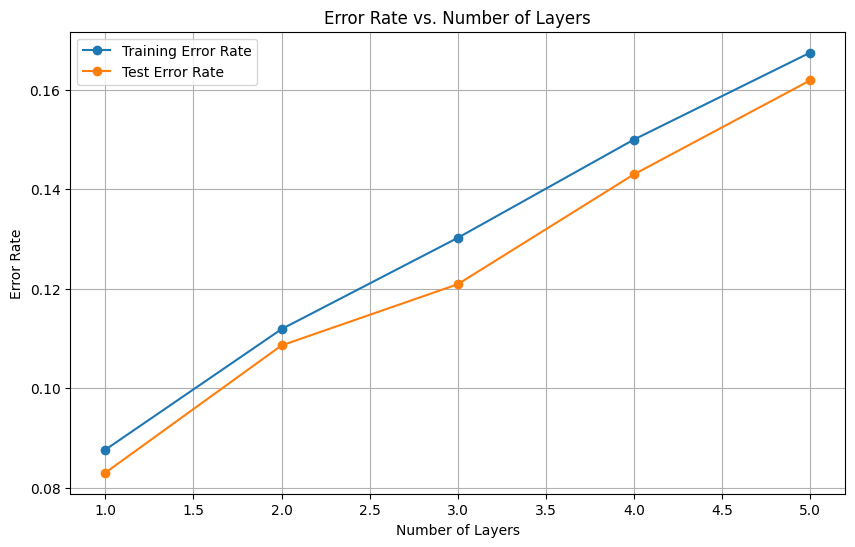

In [26]:
import matplotlib.pyplot as plt

# Load the error rates for each number of layers
num_layers = [1, 2, 3, 4, 5]
train_error_rates = []
test_error_rates = []

for n_layers in num_layers:
    train_error_rate_layer = load_object("pretrain_layer_error_rate_train_" + str(n_layers) + ".pkl","../results/experiments_mnist")
    test_error_rate_layer = load_object("pretrain_layer_error_rate_test_" + str(n_layers) + ".pkl","../results/experiments_mnist")
    
# Plotting the error rates
plt.figure(figsize=(10, 6))
plt.plot(num_layers, train_error_rate_layer, label='Training Error Rate', marker='o')
plt.plot(num_layers, test_error_rate_layer, label='Test Error Rate', marker='o')

plt.xlabel('Number of Layers')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. Number of Layers')
plt.legend()
plt.grid(True)
plt.show()


# 2.  number of neurons per layers

## 2.1. Without pretraining

In [41]:
n_samples, n_visible = mnist_train.shape # n_samples, n_features
n_classes = mnist_test_labels.shape[1]

neurons_per_layer = [100, 300, 500, 700]
layer_loss_neurons = []
layer_error_rate_train_neurons = []
layer_error_rate_test_neurons = []

for n_neurons in neurons_per_layer:
    hidden_layer_sizes = [n_neurons] * 2  # Fixer le nombre de couches à 2
    dnn = DNN(input_dim=n_visible, output_dim=n_classes, hidden_layer_sizes=hidden_layer_sizes, random_state=42)
    loss = dnn.backpropagation(binary_mnist_train, labels=mnist_train_labels, n_epochs=10, learning_rate=3e-4, batch_size=512)
    layer_loss_neurons.append(loss)
    
    error_rate_train, _ = dnn.test(test_data=binary_mnist_train, true_labels=mnist_train_labels)
    layer_error_rate_train_neurons.append(error_rate_train)  # Assurez-vous que error_rate_train est un scalaire

    error_rate_test, _ = dnn.test(test_data=binary_mnist_test, true_labels=mnist_test_labels)
    layer_error_rate_test_neurons.append(error_rate_test)  # Assurez-vous que error_rate_test est un scalaire

    # Save the lists with losses and error rates
    save_object(layer_loss_neurons, "layer_loss_neurons_" + str(n_neurons) + ".pkl","../results/experiments_mnist")
    save_object(layer_error_rate_train_neurons, "layer_error_rate_train_neurons_" + str(n_neurons) + ".pkl","../results/experiments_mnist")
    save_object(layer_error_rate_test_neurons, "layer_error_rate_test_neurons_" + str(n_neurons) + ".pkl","../results/experiments_mnist")


Training:  10%|█         | 1/10 [00:01<00:16,  1.86s/epoch]

Epoch 1/10, Cross Entropy: 2.362480259194659


Training:  20%|██        | 2/10 [00:03<00:15,  1.88s/epoch]

Epoch 2/10, Cross Entropy: 2.303130348354594


Training:  30%|███       | 3/10 [00:05<00:12,  1.84s/epoch]

Epoch 3/10, Cross Entropy: 2.277005887986886


Training:  40%|████      | 4/10 [00:07<00:11,  1.86s/epoch]

Epoch 4/10, Cross Entropy: 2.266685608902804


Training:  50%|█████     | 5/10 [00:09<00:09,  1.86s/epoch]

Epoch 5/10, Cross Entropy: 2.262026109459971


Training:  60%|██████    | 6/10 [00:11<00:07,  1.88s/epoch]

Epoch 6/10, Cross Entropy: 2.2599482845098797


Training:  70%|███████   | 7/10 [00:13<00:05,  1.86s/epoch]

Epoch 7/10, Cross Entropy: 2.2585363383455683


Training:  80%|████████  | 8/10 [00:15<00:03,  1.98s/epoch]

Epoch 8/10, Cross Entropy: 2.260722772450352


Training:  90%|█████████ | 9/10 [00:17<00:02,  2.03s/epoch]

Epoch 9/10, Cross Entropy: 2.2582668628161477


Training: 100%|██████████| 10/10 [00:19<00:00,  1.92s/epoch]


Epoch 10/10, Cross Entropy: 2.258815821474395


Training:  10%|█         | 1/10 [00:03<00:30,  3.43s/epoch]

Epoch 1/10, Cross Entropy: 2.4143874928280322


Training:  20%|██        | 2/10 [00:07<00:28,  3.53s/epoch]

Epoch 2/10, Cross Entropy: 2.187025970617257


Training:  30%|███       | 3/10 [00:10<00:24,  3.46s/epoch]

Epoch 3/10, Cross Entropy: 2.0982624775412027


Training:  40%|████      | 4/10 [00:13<00:20,  3.47s/epoch]

Epoch 4/10, Cross Entropy: 2.0580216983697595


Training:  50%|█████     | 5/10 [00:17<00:17,  3.46s/epoch]

Epoch 5/10, Cross Entropy: 2.0447232992053945


Training:  60%|██████    | 6/10 [00:20<00:13,  3.46s/epoch]

Epoch 6/10, Cross Entropy: 2.037631272986506


Training:  70%|███████   | 7/10 [00:24<00:10,  3.50s/epoch]

Epoch 7/10, Cross Entropy: 2.028953330193732


Training:  80%|████████  | 8/10 [00:28<00:07,  3.55s/epoch]

Epoch 8/10, Cross Entropy: 2.027270791225791


Training:  90%|█████████ | 9/10 [00:31<00:03,  3.49s/epoch]

Epoch 9/10, Cross Entropy: 2.0284196674494464


Training: 100%|██████████| 10/10 [00:34<00:00,  3.49s/epoch]


Epoch 10/10, Cross Entropy: 2.0227113804360632


Training:  10%|█         | 1/10 [00:04<00:43,  4.85s/epoch]

Epoch 1/10, Cross Entropy: 2.548518678417946


Training:  20%|██        | 2/10 [00:09<00:39,  4.95s/epoch]

Epoch 2/10, Cross Entropy: 2.153764256674477


Training:  30%|███       | 3/10 [00:14<00:34,  4.89s/epoch]

Epoch 3/10, Cross Entropy: 2.018097533308627


Training:  40%|████      | 4/10 [00:19<00:29,  4.91s/epoch]

Epoch 4/10, Cross Entropy: 1.91894261346049


Training:  50%|█████     | 5/10 [00:24<00:24,  4.92s/epoch]

Epoch 5/10, Cross Entropy: 1.8777400787846241


Training:  60%|██████    | 6/10 [00:29<00:19,  4.98s/epoch]

Epoch 6/10, Cross Entropy: 1.8714117026356836


Training:  70%|███████   | 7/10 [00:34<00:14,  4.94s/epoch]

Epoch 7/10, Cross Entropy: 1.8584894976612996


Training:  80%|████████  | 8/10 [00:39<00:09,  4.96s/epoch]

Epoch 8/10, Cross Entropy: 1.8459948004974387


Training:  90%|█████████ | 9/10 [00:44<00:04,  4.96s/epoch]

Epoch 9/10, Cross Entropy: 1.855550568395963


Training: 100%|██████████| 10/10 [00:49<00:00,  4.95s/epoch]


Epoch 10/10, Cross Entropy: 1.8345885692292536


Training:  10%|█         | 1/10 [00:06<00:57,  6.40s/epoch]

Epoch 1/10, Cross Entropy: 3.1222682959608195


Training:  20%|██        | 2/10 [00:12<00:51,  6.41s/epoch]

Epoch 2/10, Cross Entropy: 2.4196410109480353


Training:  30%|███       | 3/10 [00:19<00:44,  6.40s/epoch]

Epoch 3/10, Cross Entropy: 2.188166383141175


Training:  40%|████      | 4/10 [00:25<00:38,  6.40s/epoch]

Epoch 4/10, Cross Entropy: 2.023151241910357


Training:  50%|█████     | 5/10 [00:31<00:31,  6.39s/epoch]

Epoch 5/10, Cross Entropy: 1.96458846852894


Training:  60%|██████    | 6/10 [00:38<00:25,  6.39s/epoch]

Epoch 6/10, Cross Entropy: 1.887072706892094


Training:  70%|███████   | 7/10 [00:44<00:19,  6.39s/epoch]

Epoch 7/10, Cross Entropy: 1.8653320011184717


Training:  80%|████████  | 8/10 [00:51<00:12,  6.35s/epoch]

Epoch 8/10, Cross Entropy: 1.8681710574539567


Training:  90%|█████████ | 9/10 [00:57<00:06,  6.40s/epoch]

Epoch 9/10, Cross Entropy: 1.870900700612856


Training: 100%|██████████| 10/10 [01:03<00:00,  6.40s/epoch]

Epoch 10/10, Cross Entropy: 1.8589448976182728


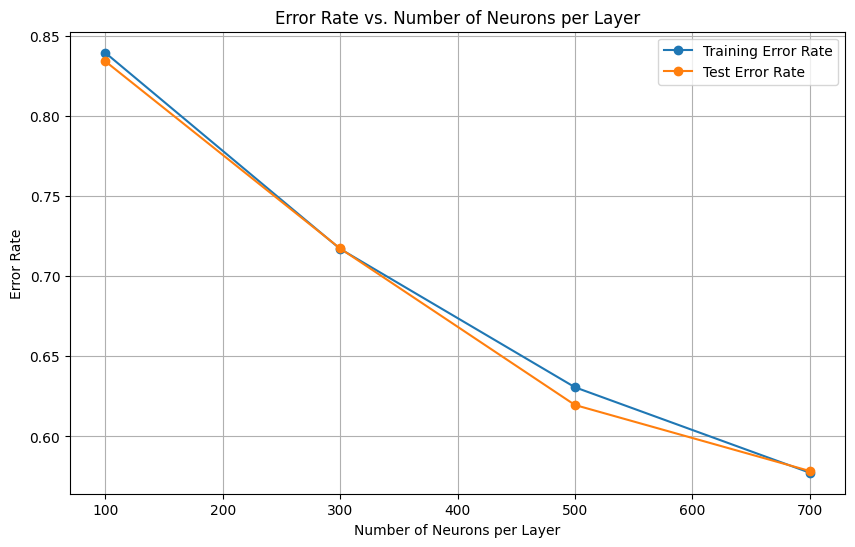

In [42]:
import matplotlib.pyplot as plt

# Load the error rates for each number of neurons per layer
neurons_per_layer = [100, 300, 500, 700]
train_error_rates_neurons = []
test_error_rates_neurons = []

for n_neurons in neurons_per_layer:
    train_error_rates_neurons = load_object("layer_error_rate_train_neurons_" + str(n_neurons) + ".pkl","../results/experiments_mnist")
    test_error_rates_neurons = load_object("layer_error_rate_test_neurons_" + str(n_neurons) + ".pkl","../results/experiments_mnist")
    

# Plotting the error rates for different numbers of neurons per layer
plt.figure(figsize=(10, 6))
plt.plot(neurons_per_layer, train_error_rates_neurons, label='Training Error Rate', marker='o')
plt.plot(neurons_per_layer, test_error_rates_neurons, label='Test Error Rate', marker='o')

plt.xlabel('Number of Neurons per Layer')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. Number of Neurons per Layer')
plt.legend()
plt.grid(True)
plt.show()


## 2.2. With pretraining

In [43]:
n_samples, n_visible = mnist_train.shape # n_samples, n_features
n_classes = mnist_test_labels.shape[1]

neurons_per_layer = [100, 300, 500, 700]
layer_loss_neurons = []
layer_error_rate_train_neurons = []
layer_error_rate_test_neurons = []

for n_neurons in neurons_per_layer:
    hidden_layer_sizes = [n_neurons] * 2  # Fixer le nombre de couches à 2
    dnn = DNN(input_dim=n_visible, output_dim=n_classes, hidden_layer_sizes=hidden_layer_sizes, random_state=42)
    
    # pretrain
    dnn.train(mnist_train, n_epochs=10, learning_rate=3e-4, batch_size=512)
    
    loss = dnn.backpropagation(binary_mnist_train, labels=mnist_train_labels, n_epochs=10, learning_rate=3e-4, batch_size=512)
    layer_loss_neurons.append(loss)
    
    error_rate_train, _ = dnn.test(test_data=binary_mnist_train, true_labels=mnist_train_labels)
    layer_error_rate_train_neurons.append(error_rate_train)  # Assurez-vous que error_rate_train est un scalaire

    error_rate_test, _ = dnn.test(test_data=binary_mnist_test, true_labels=mnist_test_labels)
    layer_error_rate_test_neurons.append(error_rate_test)  # Assurez-vous que error_rate_test est un scalaire

    # Save the lists with losses and error rates
    save_object(layer_loss_neurons, "pretrain_layer_loss_neurons_" + str(n_neurons) + ".pkl","../results/experiments_mnist")
    save_object(layer_error_rate_train_neurons, "pretrain_layer_error_rate_train_neurons_" + str(n_neurons) + ".pkl","../results/experiments_mnist")
    save_object(layer_error_rate_test_neurons, "pretrain_layer_error_rate_test_neurons_" + str(n_neurons) + ".pkl","../results/experiments_mnist")


Training RBM layers:   0%|          | 0/2 [00:00<?, ?layer/s]c:\Users\choho\Desktop\Master DS\Deep learning II\github\DeepLearning2-Project-M2DS\src\functionals.py:17: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
Training:  10%|█         | 1/10 [00:01<00:15,  1.72s/epoch]

Epoch 1/10, Cross Entropy: 2.3336797611999724


Training:  20%|██        | 2/10 [00:03<00:13,  1.75s/epoch]

Epoch 2/10, Cross Entropy: 2.323047757946269


Training:  30%|███       | 3/10 [00:05<00:12,  1.73s/epoch]

Epoch 3/10, Cross Entropy: 2.3246958989758366


Training:  40%|████      | 4/10 [00:07<00:10,  1.78s/epoch]

Epoch 4/10, Cross Entropy: 2.322452362700704


Training:  50%|█████     | 5/10 [00:08<00:08,  1.79s/epoch]

Epoch 5/10, Cross Entropy: 2.3204846571553204


Training:  60%|██████    | 6/10 [00:10<00:07,  1.82s/epoch]

Epoch 6/10, Cross Entropy: 2.319820097466143


Training:  70%|███████   | 7/10 [00:12<00:05,  1.77s/epoch]

Epoch 7/10, Cross Entropy: 2.3208194733682275


Training:  80%|████████  | 8/10 [00:14<00:03,  1.79s/epoch]

Epoch 8/10, Cross Entropy: 2.3215832318765135


Training:  90%|█████████ | 9/10 [00:15<00:01,  1.78s/epoch]

Epoch 9/10, Cross Entropy: 2.3245205880140416


Training: 100%|██████████| 10/10 [00:17<00:00,  1.79s/epoch]


Epoch 10/10, Cross Entropy: 2.3233198484585134


Training:  10%|█         | 1/10 [00:03<00:27,  3.05s/epoch]

Epoch 1/10, Cross Entropy: 4.044568282055888


Training:  20%|██        | 2/10 [00:06<00:24,  3.11s/epoch]

Epoch 2/10, Cross Entropy: 4.115989077057136


Training:  30%|███       | 3/10 [00:09<00:21,  3.10s/epoch]

Epoch 3/10, Cross Entropy: 4.3047569686825575


Training:  40%|████      | 4/10 [00:12<00:18,  3.13s/epoch]

Epoch 4/10, Cross Entropy: 4.23439198786972


Training:  50%|█████     | 5/10 [00:15<00:15,  3.16s/epoch]

Epoch 5/10, Cross Entropy: 4.132031220931409


Training:  60%|██████    | 6/10 [00:18<00:12,  3.14s/epoch]

Epoch 6/10, Cross Entropy: 4.033934706508113


Training:  70%|███████   | 7/10 [00:21<00:09,  3.16s/epoch]

Epoch 7/10, Cross Entropy: 4.081790063070603


Training:  80%|████████  | 8/10 [00:25<00:06,  3.14s/epoch]

Epoch 8/10, Cross Entropy: 4.173525541327632


Training:  90%|█████████ | 9/10 [00:28<00:03,  3.16s/epoch]

Epoch 9/10, Cross Entropy: 4.179385378684917


Training: 100%|██████████| 10/10 [00:31<00:00,  3.13s/epoch]


Epoch 10/10, Cross Entropy: 4.096481771765875


Training:  10%|█         | 1/10 [00:04<00:41,  4.63s/epoch]

Epoch 1/10, Cross Entropy: 12.196672508967689


Training:  20%|██        | 2/10 [00:09<00:37,  4.74s/epoch]

Epoch 2/10, Cross Entropy: 12.713913230304893


Training:  30%|███       | 3/10 [00:14<00:32,  4.70s/epoch]

Epoch 3/10, Cross Entropy: 12.0329605389928


Training:  40%|████      | 4/10 [00:18<00:28,  4.72s/epoch]

Epoch 4/10, Cross Entropy: 11.49412207863624


Training:  50%|█████     | 5/10 [00:23<00:23,  4.67s/epoch]

Epoch 5/10, Cross Entropy: 12.737555997362447


Training:  60%|██████    | 6/10 [00:28<00:18,  4.70s/epoch]

Epoch 6/10, Cross Entropy: 12.684297068504105


Training:  70%|███████   | 7/10 [00:32<00:14,  4.68s/epoch]

Epoch 7/10, Cross Entropy: 11.922505365980843


Training:  80%|████████  | 8/10 [00:37<00:09,  4.69s/epoch]

Epoch 8/10, Cross Entropy: 12.631387271725298


Training:  90%|█████████ | 9/10 [00:42<00:04,  4.65s/epoch]

Epoch 9/10, Cross Entropy: 12.599451229458998


Training: 100%|██████████| 10/10 [00:46<00:00,  4.69s/epoch]


Epoch 10/10, Cross Entropy: 11.927951757440264


Training:  10%|█         | 1/10 [00:05<00:51,  5.76s/epoch]

Epoch 1/10, Cross Entropy: 18.94345144646524


Training:  20%|██        | 2/10 [00:11<00:47,  5.92s/epoch]

Epoch 2/10, Cross Entropy: 17.763659813448204


Training:  30%|███       | 3/10 [00:17<00:41,  5.92s/epoch]

Epoch 3/10, Cross Entropy: 19.596010957857626


Training:  40%|████      | 4/10 [00:23<00:35,  5.95s/epoch]

Epoch 4/10, Cross Entropy: 18.283209546369978


Training:  50%|█████     | 5/10 [00:29<00:29,  5.95s/epoch]

Epoch 5/10, Cross Entropy: 19.08526179855331


Training:  60%|██████    | 6/10 [00:35<00:24,  6.02s/epoch]

Epoch 6/10, Cross Entropy: 18.106080104576908


Training:  70%|███████   | 7/10 [00:41<00:17,  5.99s/epoch]

Epoch 7/10, Cross Entropy: 18.73488785252841


Training:  80%|████████  | 8/10 [00:47<00:12,  6.03s/epoch]

Epoch 8/10, Cross Entropy: 19.15761055531007


Training:  90%|█████████ | 9/10 [00:53<00:06,  6.00s/epoch]

Epoch 9/10, Cross Entropy: 18.597885971594707


Training: 100%|██████████| 10/10 [00:59<00:00,  6.00s/epoch]


Epoch 10/10, Cross Entropy: 19.96200808477518


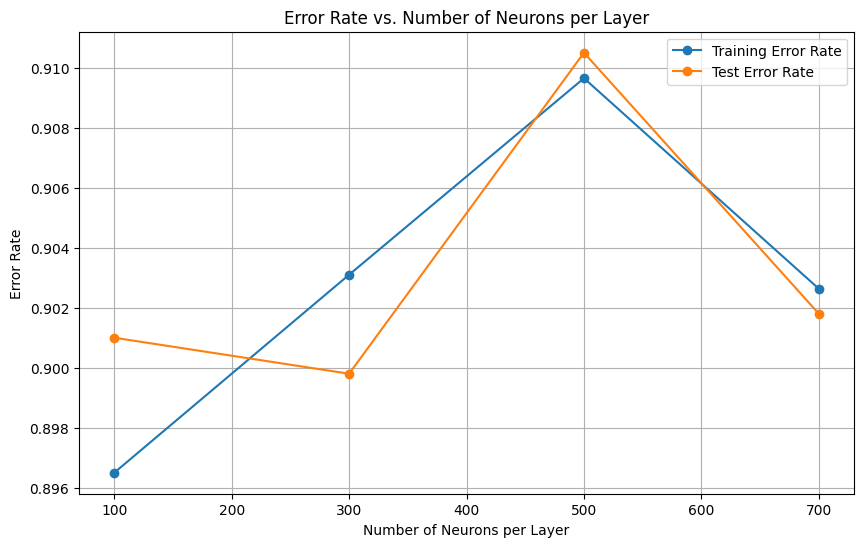

In [44]:
import matplotlib.pyplot as plt

# Load the error rates for each number of neurons per layer
neurons_per_layer = [100, 300, 500, 700]
train_error_rates_neurons = []
test_error_rates_neurons = []

for n_neurons in neurons_per_layer:
    train_error_rates_neurons = load_object("pretrain_layer_error_rate_train_neurons_" + str(n_neurons) + ".pkl","../results/experiments_mnist")
    test_error_rates_neurons = load_object("pretrain_layer_error_rate_test_neurons_" + str(n_neurons) + ".pkl","../results/experiments_mnist")
    

# Plotting the error rates for different numbers of neurons per layer
plt.figure(figsize=(10, 6))
plt.plot(neurons_per_layer, train_error_rates_neurons, label='Training Error Rate', marker='o')
plt.plot(neurons_per_layer, test_error_rates_neurons, label='Test Error Rate', marker='o')

plt.xlabel('Number of Neurons per Layer')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. Number of Neurons per Layer')
plt.legend()
plt.grid(True)
plt.show()


In [45]:
dnn.test(binary_mnist_test, mnist_test_labels)

(0.9018,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

# 3.  As a function of the number of data trains 

## 3.1. Without pretraining

In [28]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm



def create_stratified_subset(data, labels, num_samples_per_class):
    """
    Create a stratified subset of the dataset ensuring each class is represented equally.

    Parameters:
    - data (np.ndarray): The dataset.
    - labels (np.ndarray): The labels for the dataset.
    - num_samples_per_class (int): Number of samples per class.

    Returns:
    - subset_data (np.ndarray): Stratified subset of the dataset.
    - subset_labels (np.ndarray): Labels for the stratified subset.
    """
    unique_classes = np.unique(labels)
    subset_data = []
    subset_labels = []

    for cls in unique_classes:
        class_indices = np.where(labels == cls)[0]
        selected_indices = class_indices[:num_samples_per_class]
        subset_data.append(data[selected_indices])
        subset_labels.append(labels[selected_indices])

    subset_data = np.concatenate(subset_data, axis=0)
    subset_labels = np.concatenate(subset_labels, axis=0)

    return subset_data, subset_labels


In [29]:
n_samples, n_visible = mnist_train.shape  # n_samples, n_features
n_classes = mnist_test_labels.shape[1]

# Defining different sizes for the subsets ensuring equal representation for each class
data_sizes = [1000, 3000, 7000, 10000, 30000, 60000]
num_classes = len(np.unique(mnist_train_labels))
layer_loss_data = []
layer_error_rate_train_data = []
layer_error_rate_test_data = []

for data_size in data_sizes:
    num_samples_per_class = data_size // num_classes
    subset_train_data, subset_train_labels = create_stratified_subset(binary_mnist_train, mnist_train_labels, num_samples_per_class)
    
    hidden_layer_sizes = [200] * 2  # Fixer le nombre de couches à 2 avec 200 neurones chacune
    dnn = DNN(input_dim=n_visible, output_dim=n_classes, hidden_layer_sizes=hidden_layer_sizes, random_state=42)
    loss = dnn.backpropagation(subset_train_data, labels=subset_train_labels, n_epochs=10, learning_rate=3e-4, batch_size=512)
    layer_loss_data.append(loss)
    
    error_rate_train, _ = dnn.test(test_data=subset_train_data, true_labels=subset_train_labels)
    layer_error_rate_train_data.append(error_rate_train)  # Assurez-vous que error_rate_train est un scalaire

    error_rate_test, _ = dnn.test(test_data=binary_mnist_test, true_labels=mnist_test_labels)
    layer_error_rate_test_data.append(error_rate_test)  # Assurez-vous que error_rate_test est un scalaire

    # Save the lists with losses and error rates
    save_object(layer_loss_data, "number_loss_data_" + str(data_size) + ".pkl","../results/experiments_mnist")
    save_object(layer_error_rate_train_data, "number_error_rate_train_data_" + str(data_size) + ".pkl","../results/experiments_mnist")
    save_object(layer_error_rate_test_data, "number_error_rate_test_data_" + str(data_size) + ".pkl","../results/experiments_mnist")


Training:  60%|██████    | 6/10 [00:00<00:00, 28.00epoch/s]

Epoch 1/10, Cross Entropy: 1.805600489511827
Epoch 2/10, Cross Entropy: 0.0037160213304005918
Epoch 3/10, Cross Entropy: 0.00325771933186785
Epoch 4/10, Cross Entropy: 0.003233860143354369
Epoch 5/10, Cross Entropy: 0.003120668175874325
Epoch 6/10, Cross Entropy: 0.002955628722523679


Training: 100%|██████████| 10/10 [00:00<00:00, 28.49epoch/s]


Epoch 7/10, Cross Entropy: 0.002963625600423784
Epoch 8/10, Cross Entropy: 0.0028307020799938913
Epoch 9/10, Cross Entropy: 0.0025558072860364395
Epoch 10/10, Cross Entropy: 0.002361266552574398


Training:  20%|██        | 2/10 [00:00<00:00, 11.24epoch/s]

Epoch 1/10, Cross Entropy: 0.5345987079761084
Epoch 2/10, Cross Entropy: 0.002529007990025304
Epoch 3/10, Cross Entropy: 0.00223520625848401


Training:  40%|████      | 4/10 [00:00<00:00, 11.84epoch/s]

Epoch 4/10, Cross Entropy: 0.0020178625835534808
Epoch 5/10, Cross Entropy: 0.0018156515897768705


Training:  60%|██████    | 6/10 [00:00<00:00, 10.64epoch/s]

Epoch 6/10, Cross Entropy: 0.0017148089467884243
Epoch 7/10, Cross Entropy: 0.0015503530064043707


Training: 100%|██████████| 10/10 [00:00<00:00, 10.76epoch/s]


Epoch 8/10, Cross Entropy: 0.0013776546798526378
Epoch 9/10, Cross Entropy: 0.001316230990107831
Epoch 10/10, Cross Entropy: 0.0011952959237497445


Training:  10%|█         | 1/10 [00:00<00:01,  4.90epoch/s]

Epoch 1/10, Cross Entropy: 0.20819963711860523


Training:  20%|██        | 2/10 [00:00<00:01,  4.92epoch/s]

Epoch 2/10, Cross Entropy: 0.0018502559548010033


Training:  30%|███       | 3/10 [00:00<00:01,  4.20epoch/s]

Epoch 3/10, Cross Entropy: 0.0014891702436102244


Training:  40%|████      | 4/10 [00:01<00:01,  3.64epoch/s]

Epoch 4/10, Cross Entropy: 0.0012243749844857124


Training:  50%|█████     | 5/10 [00:01<00:01,  3.99epoch/s]

Epoch 5/10, Cross Entropy: 0.0010697192997867703


Training:  60%|██████    | 6/10 [00:01<00:00,  4.27epoch/s]

Epoch 6/10, Cross Entropy: 0.0009399257347730774


Training:  70%|███████   | 7/10 [00:01<00:00,  4.51epoch/s]

Epoch 7/10, Cross Entropy: 0.0008524250044660183


Training:  80%|████████  | 8/10 [00:01<00:00,  4.61epoch/s]

Epoch 8/10, Cross Entropy: 0.0007900809567671298


Training:  90%|█████████ | 9/10 [00:02<00:00,  4.75epoch/s]

Epoch 9/10, Cross Entropy: 0.0007039933965968812


Training: 100%|██████████| 10/10 [00:02<00:00,  4.44epoch/s]


Epoch 10/10, Cross Entropy: 0.0006552039845094698


Training:  10%|█         | 1/10 [00:00<00:02,  3.61epoch/s]

Epoch 1/10, Cross Entropy: 0.19617986238171517


Training:  20%|██        | 2/10 [00:00<00:02,  3.53epoch/s]

Epoch 2/10, Cross Entropy: 0.0021241565202059923


Training:  30%|███       | 3/10 [00:00<00:01,  3.51epoch/s]

Epoch 3/10, Cross Entropy: 0.0015675574773615308


Training:  40%|████      | 4/10 [00:01<00:01,  3.56epoch/s]

Epoch 4/10, Cross Entropy: 0.0012510292701571949


Training:  50%|█████     | 5/10 [00:01<00:01,  3.31epoch/s]

Epoch 5/10, Cross Entropy: 0.0009985636828818965


Training:  60%|██████    | 6/10 [00:01<00:01,  3.25epoch/s]

Epoch 6/10, Cross Entropy: 0.0008736612155418769


Training:  70%|███████   | 7/10 [00:02<00:00,  3.32epoch/s]

Epoch 7/10, Cross Entropy: 0.0007617841154398307


Training:  80%|████████  | 8/10 [00:02<00:00,  3.43epoch/s]

Epoch 8/10, Cross Entropy: 0.000665421331983955


Training:  90%|█████████ | 9/10 [00:02<00:00,  3.44epoch/s]

Epoch 9/10, Cross Entropy: 0.0005963431257746585


Training: 100%|██████████| 10/10 [00:02<00:00,  3.43epoch/s]


Epoch 10/10, Cross Entropy: 0.0005397215518468615


Training:  10%|█         | 1/10 [00:01<00:09,  1.03s/epoch]

Epoch 1/10, Cross Entropy: 0.9592756869835842


Training:  20%|██        | 2/10 [00:02<00:08,  1.09s/epoch]

Epoch 2/10, Cross Entropy: 0.7990865770269807


Training:  30%|███       | 3/10 [00:03<00:07,  1.01s/epoch]

Epoch 3/10, Cross Entropy: 0.7459014271499045


Training:  40%|████      | 4/10 [00:04<00:05,  1.01epoch/s]

Epoch 4/10, Cross Entropy: 0.6774879111505167


Training:  50%|█████     | 5/10 [00:04<00:04,  1.04epoch/s]

Epoch 5/10, Cross Entropy: 0.6801448001036914


Training:  60%|██████    | 6/10 [00:05<00:03,  1.04epoch/s]

Epoch 6/10, Cross Entropy: 0.6691340300203005


Training:  70%|███████   | 7/10 [00:06<00:02,  1.06epoch/s]

Epoch 7/10, Cross Entropy: 0.6671334063560398


Training:  80%|████████  | 8/10 [00:07<00:01,  1.05epoch/s]

Epoch 8/10, Cross Entropy: 0.6832605683293654


Training:  90%|█████████ | 9/10 [00:08<00:00,  1.02epoch/s]

Epoch 9/10, Cross Entropy: 0.666514195304364


Training: 100%|██████████| 10/10 [00:09<00:00,  1.02epoch/s]


Epoch 10/10, Cross Entropy: 0.67329584380507


Training:  10%|█         | 1/10 [00:01<00:16,  1.82s/epoch]

Epoch 1/10, Cross Entropy: 1.4170289912271337


Training:  20%|██        | 2/10 [00:03<00:14,  1.79s/epoch]

Epoch 2/10, Cross Entropy: 1.2150725368504567


Training:  30%|███       | 3/10 [00:05<00:13,  1.87s/epoch]

Epoch 3/10, Cross Entropy: 1.1295651814777283


Training:  40%|████      | 4/10 [00:07<00:11,  1.86s/epoch]

Epoch 4/10, Cross Entropy: 1.1026105411041294


Training:  50%|█████     | 5/10 [00:09<00:09,  1.92s/epoch]

Epoch 5/10, Cross Entropy: 1.120955591383161


Training:  60%|██████    | 6/10 [00:11<00:07,  1.86s/epoch]

Epoch 6/10, Cross Entropy: 1.1177193372609369


Training:  70%|███████   | 7/10 [00:12<00:05,  1.85s/epoch]

Epoch 7/10, Cross Entropy: 1.1057384237951848


Training:  80%|████████  | 8/10 [00:14<00:03,  1.81s/epoch]

Epoch 8/10, Cross Entropy: 1.0961015089144304


Training:  90%|█████████ | 9/10 [00:16<00:01,  1.84s/epoch]

Epoch 9/10, Cross Entropy: 1.1148278521388209


Training: 100%|██████████| 10/10 [00:18<00:00,  1.84s/epoch]


Epoch 10/10, Cross Entropy: 1.1137621186624322


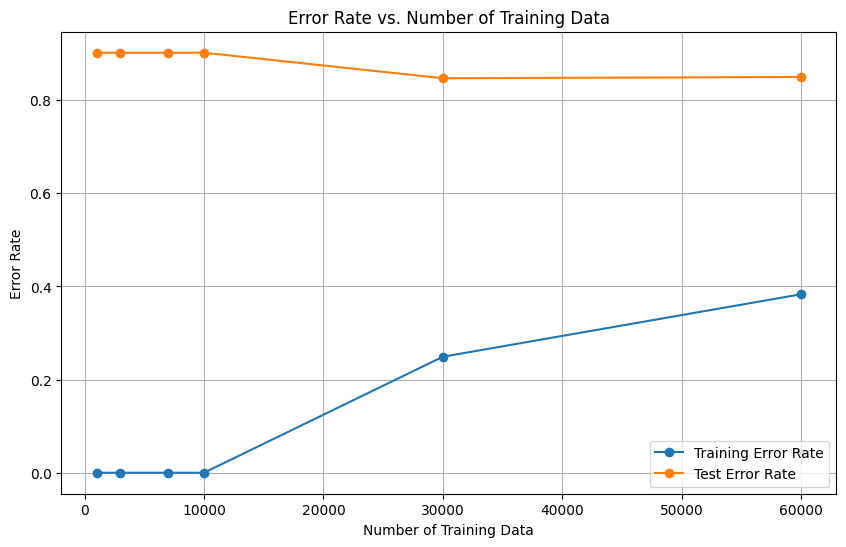

In [30]:
# Load the error rates for each data size
data_sizes = [1000, 3000, 7000, 10000, 30000, 60000]
train_error_rates_data = []
test_error_rates_data = []

for data_size in data_sizes:
    train_error_rates_data = load_object("number_error_rate_train_data_" + str(data_size) + ".pkl","../results/experiments_mnist")
    test_error_rates_data = load_object("number_error_rate_test_data_" + str(data_size) + ".pkl","../results/experiments_mnist")
    
# Plotting the error rates for different numbers of training data
plt.figure(figsize=(10, 6))
plt.plot(data_sizes, train_error_rates_data, label='Training Error Rate', marker='o')
plt.plot(data_sizes, test_error_rates_data, label='Test Error Rate', marker='o')

plt.xlabel('Number of Training Data')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. Number of Training Data')
plt.legend()
plt.grid(True)
plt.show()


## 3.2. With pretraining

In [31]:
n_samples, n_visible = mnist_train.shape  # n_samples, n_features
n_classes = mnist_test_labels.shape[1]

# Defining different sizes for the subsets ensuring equal representation for each class
data_sizes = [1000, 3000, 7000, 10000, 30000, 60000]
num_classes = len(np.unique(mnist_train_labels))
layer_loss_data = []
layer_error_rate_train_data = []
layer_error_rate_test_data = []

for data_size in data_sizes:
    num_samples_per_class = data_size // num_classes
    subset_train_data, subset_train_labels = create_stratified_subset(binary_mnist_train, mnist_train_labels, num_samples_per_class)
    
    hidden_layer_sizes = [200] * 2  # Fixer le nombre de couches à 2 avec 200 neurones chacune
    dnn = DNN(input_dim=n_visible, output_dim=n_classes, hidden_layer_sizes=hidden_layer_sizes, random_state=42)

    # pretrain
    dnn.train(binary_mnist_train, n_epochs=10, learning_rate=3e-4, batch_size=512)

    loss = dnn.backpropagation(subset_train_data, labels=subset_train_labels, n_epochs=10, learning_rate=3e-4, batch_size=512)
    layer_loss_data.append(loss)
    
    error_rate_train, _ = dnn.test(test_data=subset_train_data, true_labels=subset_train_labels)
    layer_error_rate_train_data.append(error_rate_train)  # Assurez-vous que error_rate_train est un scalaire

    error_rate_test, _ = dnn.test(test_data=binary_mnist_test, true_labels=mnist_test_labels)
    layer_error_rate_test_data.append(error_rate_test)  # Assurez-vous que error_rate_test est un scalaire

    # Save the lists with losses and error rates
    save_object(layer_loss_data, "pretrain_number_loss_data_" + str(data_size) + ".pkl","../results/experiments_mnist")
    save_object(layer_error_rate_train_data, "pretrain_number_error_rate_train_data_" + str(data_size) + ".pkl","../results/experiments_mnist")
    save_object(layer_error_rate_test_data, "pretrain_number_error_rate_test_data_" + str(data_size) + ".pkl","../results/experiments_mnist")


Training:  30%|███       | 3/10 [00:00<00:00, 27.44epoch/s]

Epoch 1/10, Cross Entropy: 1.6908007925280921
Epoch 2/10, Cross Entropy: 0.005407700320137615
Epoch 3/10, Cross Entropy: 0.00495633712773906
Epoch 4/10, Cross Entropy: 0.004749149608898682
Epoch 5/10, Cross Entropy: 0.004473825055689003


Training: 100%|██████████| 10/10 [00:00<00:00, 27.44epoch/s]


Epoch 6/10, Cross Entropy: 0.004230903151687096
Epoch 7/10, Cross Entropy: 0.003952708984912544
Epoch 8/10, Cross Entropy: 0.0035099613968880036
Epoch 9/10, Cross Entropy: 0.003570828489913555
Epoch 10/10, Cross Entropy: 0.0034277183160117495


Training:  20%|██        | 2/10 [00:00<00:00,  9.72epoch/s]

Epoch 1/10, Cross Entropy: 0.5437325846991529
Epoch 2/10, Cross Entropy: 0.005338166537632007


Training:  40%|████      | 4/10 [00:00<00:00,  8.83epoch/s]

Epoch 3/10, Cross Entropy: 0.0044455424398622155
Epoch 4/10, Cross Entropy: 0.0036795675593344667


Training:  60%|██████    | 6/10 [00:00<00:00,  9.52epoch/s]

Epoch 5/10, Cross Entropy: 0.0032858246698743705
Epoch 6/10, Cross Entropy: 0.002829062757081702


Training:  80%|████████  | 8/10 [00:00<00:00,  9.75epoch/s]

Epoch 7/10, Cross Entropy: 0.0025224971776767764
Epoch 8/10, Cross Entropy: 0.002215552786634143


Training: 100%|██████████| 10/10 [00:01<00:00,  9.83epoch/s]


Epoch 9/10, Cross Entropy: 0.0020457381989527072
Epoch 10/10, Cross Entropy: 0.0019424636974253835


Training:  10%|█         | 1/10 [00:00<00:01,  4.90epoch/s]

Epoch 1/10, Cross Entropy: 0.17877145672977388


Training:  20%|██        | 2/10 [00:00<00:01,  5.13epoch/s]

Epoch 2/10, Cross Entropy: 0.002669247743469967


Training:  30%|███       | 3/10 [00:00<00:01,  4.78epoch/s]

Epoch 3/10, Cross Entropy: 0.002101708736538543


Training:  40%|████      | 4/10 [00:00<00:01,  4.76epoch/s]

Epoch 4/10, Cross Entropy: 0.001724982626103188


Training:  50%|█████     | 5/10 [00:01<00:01,  4.69epoch/s]

Epoch 5/10, Cross Entropy: 0.0015074776308728376


Training:  60%|██████    | 6/10 [00:01<00:00,  4.82epoch/s]

Epoch 6/10, Cross Entropy: 0.0012831694822358138


Training:  70%|███████   | 7/10 [00:01<00:00,  4.55epoch/s]

Epoch 7/10, Cross Entropy: 0.0011276661168953643


Training:  80%|████████  | 8/10 [00:01<00:00,  4.71epoch/s]

Epoch 8/10, Cross Entropy: 0.0010359964324419854


Training:  90%|█████████ | 9/10 [00:01<00:00,  4.69epoch/s]

Epoch 9/10, Cross Entropy: 0.0009180276241412846


Training: 100%|██████████| 10/10 [00:02<00:00,  4.75epoch/s]


Epoch 10/10, Cross Entropy: 0.0008466324994637751


Training:  10%|█         | 1/10 [00:00<00:02,  3.64epoch/s]

Epoch 1/10, Cross Entropy: 0.15588621595752267


Training:  20%|██        | 2/10 [00:00<00:02,  3.66epoch/s]

Epoch 2/10, Cross Entropy: 0.0025865083293569514


Training:  30%|███       | 3/10 [00:00<00:01,  3.67epoch/s]

Epoch 3/10, Cross Entropy: 0.0018858409659870752


Training:  40%|████      | 4/10 [00:01<00:01,  3.72epoch/s]

Epoch 4/10, Cross Entropy: 0.0014908874112890842


Training:  50%|█████     | 5/10 [00:01<00:01,  3.73epoch/s]

Epoch 5/10, Cross Entropy: 0.0012360504324719261


Training:  60%|██████    | 6/10 [00:01<00:01,  3.46epoch/s]

Epoch 6/10, Cross Entropy: 0.0010534566391883428


Training:  70%|███████   | 7/10 [00:01<00:00,  3.43epoch/s]

Epoch 7/10, Cross Entropy: 0.0009095412128911738


Training:  80%|████████  | 8/10 [00:02<00:00,  3.52epoch/s]

Epoch 8/10, Cross Entropy: 0.0008210530598810657


Training:  90%|█████████ | 9/10 [00:02<00:00,  3.59epoch/s]

Epoch 9/10, Cross Entropy: 0.0007288171829749141


Training: 100%|██████████| 10/10 [00:02<00:00,  3.62epoch/s]


Epoch 10/10, Cross Entropy: 0.000644132826648519


Training:  10%|█         | 1/10 [00:00<00:06,  1.30epoch/s]

Epoch 1/10, Cross Entropy: 0.21155357954976


Training:  20%|██        | 2/10 [00:01<00:06,  1.23epoch/s]

Epoch 2/10, Cross Entropy: 0.07194553835344059


Training:  30%|███       | 3/10 [00:02<00:05,  1.25epoch/s]

Epoch 3/10, Cross Entropy: 0.05788806750944581


Training:  40%|████      | 4/10 [00:03<00:04,  1.21epoch/s]

Epoch 4/10, Cross Entropy: 0.05258637744462313


Training:  50%|█████     | 5/10 [00:04<00:04,  1.17epoch/s]

Epoch 5/10, Cross Entropy: 0.048350102829014516


Training:  60%|██████    | 6/10 [00:04<00:03,  1.19epoch/s]

Epoch 6/10, Cross Entropy: 0.04643556890203649


Training:  70%|███████   | 7/10 [00:05<00:02,  1.21epoch/s]

Epoch 7/10, Cross Entropy: 0.04545420555689158


Training:  80%|████████  | 8/10 [00:06<00:01,  1.20epoch/s]

Epoch 8/10, Cross Entropy: 0.042385499252418836


Training:  90%|█████████ | 9/10 [00:07<00:00,  1.22epoch/s]

Epoch 9/10, Cross Entropy: 0.0413677582794361


Training: 100%|██████████| 10/10 [00:08<00:00,  1.21epoch/s]


Epoch 10/10, Cross Entropy: 0.041704295207026156


Training:  10%|█         | 1/10 [00:01<00:14,  1.56s/epoch]

Epoch 1/10, Cross Entropy: 0.31010705131465877


Training:  20%|██        | 2/10 [00:03<00:13,  1.64s/epoch]

Epoch 2/10, Cross Entropy: 0.13880525671511032


Training:  30%|███       | 3/10 [00:04<00:11,  1.63s/epoch]

Epoch 3/10, Cross Entropy: 0.12201309875850748


Training:  40%|████      | 4/10 [00:06<00:09,  1.64s/epoch]

Epoch 4/10, Cross Entropy: 0.11298697483325884


Training:  50%|█████     | 5/10 [00:08<00:08,  1.62s/epoch]

Epoch 5/10, Cross Entropy: 0.10870251382254421


Training:  60%|██████    | 6/10 [00:09<00:06,  1.62s/epoch]

Epoch 6/10, Cross Entropy: 0.10517316606764503


Training:  70%|███████   | 7/10 [00:11<00:04,  1.62s/epoch]

Epoch 7/10, Cross Entropy: 0.10390724062555323


Training:  80%|████████  | 8/10 [00:12<00:03,  1.63s/epoch]

Epoch 8/10, Cross Entropy: 0.1002537127554385


Training:  90%|█████████ | 9/10 [00:14<00:01,  1.59s/epoch]

Epoch 9/10, Cross Entropy: 0.09853821794688086


Training: 100%|██████████| 10/10 [00:16<00:00,  1.62s/epoch]


Epoch 10/10, Cross Entropy: 0.0973240039407522


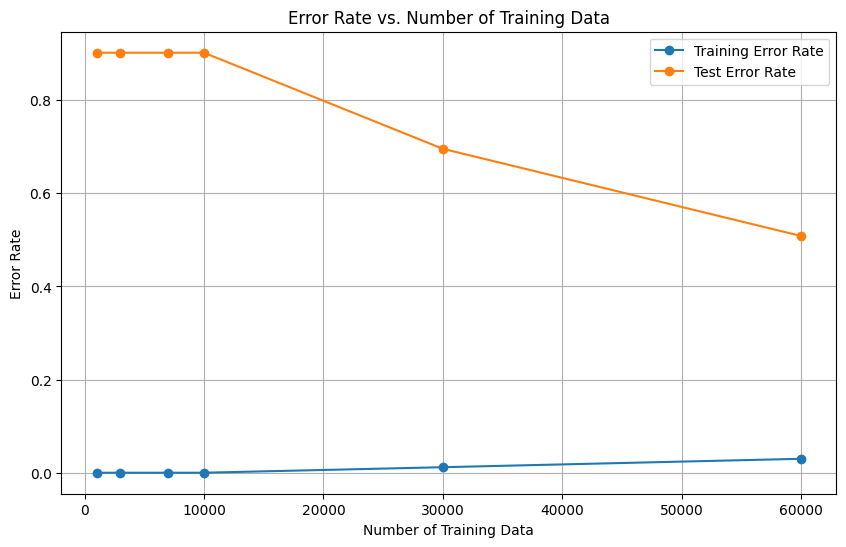

In [32]:
# Load the error rates for each data size
data_sizes = [1000, 3000, 7000, 10000, 30000, 60000]
train_error_rates_data = []
test_error_rates_data = []

for data_size in data_sizes:
    train_error_rates_data = load_object("pretrain_number_error_rate_train_data_" + str(data_size) + ".pkl", "../results/experiments_mnist")
    test_error_rates_data = load_object("pretrain_number_error_rate_test_data_" + str(data_size) + ".pkl", "../results/experiments_mnist")
    
# Plotting the error rates for different numbers of training data
plt.figure(figsize=(10, 6))
plt.plot(data_sizes, train_error_rates_data, label='Training Error Rate', marker='o')
plt.plot(data_sizes, test_error_rates_data, label='Test Error Rate', marker='o')

plt.xlabel('Number of Training Data')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. Number of Training Data')
plt.legend()
plt.grid(True)
plt.show()
